In [5]:
import pandas as pd 
import numpy as np
import sklearn
import pickle
import matplotlib.pyplot as plt
import lazypredict
import xgboost as xgb

from skopt import BayesSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, StackingClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV, cross_val_score

from lazypredict.Supervised import LazyClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

In [3]:
def make_submission(preds):
    assert len(preds) == 5000
    
    # Read labels
    with open('test_labels_sorted.npy', 'rb') as f:
        test_labels = np.load(f)
    len(test_labels)
    
    submission = pd.DataFrame(columns=['id', 'class'])
    for label, pred in zip(test_labels, preds):
        submission = submission.append({'id': label, 'class': pred}, ignore_index=True)
    return submission

In [4]:
def plot_confusion_matrix(y_val_from_train: np.array, y_pred_from_train: np.array):
    """Plot confusion matrix given predictions and truth values"""
    _, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_val_from_train, y_pred_from_train))
    cmp.plot(ax=ax)
    plt.show()

## Load X_train, y_train, X_test 43f

In [137]:
# Load X_train
with open('X_train_43.npy', 'rb') as f:
    X_train = np.load(f)
print(X_train.shape)
X_train

(9000, 43)


array([[-8.81665000e-01,  1.04447100e+00,  1.59010940e-01, ...,
         1.29894686e+00,  9.86426663e-02,  1.29471645e+01],
       [-1.10552300e+00,  1.12647200e+00,  1.74547752e-01, ...,
         1.29363158e+00,  1.42413478e-01,  1.38184886e+01],
       [-2.64679000e+00,  3.47160000e-02, -1.61696002e+00, ...,
         2.62288645e+00,  1.06095621e-01,  1.33114980e+01],
       ...,
       [-1.56939900e+00,  8.21211000e-01, -4.06112460e-01, ...,
         2.09723416e+00,  1.60231251e-01,  1.38336216e+01],
       [-1.09474900e+00,  1.15340700e+00,  8.15228667e-03, ...,
         1.54660804e+00,  1.99383090e-01,  1.39800549e+01],
       [-1.13664700e+00,  8.64905000e-01, -5.17633651e-01, ...,
         2.32898748e+00,  8.26406975e-02,  1.37358806e+01]])

In [138]:
# Load y_train
with open('y_train.npy', 'rb') as f:
    y_train = np.load(f)
print(y_train.shape)
y_train

(9000,)


array([ 7, 13,  6, ...,  3,  3, 18], dtype=int64)

In [139]:
# Load X_test
with open('X_test_43.npy', 'rb') as f:
    X_test = np.load(f)
print(X_test.shape)
X_test

(5000, 43)


array([[-1.83755000e+00,  1.38265100e+00, -3.05412347e-01, ...,
         1.93942445e+00,  2.14040399e-01,  1.37640621e+01],
       [-1.74357700e+00,  1.61488900e+00, -3.54157081e-01, ...,
         1.96847954e+00,  1.19986868e-01,  1.29569175e+01],
       [-1.87047000e+00, -2.16077000e-01, -8.47212227e-01, ...,
         2.73514368e+00,  1.54109933e-01,  1.39464683e+01],
       ...,
       [-6.30872000e-01,  6.78756000e-01,  4.29758667e-03, ...,
         1.54247731e+00,  8.17718765e-02,  1.29786762e+01],
       [-2.13143800e+00,  4.72850000e-02, -1.05151830e+00, ...,
         2.68148493e+00,  9.04578235e-02,  1.42111488e+01],
       [-1.54605600e+00,  2.98677000e-01, -5.40031205e-01, ...,
         2.40775477e+00,  1.33443744e-01,  1.25388069e+01]])

In [140]:
# Create validation data
# Train/test sets
X_train_from_train, X_val_from_train, y_train_from_train, y_val_from_train = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

## Catboost

In [141]:
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=69)

In [142]:
cbc = CatBoostClassifier(use_best_model=True, loss_function='MultiClass', task_type="GPU", iterations=10000)
# cbc = CatBoostClassifier()

In [143]:
%%time
cbc.fit(X_train_from_train, y_train_from_train, eval_set=(X_val_from_train, y_val_from_train))
# cbc.fit(X_train, y_train)

Learning rate set to 0.047215
0:	learn: 2.6381914	test: 2.6370792	best: 2.6370792 (0)	total: 5.52s	remaining: 15h 20m 11s
1:	learn: 2.4132682	test: 2.4111952	best: 2.4111952 (1)	total: 10.2s	remaining: 14h 9m 56s
2:	learn: 2.2418742	test: 2.2430561	best: 2.2430561 (2)	total: 14.9s	remaining: 13h 47m 7s
3:	learn: 2.1008927	test: 2.1011160	best: 2.1011160 (3)	total: 19.6s	remaining: 13h 36m 50s
4:	learn: 1.9872910	test: 1.9867155	best: 1.9867155 (4)	total: 24.5s	remaining: 13h 37m 43s
5:	learn: 1.8855199	test: 1.8839227	best: 1.8839227 (5)	total: 29.4s	remaining: 13h 35m 28s
6:	learn: 1.7878276	test: 1.7854062	best: 1.7854062 (6)	total: 34.4s	remaining: 13h 38m 55s
7:	learn: 1.6999631	test: 1.6980111	best: 1.6980111 (7)	total: 39.3s	remaining: 13h 37m 38s
8:	learn: 1.6255007	test: 1.6232729	best: 1.6232729 (8)	total: 44.2s	remaining: 13h 37m 10s
9:	learn: 1.5643336	test: 1.5620736	best: 1.5620736 (9)	total: 49.1s	remaining: 13h 37m 14s
10:	learn: 1.5029516	test: 1.5001774	best: 1.5001774

88:	learn: 0.3573875	test: 0.3990343	best: 0.3990343 (88)	total: 2m 2s	remaining: 3h 47m 21s
89:	learn: 0.3542647	test: 0.3960919	best: 0.3960919 (89)	total: 2m 3s	remaining: 3h 45m 47s
90:	learn: 0.3506812	test: 0.3931311	best: 0.3931311 (90)	total: 2m 3s	remaining: 3h 44m 1s
91:	learn: 0.3477170	test: 0.3907164	best: 0.3907164 (91)	total: 2m 3s	remaining: 3h 42m 10s
92:	learn: 0.3446111	test: 0.3879348	best: 0.3879348 (92)	total: 2m 4s	remaining: 3h 40m 40s
93:	learn: 0.3412189	test: 0.3848451	best: 0.3848451 (93)	total: 2m 4s	remaining: 3h 39m 14s
94:	learn: 0.3383920	test: 0.3822613	best: 0.3822613 (94)	total: 2m 5s	remaining: 3h 37m 36s
95:	learn: 0.3355624	test: 0.3795795	best: 0.3795795 (95)	total: 2m 5s	remaining: 3h 35m 55s
96:	learn: 0.3328882	test: 0.3770535	best: 0.3770535 (96)	total: 2m 6s	remaining: 3h 34m 36s
97:	learn: 0.3299734	test: 0.3738444	best: 0.3738444 (97)	total: 2m 6s	remaining: 3h 33m 7s
98:	learn: 0.3273131	test: 0.3715081	best: 0.3715081 (98)	total: 2m 7s	r

175:	learn: 0.2130051	test: 0.2699736	best: 0.2699736 (175)	total: 2m 41s	remaining: 2h 29m 51s
176:	learn: 0.2122158	test: 0.2692042	best: 0.2692042 (176)	total: 2m 41s	remaining: 2h 29m 22s
177:	learn: 0.2111016	test: 0.2684956	best: 0.2684956 (177)	total: 2m 41s	remaining: 2h 28m 54s
178:	learn: 0.2103689	test: 0.2676889	best: 0.2676889 (178)	total: 2m 42s	remaining: 2h 28m 31s
179:	learn: 0.2096900	test: 0.2671058	best: 0.2671058 (179)	total: 2m 42s	remaining: 2h 28m 1s
180:	learn: 0.2087738	test: 0.2663413	best: 0.2663413 (180)	total: 2m 43s	remaining: 2h 27m 36s
181:	learn: 0.2079487	test: 0.2657318	best: 0.2657318 (181)	total: 2m 43s	remaining: 2h 27m 16s
182:	learn: 0.2072549	test: 0.2649544	best: 0.2649544 (182)	total: 2m 44s	remaining: 2h 26m 50s
183:	learn: 0.2063256	test: 0.2641048	best: 0.2641048 (183)	total: 2m 44s	remaining: 2h 26m 20s
184:	learn: 0.2055267	test: 0.2633601	best: 0.2633601 (184)	total: 2m 45s	remaining: 2h 25m 56s
185:	learn: 0.2046705	test: 0.2626093	bes

262:	learn: 0.1567660	test: 0.2225377	best: 0.2225377 (262)	total: 3m 18s	remaining: 2h 2m 15s
263:	learn: 0.1564137	test: 0.2221713	best: 0.2221713 (263)	total: 3m 18s	remaining: 2h 2m 1s
264:	learn: 0.1560180	test: 0.2217242	best: 0.2217242 (264)	total: 3m 19s	remaining: 2h 1m 50s
265:	learn: 0.1555174	test: 0.2212892	best: 0.2212892 (265)	total: 3m 19s	remaining: 2h 1m 37s
266:	learn: 0.1551336	test: 0.2210803	best: 0.2210803 (266)	total: 3m 19s	remaining: 2h 1m 28s
267:	learn: 0.1547781	test: 0.2208768	best: 0.2208768 (267)	total: 3m 20s	remaining: 2h 1m 12s
268:	learn: 0.1542054	test: 0.2206163	best: 0.2206163 (268)	total: 3m 20s	remaining: 2h 59s
269:	learn: 0.1538516	test: 0.2203748	best: 0.2203748 (269)	total: 3m 21s	remaining: 2h 49s
270:	learn: 0.1534701	test: 0.2201546	best: 0.2201546 (270)	total: 3m 21s	remaining: 2h 37s
271:	learn: 0.1528356	test: 0.2196149	best: 0.2196149 (271)	total: 3m 22s	remaining: 2h 25s
272:	learn: 0.1523720	test: 0.2192233	best: 0.2192233 (272)	tot

348:	learn: 0.1239911	test: 0.1964778	best: 0.1964778 (348)	total: 3m 55s	remaining: 1h 48m 32s
349:	learn: 0.1236323	test: 0.1961258	best: 0.1961258 (349)	total: 3m 55s	remaining: 1h 48m 20s
350:	learn: 0.1233693	test: 0.1960080	best: 0.1960080 (350)	total: 3m 56s	remaining: 1h 48m 11s
351:	learn: 0.1230232	test: 0.1957228	best: 0.1957228 (351)	total: 3m 56s	remaining: 1h 48m 5s
352:	learn: 0.1227806	test: 0.1955011	best: 0.1955011 (352)	total: 3m 57s	remaining: 1h 48m 1s
353:	learn: 0.1225384	test: 0.1953821	best: 0.1953821 (353)	total: 3m 57s	remaining: 1h 47m 56s
354:	learn: 0.1221913	test: 0.1950902	best: 0.1950902 (354)	total: 3m 58s	remaining: 1h 47m 53s
355:	learn: 0.1218857	test: 0.1948194	best: 0.1948194 (355)	total: 3m 58s	remaining: 1h 47m 49s
356:	learn: 0.1215713	test: 0.1946161	best: 0.1946161 (356)	total: 3m 59s	remaining: 1h 47m 42s
357:	learn: 0.1211871	test: 0.1943387	best: 0.1943387 (357)	total: 3m 59s	remaining: 1h 47m 34s
358:	learn: 0.1210412	test: 0.1942317	best

442:	learn: 0.1009159	test: 0.1784836	best: 0.1784836 (442)	total: 4m 8s	remaining: 1h 29m 13s
443:	learn: 0.1007656	test: 0.1783056	best: 0.1783056 (443)	total: 4m 8s	remaining: 1h 29m
444:	learn: 0.1006310	test: 0.1782587	best: 0.1782587 (444)	total: 4m 8s	remaining: 1h 28m 48s
445:	learn: 0.1004933	test: 0.1781320	best: 0.1781320 (445)	total: 4m 8s	remaining: 1h 28m 36s
446:	learn: 0.1002834	test: 0.1779525	best: 0.1779525 (446)	total: 4m 8s	remaining: 1h 28m 23s
447:	learn: 0.1000790	test: 0.1777473	best: 0.1777473 (447)	total: 4m 8s	remaining: 1h 28m 11s
448:	learn: 0.0998180	test: 0.1774935	best: 0.1774935 (448)	total: 4m 8s	remaining: 1h 27m 59s
449:	learn: 0.0995813	test: 0.1773266	best: 0.1773266 (449)	total: 4m 8s	remaining: 1h 27m 47s
450:	learn: 0.0993512	test: 0.1770671	best: 0.1770671 (450)	total: 4m 8s	remaining: 1h 27m 35s
451:	learn: 0.0992292	test: 0.1769672	best: 0.1769672 (451)	total: 4m 8s	remaining: 1h 27m 23s
452:	learn: 0.0990110	test: 0.1767788	best: 0.1767788 

531:	learn: 0.0855011	test: 0.1665708	best: 0.1665708 (531)	total: 4m 9s	remaining: 1h 13m 55s
532:	learn: 0.0852613	test: 0.1664175	best: 0.1664175 (532)	total: 4m 9s	remaining: 1h 13m 46s
533:	learn: 0.0851313	test: 0.1662560	best: 0.1662560 (533)	total: 4m 9s	remaining: 1h 13m 38s
534:	learn: 0.0849882	test: 0.1661761	best: 0.1661761 (534)	total: 4m 9s	remaining: 1h 13m 29s
535:	learn: 0.0848070	test: 0.1659829	best: 0.1659829 (535)	total: 4m 9s	remaining: 1h 13m 21s
536:	learn: 0.0846367	test: 0.1658830	best: 0.1658830 (536)	total: 4m 9s	remaining: 1h 13m 12s
537:	learn: 0.0844858	test: 0.1657587	best: 0.1657587 (537)	total: 4m 9s	remaining: 1h 13m 4s
538:	learn: 0.0843876	test: 0.1656577	best: 0.1656577 (538)	total: 4m 9s	remaining: 1h 12m 55s
539:	learn: 0.0842235	test: 0.1656143	best: 0.1656143 (539)	total: 4m 9s	remaining: 1h 12m 47s
540:	learn: 0.0841303	test: 0.1655782	best: 0.1655782 (540)	total: 4m 9s	remaining: 1h 12m 39s
541:	learn: 0.0838646	test: 0.1653844	best: 0.16538

619:	learn: 0.0728237	test: 0.1571522	best: 0.1571522 (619)	total: 4m 10s	remaining: 1h 3m 6s
620:	learn: 0.0726913	test: 0.1570740	best: 0.1570740 (620)	total: 4m 10s	remaining: 1h 3m
621:	learn: 0.0725878	test: 0.1569813	best: 0.1569813 (621)	total: 4m 10s	remaining: 1h 2m 53s
622:	learn: 0.0723990	test: 0.1567783	best: 0.1567783 (622)	total: 4m 10s	remaining: 1h 2m 47s
623:	learn: 0.0723034	test: 0.1566981	best: 0.1566981 (623)	total: 4m 10s	remaining: 1h 2m 41s
624:	learn: 0.0721807	test: 0.1566391	best: 0.1566391 (624)	total: 4m 10s	remaining: 1h 2m 35s
625:	learn: 0.0720530	test: 0.1565863	best: 0.1565863 (625)	total: 4m 10s	remaining: 1h 2m 28s
626:	learn: 0.0719515	test: 0.1565514	best: 0.1565514 (626)	total: 4m 10s	remaining: 1h 2m 22s
627:	learn: 0.0718455	test: 0.1564624	best: 0.1564624 (627)	total: 4m 10s	remaining: 1h 2m 16s
628:	learn: 0.0717412	test: 0.1563840	best: 0.1563840 (628)	total: 4m 10s	remaining: 1h 2m 10s
629:	learn: 0.0716511	test: 0.1562879	best: 0.1562879 (

709:	learn: 0.0622678	test: 0.1488763	best: 0.1488763 (709)	total: 4m 11s	remaining: 54m 48s
710:	learn: 0.0621888	test: 0.1487835	best: 0.1487835 (710)	total: 4m 11s	remaining: 54m 43s
711:	learn: 0.0620960	test: 0.1487195	best: 0.1487195 (711)	total: 4m 11s	remaining: 54m 39s
712:	learn: 0.0620360	test: 0.1486803	best: 0.1486803 (712)	total: 4m 11s	remaining: 54m 34s
713:	learn: 0.0619397	test: 0.1486505	best: 0.1486505 (713)	total: 4m 11s	remaining: 54m 29s
714:	learn: 0.0618612	test: 0.1485651	best: 0.1485651 (714)	total: 4m 11s	remaining: 54m 24s
715:	learn: 0.0618433	test: 0.1485669	best: 0.1485651 (714)	total: 4m 11s	remaining: 54m 19s
716:	learn: 0.0617863	test: 0.1485358	best: 0.1485358 (716)	total: 4m 11s	remaining: 54m 15s
717:	learn: 0.0616951	test: 0.1485339	best: 0.1485339 (717)	total: 4m 11s	remaining: 54m 10s
718:	learn: 0.0616400	test: 0.1485188	best: 0.1485188 (718)	total: 4m 11s	remaining: 54m 5s
719:	learn: 0.0615313	test: 0.1484762	best: 0.1484762 (719)	total: 4m 1

800:	learn: 0.0542518	test: 0.1427622	best: 0.1427622 (800)	total: 4m 12s	remaining: 48m 18s
801:	learn: 0.0541721	test: 0.1426866	best: 0.1426866 (801)	total: 4m 12s	remaining: 48m 15s
802:	learn: 0.0541289	test: 0.1426791	best: 0.1426791 (802)	total: 4m 12s	remaining: 48m 11s
803:	learn: 0.0540882	test: 0.1426105	best: 0.1426105 (803)	total: 4m 12s	remaining: 48m 7s
804:	learn: 0.0539984	test: 0.1425373	best: 0.1425373 (804)	total: 4m 12s	remaining: 48m 3s
805:	learn: 0.0539248	test: 0.1424339	best: 0.1424339 (805)	total: 4m 12s	remaining: 48m
806:	learn: 0.0538766	test: 0.1423921	best: 0.1423921 (806)	total: 4m 12s	remaining: 47m 56s
807:	learn: 0.0537803	test: 0.1423678	best: 0.1423678 (807)	total: 4m 12s	remaining: 47m 52s
808:	learn: 0.0537213	test: 0.1423724	best: 0.1423678 (807)	total: 4m 12s	remaining: 47m 48s
809:	learn: 0.0536458	test: 0.1422986	best: 0.1422986 (809)	total: 4m 12s	remaining: 47m 45s
810:	learn: 0.0535122	test: 0.1421368	best: 0.1421368 (810)	total: 4m 12s	re

890:	learn: 0.0477263	test: 0.1374426	best: 0.1374426 (890)	total: 4m 13s	remaining: 43m 11s
891:	learn: 0.0476807	test: 0.1374407	best: 0.1374407 (891)	total: 4m 13s	remaining: 43m 8s
892:	learn: 0.0475912	test: 0.1373832	best: 0.1373832 (892)	total: 4m 13s	remaining: 43m 5s
893:	learn: 0.0475201	test: 0.1373476	best: 0.1373476 (893)	total: 4m 13s	remaining: 43m 2s
894:	learn: 0.0474275	test: 0.1372910	best: 0.1372910 (894)	total: 4m 13s	remaining: 42m 59s
895:	learn: 0.0473609	test: 0.1372502	best: 0.1372502 (895)	total: 4m 13s	remaining: 42m 56s
896:	learn: 0.0473163	test: 0.1372279	best: 0.1372279 (896)	total: 4m 13s	remaining: 42m 53s
897:	learn: 0.0472644	test: 0.1371966	best: 0.1371966 (897)	total: 4m 13s	remaining: 42m 50s
898:	learn: 0.0471639	test: 0.1371793	best: 0.1371793 (898)	total: 4m 13s	remaining: 42m 47s
899:	learn: 0.0471172	test: 0.1371527	best: 0.1371527 (899)	total: 4m 13s	remaining: 42m 44s
900:	learn: 0.0470850	test: 0.1371094	best: 0.1371094 (900)	total: 4m 13s

982:	learn: 0.0425478	test: 0.1337060	best: 0.1337060 (982)	total: 4m 14s	remaining: 38m 55s
983:	learn: 0.0425136	test: 0.1336406	best: 0.1336406 (983)	total: 4m 14s	remaining: 38m 52s
984:	learn: 0.0424364	test: 0.1335931	best: 0.1335931 (984)	total: 4m 14s	remaining: 38m 50s
985:	learn: 0.0423734	test: 0.1335673	best: 0.1335673 (985)	total: 4m 14s	remaining: 38m 47s
986:	learn: 0.0423291	test: 0.1335429	best: 0.1335429 (986)	total: 4m 14s	remaining: 38m 45s
987:	learn: 0.0422646	test: 0.1335057	best: 0.1335057 (987)	total: 4m 14s	remaining: 38m 42s
988:	learn: 0.0422019	test: 0.1334848	best: 0.1334848 (988)	total: 4m 14s	remaining: 38m 40s
989:	learn: 0.0421516	test: 0.1333850	best: 0.1333850 (989)	total: 4m 14s	remaining: 38m 37s
990:	learn: 0.0421127	test: 0.1333645	best: 0.1333645 (990)	total: 4m 14s	remaining: 38m 35s
991:	learn: 0.0420417	test: 0.1333373	best: 0.1333373 (991)	total: 4m 14s	remaining: 38m 32s
992:	learn: 0.0420254	test: 0.1333316	best: 0.1333316 (992)	total: 4m 

1073:	learn: 0.0379039	test: 0.1294561	best: 0.1294561 (1073)	total: 4m 15s	remaining: 35m 24s
1074:	learn: 0.0378725	test: 0.1294649	best: 0.1294561 (1073)	total: 4m 15s	remaining: 35m 22s
1075:	learn: 0.0378186	test: 0.1294067	best: 0.1294067 (1075)	total: 4m 15s	remaining: 35m 20s
1076:	learn: 0.0377621	test: 0.1293167	best: 0.1293167 (1076)	total: 4m 15s	remaining: 35m 18s
1077:	learn: 0.0377195	test: 0.1292883	best: 0.1292883 (1077)	total: 4m 15s	remaining: 35m 16s
1078:	learn: 0.0376473	test: 0.1292179	best: 0.1292179 (1078)	total: 4m 15s	remaining: 35m 14s
1079:	learn: 0.0376171	test: 0.1292135	best: 0.1292135 (1079)	total: 4m 15s	remaining: 35m 12s
1080:	learn: 0.0375819	test: 0.1292063	best: 0.1292063 (1080)	total: 4m 15s	remaining: 35m 9s
1081:	learn: 0.0375588	test: 0.1292074	best: 0.1292063 (1080)	total: 4m 15s	remaining: 35m 7s
1082:	learn: 0.0375248	test: 0.1291973	best: 0.1291973 (1082)	total: 4m 15s	remaining: 35m 5s
1083:	learn: 0.0374745	test: 0.1291913	best: 0.129191

1163:	learn: 0.0341397	test: 0.1271559	best: 0.1271559 (1163)	total: 4m 16s	remaining: 32m 28s
1164:	learn: 0.0340934	test: 0.1271618	best: 0.1271559 (1163)	total: 4m 16s	remaining: 32m 26s
1165:	learn: 0.0340617	test: 0.1271607	best: 0.1271559 (1163)	total: 4m 16s	remaining: 32m 25s
1166:	learn: 0.0340196	test: 0.1271428	best: 0.1271428 (1166)	total: 4m 16s	remaining: 32m 23s
1167:	learn: 0.0339771	test: 0.1271006	best: 0.1271006 (1167)	total: 4m 16s	remaining: 32m 21s
1168:	learn: 0.0339366	test: 0.1270759	best: 0.1270759 (1168)	total: 4m 16s	remaining: 32m 19s
1169:	learn: 0.0338951	test: 0.1270055	best: 0.1270055 (1169)	total: 4m 16s	remaining: 32m 17s
1170:	learn: 0.0338563	test: 0.1269289	best: 0.1269289 (1170)	total: 4m 16s	remaining: 32m 16s
1171:	learn: 0.0338148	test: 0.1268995	best: 0.1268995 (1171)	total: 4m 16s	remaining: 32m 14s
1172:	learn: 0.0337691	test: 0.1268566	best: 0.1268566 (1172)	total: 4m 16s	remaining: 32m 12s
1173:	learn: 0.0337215	test: 0.1268053	best: 0.126

1254:	learn: 0.0309863	test: 0.1243101	best: 0.1243101 (1254)	total: 4m 17s	remaining: 29m 56s
1255:	learn: 0.0309581	test: 0.1242941	best: 0.1242941 (1255)	total: 4m 17s	remaining: 29m 54s
1256:	learn: 0.0309307	test: 0.1242691	best: 0.1242691 (1256)	total: 4m 17s	remaining: 29m 53s
1257:	learn: 0.0308850	test: 0.1242444	best: 0.1242444 (1257)	total: 4m 17s	remaining: 29m 51s
1258:	learn: 0.0308613	test: 0.1242222	best: 0.1242222 (1258)	total: 4m 17s	remaining: 29m 50s
1259:	learn: 0.0308564	test: 0.1242195	best: 0.1242195 (1259)	total: 4m 17s	remaining: 29m 48s
1260:	learn: 0.0308182	test: 0.1241748	best: 0.1241748 (1260)	total: 4m 17s	remaining: 29m 46s
1261:	learn: 0.0307978	test: 0.1241830	best: 0.1241748 (1260)	total: 4m 17s	remaining: 29m 45s
1262:	learn: 0.0307414	test: 0.1241089	best: 0.1241089 (1262)	total: 4m 17s	remaining: 29m 43s
1263:	learn: 0.0307099	test: 0.1240792	best: 0.1240792 (1263)	total: 4m 17s	remaining: 29m 42s
1264:	learn: 0.0306761	test: 0.1240737	best: 0.124

1344:	learn: 0.0282201	test: 0.1219622	best: 0.1219622 (1344)	total: 4m 18s	remaining: 27m 45s
1345:	learn: 0.0281985	test: 0.1219730	best: 0.1219622 (1344)	total: 4m 18s	remaining: 27m 44s
1346:	learn: 0.0281500	test: 0.1219253	best: 0.1219253 (1346)	total: 4m 18s	remaining: 27m 42s
1347:	learn: 0.0281214	test: 0.1218847	best: 0.1218847 (1347)	total: 4m 18s	remaining: 27m 41s
1348:	learn: 0.0281017	test: 0.1218792	best: 0.1218792 (1348)	total: 4m 18s	remaining: 27m 40s
1349:	learn: 0.0280562	test: 0.1218054	best: 0.1218054 (1349)	total: 4m 18s	remaining: 27m 38s
1350:	learn: 0.0280176	test: 0.1217499	best: 0.1217499 (1350)	total: 4m 18s	remaining: 27m 37s
1351:	learn: 0.0279896	test: 0.1217136	best: 0.1217136 (1351)	total: 4m 18s	remaining: 27m 36s
1352:	learn: 0.0279717	test: 0.1216815	best: 0.1216815 (1352)	total: 4m 18s	remaining: 27m 34s
1353:	learn: 0.0279487	test: 0.1216311	best: 0.1216311 (1353)	total: 4m 18s	remaining: 27m 33s
1354:	learn: 0.0279245	test: 0.1216031	best: 0.121

1436:	learn: 0.0258693	test: 0.1198002	best: 0.1197966 (1435)	total: 4m 19s	remaining: 25m 48s
1437:	learn: 0.0258331	test: 0.1197153	best: 0.1197153 (1437)	total: 4m 19s	remaining: 25m 47s
1438:	learn: 0.0258042	test: 0.1197253	best: 0.1197153 (1437)	total: 4m 19s	remaining: 25m 46s
1439:	learn: 0.0257901	test: 0.1197512	best: 0.1197153 (1437)	total: 4m 19s	remaining: 25m 45s
1440:	learn: 0.0257687	test: 0.1197363	best: 0.1197153 (1437)	total: 4m 19s	remaining: 25m 44s
1441:	learn: 0.0257470	test: 0.1197238	best: 0.1197153 (1437)	total: 4m 19s	remaining: 25m 42s
1442:	learn: 0.0257254	test: 0.1197207	best: 0.1197153 (1437)	total: 4m 19s	remaining: 25m 41s
1443:	learn: 0.0256855	test: 0.1196615	best: 0.1196615 (1443)	total: 4m 20s	remaining: 25m 40s
1444:	learn: 0.0256557	test: 0.1196614	best: 0.1196614 (1444)	total: 4m 20s	remaining: 25m 39s
1445:	learn: 0.0256338	test: 0.1196623	best: 0.1196614 (1444)	total: 4m 20s	remaining: 25m 38s
1446:	learn: 0.0255993	test: 0.1196242	best: 0.119

1528:	learn: 0.0239013	test: 0.1183145	best: 0.1183145 (1528)	total: 4m 21s	remaining: 24m 6s
1529:	learn: 0.0238778	test: 0.1183456	best: 0.1183145 (1528)	total: 4m 21s	remaining: 24m 4s
1530:	learn: 0.0238500	test: 0.1183361	best: 0.1183145 (1528)	total: 4m 21s	remaining: 24m 3s
1531:	learn: 0.0238364	test: 0.1183541	best: 0.1183145 (1528)	total: 4m 21s	remaining: 24m 2s
1532:	learn: 0.0238088	test: 0.1183362	best: 0.1183145 (1528)	total: 4m 21s	remaining: 24m 1s
1533:	learn: 0.0237915	test: 0.1183010	best: 0.1183010 (1533)	total: 4m 21s	remaining: 24m
1534:	learn: 0.0237747	test: 0.1182904	best: 0.1182904 (1534)	total: 4m 21s	remaining: 23m 59s
1535:	learn: 0.0237420	test: 0.1182498	best: 0.1182498 (1535)	total: 4m 21s	remaining: 23m 58s
1536:	learn: 0.0237176	test: 0.1182527	best: 0.1182498 (1535)	total: 4m 21s	remaining: 23m 57s
1537:	learn: 0.0236857	test: 0.1182694	best: 0.1182498 (1535)	total: 4m 21s	remaining: 23m 56s
1538:	learn: 0.0236490	test: 0.1182507	best: 0.1182498 (153

1619:	learn: 0.0219862	test: 0.1171649	best: 0.1171649 (1619)	total: 4m 22s	remaining: 22m 35s
1620:	learn: 0.0219527	test: 0.1171586	best: 0.1171586 (1620)	total: 4m 22s	remaining: 22m 34s
1621:	learn: 0.0219136	test: 0.1170921	best: 0.1170921 (1621)	total: 4m 22s	remaining: 22m 33s
1622:	learn: 0.0218885	test: 0.1170940	best: 0.1170921 (1621)	total: 4m 22s	remaining: 22m 32s
1623:	learn: 0.0218760	test: 0.1170914	best: 0.1170914 (1623)	total: 4m 22s	remaining: 22m 31s
1624:	learn: 0.0218572	test: 0.1170892	best: 0.1170892 (1624)	total: 4m 22s	remaining: 22m 31s
1625:	learn: 0.0218300	test: 0.1170698	best: 0.1170698 (1625)	total: 4m 22s	remaining: 22m 30s
1626:	learn: 0.0218138	test: 0.1170756	best: 0.1170698 (1625)	total: 4m 22s	remaining: 22m 29s
1627:	learn: 0.0217880	test: 0.1170493	best: 0.1170493 (1627)	total: 4m 22s	remaining: 22m 28s
1628:	learn: 0.0217620	test: 0.1170144	best: 0.1170144 (1628)	total: 4m 22s	remaining: 22m 27s
1629:	learn: 0.0217370	test: 0.1170354	best: 0.117

1709:	learn: 0.0202633	test: 0.1157726	best: 0.1157676 (1708)	total: 4m 23s	remaining: 21m 15s
1710:	learn: 0.0202513	test: 0.1157500	best: 0.1157500 (1710)	total: 4m 23s	remaining: 21m 14s
1711:	learn: 0.0202449	test: 0.1157277	best: 0.1157277 (1711)	total: 4m 23s	remaining: 21m 14s
1712:	learn: 0.0202324	test: 0.1157352	best: 0.1157277 (1711)	total: 4m 23s	remaining: 21m 13s
1713:	learn: 0.0202127	test: 0.1156999	best: 0.1156999 (1713)	total: 4m 23s	remaining: 21m 12s
1714:	learn: 0.0201862	test: 0.1157180	best: 0.1156999 (1713)	total: 4m 23s	remaining: 21m 11s
1715:	learn: 0.0201775	test: 0.1156821	best: 0.1156821 (1715)	total: 4m 23s	remaining: 21m 10s
1716:	learn: 0.0201619	test: 0.1156591	best: 0.1156591 (1716)	total: 4m 23s	remaining: 21m 9s
1717:	learn: 0.0201509	test: 0.1156349	best: 0.1156349 (1717)	total: 4m 23s	remaining: 21m 9s
1718:	learn: 0.0201235	test: 0.1156514	best: 0.1156349 (1717)	total: 4m 23s	remaining: 21m 8s
1719:	learn: 0.0201087	test: 0.1156208	best: 0.115620

1798:	learn: 0.0189012	test: 0.1147127	best: 0.1146778 (1796)	total: 4m 24s	remaining: 20m 4s
1799:	learn: 0.0188825	test: 0.1146884	best: 0.1146778 (1796)	total: 4m 24s	remaining: 20m 3s
1800:	learn: 0.0188709	test: 0.1147087	best: 0.1146778 (1796)	total: 4m 24s	remaining: 20m 2s
1801:	learn: 0.0188606	test: 0.1146907	best: 0.1146778 (1796)	total: 4m 24s	remaining: 20m 2s
1802:	learn: 0.0188336	test: 0.1146935	best: 0.1146778 (1796)	total: 4m 24s	remaining: 20m 1s
1803:	learn: 0.0188143	test: 0.1146798	best: 0.1146778 (1796)	total: 4m 24s	remaining: 20m
1804:	learn: 0.0187906	test: 0.1146366	best: 0.1146366 (1804)	total: 4m 24s	remaining: 19m 59s
1805:	learn: 0.0187842	test: 0.1146362	best: 0.1146362 (1805)	total: 4m 24s	remaining: 19m 59s
1806:	learn: 0.0187771	test: 0.1146284	best: 0.1146284 (1806)	total: 4m 24s	remaining: 19m 58s
1807:	learn: 0.0187609	test: 0.1146319	best: 0.1146284 (1806)	total: 4m 24s	remaining: 19m 57s
1808:	learn: 0.0187404	test: 0.1146105	best: 0.1146105 (180

1889:	learn: 0.0176314	test: 0.1137383	best: 0.1137383 (1889)	total: 4m 25s	remaining: 18m 58s
1890:	learn: 0.0176191	test: 0.1137293	best: 0.1137293 (1890)	total: 4m 25s	remaining: 18m 57s
1891:	learn: 0.0176083	test: 0.1137491	best: 0.1137293 (1890)	total: 4m 25s	remaining: 18m 56s
1892:	learn: 0.0175953	test: 0.1137402	best: 0.1137293 (1890)	total: 4m 25s	remaining: 18m 56s
1893:	learn: 0.0175901	test: 0.1137261	best: 0.1137261 (1893)	total: 4m 25s	remaining: 18m 55s
1894:	learn: 0.0175761	test: 0.1137404	best: 0.1137261 (1893)	total: 4m 25s	remaining: 18m 54s
1895:	learn: 0.0175543	test: 0.1136996	best: 0.1136996 (1895)	total: 4m 25s	remaining: 18m 54s
1896:	learn: 0.0175354	test: 0.1137017	best: 0.1136996 (1895)	total: 4m 25s	remaining: 18m 53s
1897:	learn: 0.0175233	test: 0.1136626	best: 0.1136626 (1897)	total: 4m 25s	remaining: 18m 52s
1898:	learn: 0.0175159	test: 0.1136655	best: 0.1136626 (1897)	total: 4m 25s	remaining: 18m 52s
1899:	learn: 0.0175052	test: 0.1136407	best: 0.113

1980:	learn: 0.0165079	test: 0.1130653	best: 0.1130653 (1980)	total: 4m 26s	remaining: 17m 58s
1981:	learn: 0.0164920	test: 0.1130669	best: 0.1130653 (1980)	total: 4m 26s	remaining: 17m 57s
1982:	learn: 0.0164831	test: 0.1130565	best: 0.1130565 (1982)	total: 4m 26s	remaining: 17m 56s
1983:	learn: 0.0164766	test: 0.1130572	best: 0.1130565 (1982)	total: 4m 26s	remaining: 17m 56s
1984:	learn: 0.0164690	test: 0.1130367	best: 0.1130367 (1984)	total: 4m 26s	remaining: 17m 55s
1985:	learn: 0.0164606	test: 0.1130228	best: 0.1130228 (1985)	total: 4m 26s	remaining: 17m 54s
1986:	learn: 0.0164503	test: 0.1129971	best: 0.1129971 (1986)	total: 4m 26s	remaining: 17m 54s
1987:	learn: 0.0164465	test: 0.1130001	best: 0.1129971 (1986)	total: 4m 26s	remaining: 17m 53s
1988:	learn: 0.0164379	test: 0.1129984	best: 0.1129971 (1986)	total: 4m 26s	remaining: 17m 53s
1989:	learn: 0.0164287	test: 0.1130089	best: 0.1129971 (1986)	total: 4m 26s	remaining: 17m 52s
1990:	learn: 0.0164179	test: 0.1129818	best: 0.112

2070:	learn: 0.0155150	test: 0.1124011	best: 0.1123777 (2055)	total: 4m 27s	remaining: 17m 3s
2071:	learn: 0.0155028	test: 0.1124276	best: 0.1123777 (2055)	total: 4m 27s	remaining: 17m 3s
2072:	learn: 0.0154972	test: 0.1124360	best: 0.1123777 (2055)	total: 4m 27s	remaining: 17m 2s
2073:	learn: 0.0154882	test: 0.1124457	best: 0.1123777 (2055)	total: 4m 27s	remaining: 17m 2s
2074:	learn: 0.0154781	test: 0.1124545	best: 0.1123777 (2055)	total: 4m 27s	remaining: 17m 1s
2075:	learn: 0.0154743	test: 0.1124454	best: 0.1123777 (2055)	total: 4m 27s	remaining: 17m
2076:	learn: 0.0154644	test: 0.1124493	best: 0.1123777 (2055)	total: 4m 27s	remaining: 17m
2077:	learn: 0.0154459	test: 0.1124410	best: 0.1123777 (2055)	total: 4m 27s	remaining: 16m 59s
2078:	learn: 0.0154365	test: 0.1124046	best: 0.1123777 (2055)	total: 4m 27s	remaining: 16m 59s
2079:	learn: 0.0154265	test: 0.1123902	best: 0.1123777 (2055)	total: 4m 27s	remaining: 16m 58s
2080:	learn: 0.0154187	test: 0.1123685	best: 0.1123685 (2080)	t

2161:	learn: 0.0146570	test: 0.1118532	best: 0.1118300 (2160)	total: 4m 28s	remaining: 16m 13s
2162:	learn: 0.0146537	test: 0.1118617	best: 0.1118300 (2160)	total: 4m 28s	remaining: 16m 12s
2163:	learn: 0.0146447	test: 0.1118731	best: 0.1118300 (2160)	total: 4m 28s	remaining: 16m 12s
2164:	learn: 0.0146341	test: 0.1118662	best: 0.1118300 (2160)	total: 4m 28s	remaining: 16m 11s
2165:	learn: 0.0146313	test: 0.1118729	best: 0.1118300 (2160)	total: 4m 28s	remaining: 16m 11s
2166:	learn: 0.0146249	test: 0.1118853	best: 0.1118300 (2160)	total: 4m 28s	remaining: 16m 10s
2167:	learn: 0.0146160	test: 0.1119134	best: 0.1118300 (2160)	total: 4m 28s	remaining: 16m 10s
2168:	learn: 0.0146077	test: 0.1119250	best: 0.1118300 (2160)	total: 4m 28s	remaining: 16m 9s
2169:	learn: 0.0145892	test: 0.1119012	best: 0.1118300 (2160)	total: 4m 28s	remaining: 16m 9s
2170:	learn: 0.0145763	test: 0.1118719	best: 0.1118300 (2160)	total: 4m 28s	remaining: 16m 8s
2171:	learn: 0.0145704	test: 0.1118898	best: 0.111830

2251:	learn: 0.0138190	test: 0.1113744	best: 0.1113714 (2249)	total: 4m 29s	remaining: 15m 27s
2252:	learn: 0.0138093	test: 0.1113720	best: 0.1113714 (2249)	total: 4m 29s	remaining: 15m 26s
2253:	learn: 0.0138046	test: 0.1113558	best: 0.1113558 (2253)	total: 4m 29s	remaining: 15m 26s
2254:	learn: 0.0137980	test: 0.1113649	best: 0.1113558 (2253)	total: 4m 29s	remaining: 15m 25s
2255:	learn: 0.0137868	test: 0.1112929	best: 0.1112929 (2255)	total: 4m 29s	remaining: 15m 25s
2256:	learn: 0.0137823	test: 0.1112827	best: 0.1112827 (2256)	total: 4m 29s	remaining: 15m 24s
2257:	learn: 0.0137733	test: 0.1113240	best: 0.1112827 (2256)	total: 4m 29s	remaining: 15m 24s
2258:	learn: 0.0137648	test: 0.1113394	best: 0.1112827 (2256)	total: 4m 29s	remaining: 15m 23s
2259:	learn: 0.0137611	test: 0.1113297	best: 0.1112827 (2256)	total: 4m 29s	remaining: 15m 23s
2260:	learn: 0.0137533	test: 0.1113204	best: 0.1112827 (2256)	total: 4m 29s	remaining: 15m 23s
2261:	learn: 0.0137468	test: 0.1113037	best: 0.111

2342:	learn: 0.0130492	test: 0.1109167	best: 0.1108402 (2337)	total: 4m 30s	remaining: 14m 44s
2343:	learn: 0.0130407	test: 0.1109362	best: 0.1108402 (2337)	total: 4m 30s	remaining: 14m 43s
2344:	learn: 0.0130282	test: 0.1109275	best: 0.1108402 (2337)	total: 4m 30s	remaining: 14m 43s
2345:	learn: 0.0130178	test: 0.1109170	best: 0.1108402 (2337)	total: 4m 30s	remaining: 14m 43s
2346:	learn: 0.0130098	test: 0.1109121	best: 0.1108402 (2337)	total: 4m 30s	remaining: 14m 42s
2347:	learn: 0.0129969	test: 0.1109344	best: 0.1108402 (2337)	total: 4m 30s	remaining: 14m 42s
2348:	learn: 0.0129920	test: 0.1109240	best: 0.1108402 (2337)	total: 4m 30s	remaining: 14m 41s
2349:	learn: 0.0129864	test: 0.1109076	best: 0.1108402 (2337)	total: 4m 30s	remaining: 14m 41s
2350:	learn: 0.0129777	test: 0.1109049	best: 0.1108402 (2337)	total: 4m 30s	remaining: 14m 40s
2351:	learn: 0.0129715	test: 0.1108916	best: 0.1108402 (2337)	total: 4m 30s	remaining: 14m 40s
2352:	learn: 0.0129650	test: 0.1108766	best: 0.110

2433:	learn: 0.0123781	test: 0.1103972	best: 0.1103745 (2429)	total: 4m 31s	remaining: 14m 4s
2434:	learn: 0.0123638	test: 0.1103787	best: 0.1103745 (2429)	total: 4m 31s	remaining: 14m 4s
2435:	learn: 0.0123602	test: 0.1103840	best: 0.1103745 (2429)	total: 4m 31s	remaining: 14m 3s
2436:	learn: 0.0123529	test: 0.1103726	best: 0.1103726 (2436)	total: 4m 31s	remaining: 14m 3s
2437:	learn: 0.0123480	test: 0.1103672	best: 0.1103672 (2437)	total: 4m 31s	remaining: 14m 2s
2438:	learn: 0.0123453	test: 0.1103775	best: 0.1103672 (2437)	total: 4m 31s	remaining: 14m 2s
2439:	learn: 0.0123370	test: 0.1103720	best: 0.1103672 (2437)	total: 4m 31s	remaining: 14m 2s
2440:	learn: 0.0123264	test: 0.1103341	best: 0.1103341 (2440)	total: 4m 31s	remaining: 14m 1s
2441:	learn: 0.0123157	test: 0.1103235	best: 0.1103235 (2441)	total: 4m 31s	remaining: 14m 1s
2442:	learn: 0.0123112	test: 0.1103170	best: 0.1103170 (2442)	total: 4m 31s	remaining: 14m
2443:	learn: 0.0123037	test: 0.1103170	best: 0.1103170 (2442)	t

2525:	learn: 0.0117432	test: 0.1097960	best: 0.1097884 (2523)	total: 4m 32s	remaining: 13m 27s
2526:	learn: 0.0117393	test: 0.1097834	best: 0.1097834 (2526)	total: 4m 32s	remaining: 13m 26s
2527:	learn: 0.0117347	test: 0.1097475	best: 0.1097475 (2527)	total: 4m 32s	remaining: 13m 26s
2528:	learn: 0.0117282	test: 0.1097182	best: 0.1097182 (2528)	total: 4m 32s	remaining: 13m 25s
2529:	learn: 0.0117203	test: 0.1097030	best: 0.1097030 (2529)	total: 4m 32s	remaining: 13m 25s
2530:	learn: 0.0117147	test: 0.1096880	best: 0.1096880 (2530)	total: 4m 32s	remaining: 13m 25s
2531:	learn: 0.0117037	test: 0.1096675	best: 0.1096675 (2531)	total: 4m 32s	remaining: 13m 24s
2532:	learn: 0.0116989	test: 0.1096551	best: 0.1096551 (2532)	total: 4m 32s	remaining: 13m 24s
2533:	learn: 0.0116879	test: 0.1096377	best: 0.1096377 (2533)	total: 4m 32s	remaining: 13m 23s
2534:	learn: 0.0116825	test: 0.1096431	best: 0.1096377 (2533)	total: 4m 32s	remaining: 13m 23s
2535:	learn: 0.0116791	test: 0.1096371	best: 0.109

2616:	learn: 0.0111979	test: 0.1093582	best: 0.1093582 (2616)	total: 4m 33s	remaining: 12m 52s
2617:	learn: 0.0111913	test: 0.1093566	best: 0.1093566 (2617)	total: 4m 33s	remaining: 12m 52s
2618:	learn: 0.0111820	test: 0.1093606	best: 0.1093566 (2617)	total: 4m 33s	remaining: 12m 51s
2619:	learn: 0.0111749	test: 0.1093376	best: 0.1093376 (2619)	total: 4m 33s	remaining: 12m 51s
2620:	learn: 0.0111682	test: 0.1093435	best: 0.1093376 (2619)	total: 4m 33s	remaining: 12m 51s
2621:	learn: 0.0111619	test: 0.1093464	best: 0.1093376 (2619)	total: 4m 33s	remaining: 12m 50s
2622:	learn: 0.0111544	test: 0.1093538	best: 0.1093376 (2619)	total: 4m 33s	remaining: 12m 50s
2623:	learn: 0.0111498	test: 0.1093336	best: 0.1093336 (2623)	total: 4m 33s	remaining: 12m 49s
2624:	learn: 0.0111426	test: 0.1093148	best: 0.1093148 (2624)	total: 4m 33s	remaining: 12m 49s
2625:	learn: 0.0111327	test: 0.1092899	best: 0.1092899 (2625)	total: 4m 33s	remaining: 12m 49s
2626:	learn: 0.0111298	test: 0.1092817	best: 0.109

2708:	learn: 0.0106942	test: 0.1089182	best: 0.1088839 (2686)	total: 4m 34s	remaining: 12m 19s
2709:	learn: 0.0106910	test: 0.1089153	best: 0.1088839 (2686)	total: 4m 34s	remaining: 12m 19s
2710:	learn: 0.0106843	test: 0.1089133	best: 0.1088839 (2686)	total: 4m 34s	remaining: 12m 19s
2711:	learn: 0.0106769	test: 0.1089072	best: 0.1088839 (2686)	total: 4m 34s	remaining: 12m 18s
2712:	learn: 0.0106636	test: 0.1089209	best: 0.1088839 (2686)	total: 4m 34s	remaining: 12m 18s
2713:	learn: 0.0106585	test: 0.1089260	best: 0.1088839 (2686)	total: 4m 34s	remaining: 12m 18s
2714:	learn: 0.0106541	test: 0.1089215	best: 0.1088839 (2686)	total: 4m 34s	remaining: 12m 17s
2715:	learn: 0.0106488	test: 0.1089070	best: 0.1088839 (2686)	total: 4m 35s	remaining: 12m 17s
2716:	learn: 0.0106425	test: 0.1089077	best: 0.1088839 (2686)	total: 4m 35s	remaining: 12m 17s
2717:	learn: 0.0106376	test: 0.1089030	best: 0.1088839 (2686)	total: 4m 35s	remaining: 12m 16s
2718:	learn: 0.0106336	test: 0.1088995	best: 0.108

2798:	learn: 0.0102196	test: 0.1086102	best: 0.1085792 (2770)	total: 4m 35s	remaining: 11m 50s
2799:	learn: 0.0102108	test: 0.1085864	best: 0.1085792 (2770)	total: 4m 35s	remaining: 11m 49s
2800:	learn: 0.0102059	test: 0.1085674	best: 0.1085674 (2800)	total: 4m 35s	remaining: 11m 49s
2801:	learn: 0.0102023	test: 0.1085786	best: 0.1085674 (2800)	total: 4m 36s	remaining: 11m 49s
2802:	learn: 0.0101942	test: 0.1085566	best: 0.1085566 (2802)	total: 4m 36s	remaining: 11m 48s
2803:	learn: 0.0101882	test: 0.1085798	best: 0.1085566 (2802)	total: 4m 36s	remaining: 11m 48s
2804:	learn: 0.0101863	test: 0.1085737	best: 0.1085566 (2802)	total: 4m 36s	remaining: 11m 48s
2805:	learn: 0.0101827	test: 0.1085583	best: 0.1085566 (2802)	total: 4m 36s	remaining: 11m 47s
2806:	learn: 0.0101785	test: 0.1085577	best: 0.1085566 (2802)	total: 4m 36s	remaining: 11m 47s
2807:	learn: 0.0101750	test: 0.1085730	best: 0.1085566 (2802)	total: 4m 36s	remaining: 11m 47s
2808:	learn: 0.0101720	test: 0.1085784	best: 0.108

2890:	learn: 0.0097637	test: 0.1084469	best: 0.1084290 (2887)	total: 4m 37s	remaining: 11m 21s
2891:	learn: 0.0097591	test: 0.1084223	best: 0.1084223 (2891)	total: 4m 37s	remaining: 11m 20s
2892:	learn: 0.0097571	test: 0.1084103	best: 0.1084103 (2892)	total: 4m 37s	remaining: 11m 20s
2893:	learn: 0.0097513	test: 0.1084260	best: 0.1084103 (2892)	total: 4m 37s	remaining: 11m 20s
2894:	learn: 0.0097452	test: 0.1084052	best: 0.1084052 (2894)	total: 4m 37s	remaining: 11m 20s
2895:	learn: 0.0097416	test: 0.1083973	best: 0.1083973 (2895)	total: 4m 37s	remaining: 11m 19s
2896:	learn: 0.0097384	test: 0.1084129	best: 0.1083973 (2895)	total: 4m 37s	remaining: 11m 19s
2897:	learn: 0.0097351	test: 0.1084148	best: 0.1083973 (2895)	total: 4m 37s	remaining: 11m 19s
2898:	learn: 0.0097293	test: 0.1084423	best: 0.1083973 (2895)	total: 4m 37s	remaining: 11m 18s
2899:	learn: 0.0097238	test: 0.1084476	best: 0.1083973 (2895)	total: 4m 37s	remaining: 11m 18s
2900:	learn: 0.0097158	test: 0.1084232	best: 0.108

2982:	learn: 0.0093606	test: 0.1081047	best: 0.1080852 (2972)	total: 4m 38s	remaining: 10m 54s
2983:	learn: 0.0093563	test: 0.1080993	best: 0.1080852 (2972)	total: 4m 38s	remaining: 10m 53s
2984:	learn: 0.0093513	test: 0.1080871	best: 0.1080852 (2972)	total: 4m 38s	remaining: 10m 53s
2985:	learn: 0.0093473	test: 0.1080570	best: 0.1080570 (2985)	total: 4m 38s	remaining: 10m 53s
2986:	learn: 0.0093440	test: 0.1080704	best: 0.1080570 (2985)	total: 4m 38s	remaining: 10m 53s
2987:	learn: 0.0093390	test: 0.1080603	best: 0.1080570 (2985)	total: 4m 38s	remaining: 10m 52s
2988:	learn: 0.0093354	test: 0.1080531	best: 0.1080531 (2988)	total: 4m 38s	remaining: 10m 52s
2989:	learn: 0.0093304	test: 0.1080731	best: 0.1080531 (2988)	total: 4m 38s	remaining: 10m 52s
2990:	learn: 0.0093253	test: 0.1080629	best: 0.1080531 (2988)	total: 4m 38s	remaining: 10m 51s
2991:	learn: 0.0093186	test: 0.1080540	best: 0.1080531 (2988)	total: 4m 38s	remaining: 10m 51s
2992:	learn: 0.0093139	test: 0.1080652	best: 0.108

3074:	learn: 0.0089910	test: 0.1077894	best: 0.1077839 (3068)	total: 4m 39s	remaining: 10m 28s
3075:	learn: 0.0089870	test: 0.1077879	best: 0.1077839 (3068)	total: 4m 39s	remaining: 10m 28s
3076:	learn: 0.0089836	test: 0.1077834	best: 0.1077834 (3076)	total: 4m 39s	remaining: 10m 28s
3077:	learn: 0.0089796	test: 0.1077950	best: 0.1077834 (3076)	total: 4m 39s	remaining: 10m 27s
3078:	learn: 0.0089784	test: 0.1077857	best: 0.1077834 (3076)	total: 4m 39s	remaining: 10m 27s
3079:	learn: 0.0089731	test: 0.1077613	best: 0.1077613 (3079)	total: 4m 39s	remaining: 10m 27s
3080:	learn: 0.0089679	test: 0.1077644	best: 0.1077613 (3079)	total: 4m 39s	remaining: 10m 27s
3081:	learn: 0.0089650	test: 0.1077530	best: 0.1077530 (3081)	total: 4m 39s	remaining: 10m 26s
3082:	learn: 0.0089603	test: 0.1077574	best: 0.1077530 (3081)	total: 4m 39s	remaining: 10m 26s
3083:	learn: 0.0089549	test: 0.1077631	best: 0.1077530 (3081)	total: 4m 39s	remaining: 10m 26s
3084:	learn: 0.0089493	test: 0.1077733	best: 0.107

3167:	learn: 0.0086436	test: 0.1075635	best: 0.1075352 (3160)	total: 4m 40s	remaining: 10m 4s
3168:	learn: 0.0086419	test: 0.1075584	best: 0.1075352 (3160)	total: 4m 40s	remaining: 10m 4s
3169:	learn: 0.0086384	test: 0.1075387	best: 0.1075352 (3160)	total: 4m 40s	remaining: 10m 3s
3170:	learn: 0.0086357	test: 0.1075456	best: 0.1075352 (3160)	total: 4m 40s	remaining: 10m 3s
3171:	learn: 0.0086335	test: 0.1075674	best: 0.1075352 (3160)	total: 4m 40s	remaining: 10m 3s
3172:	learn: 0.0086315	test: 0.1075633	best: 0.1075352 (3160)	total: 4m 40s	remaining: 10m 3s
3173:	learn: 0.0086269	test: 0.1075714	best: 0.1075352 (3160)	total: 4m 40s	remaining: 10m 2s
3174:	learn: 0.0086223	test: 0.1075845	best: 0.1075352 (3160)	total: 4m 40s	remaining: 10m 2s
3175:	learn: 0.0086165	test: 0.1075866	best: 0.1075352 (3160)	total: 4m 40s	remaining: 10m 2s
3176:	learn: 0.0086144	test: 0.1075850	best: 0.1075352 (3160)	total: 4m 40s	remaining: 10m 2s
3177:	learn: 0.0086108	test: 0.1075776	best: 0.1075352 (3160

3257:	learn: 0.0083070	test: 0.1074817	best: 0.1074700 (3256)	total: 4m 41s	remaining: 9m 42s
3258:	learn: 0.0083059	test: 0.1074713	best: 0.1074700 (3256)	total: 4m 41s	remaining: 9m 41s
3259:	learn: 0.0083030	test: 0.1075133	best: 0.1074700 (3256)	total: 4m 41s	remaining: 9m 41s
3260:	learn: 0.0082994	test: 0.1075189	best: 0.1074700 (3256)	total: 4m 41s	remaining: 9m 41s
3261:	learn: 0.0082981	test: 0.1075268	best: 0.1074700 (3256)	total: 4m 41s	remaining: 9m 41s
3262:	learn: 0.0082938	test: 0.1075284	best: 0.1074700 (3256)	total: 4m 41s	remaining: 9m 40s
3263:	learn: 0.0082891	test: 0.1075172	best: 0.1074700 (3256)	total: 4m 41s	remaining: 9m 40s
3264:	learn: 0.0082872	test: 0.1075232	best: 0.1074700 (3256)	total: 4m 41s	remaining: 9m 40s
3265:	learn: 0.0082824	test: 0.1075489	best: 0.1074700 (3256)	total: 4m 41s	remaining: 9m 40s
3266:	learn: 0.0082795	test: 0.1075376	best: 0.1074700 (3256)	total: 4m 41s	remaining: 9m 40s
3267:	learn: 0.0082761	test: 0.1075250	best: 0.1074700 (3256

3350:	learn: 0.0079972	test: 0.1075726	best: 0.1074700 (3256)	total: 4m 42s	remaining: 9m 20s
3351:	learn: 0.0079944	test: 0.1075399	best: 0.1074700 (3256)	total: 4m 42s	remaining: 9m 20s
3352:	learn: 0.0079920	test: 0.1075368	best: 0.1074700 (3256)	total: 4m 42s	remaining: 9m 19s
3353:	learn: 0.0079908	test: 0.1075264	best: 0.1074700 (3256)	total: 4m 42s	remaining: 9m 19s
3354:	learn: 0.0079892	test: 0.1075295	best: 0.1074700 (3256)	total: 4m 42s	remaining: 9m 19s
3355:	learn: 0.0079869	test: 0.1075272	best: 0.1074700 (3256)	total: 4m 42s	remaining: 9m 19s
3356:	learn: 0.0079859	test: 0.1075298	best: 0.1074700 (3256)	total: 4m 42s	remaining: 9m 18s
3357:	learn: 0.0079835	test: 0.1075382	best: 0.1074700 (3256)	total: 4m 42s	remaining: 9m 18s
3358:	learn: 0.0079788	test: 0.1075441	best: 0.1074700 (3256)	total: 4m 42s	remaining: 9m 18s
3359:	learn: 0.0079758	test: 0.1075445	best: 0.1074700 (3256)	total: 4m 42s	remaining: 9m 18s
3360:	learn: 0.0079723	test: 0.1075511	best: 0.1074700 (3256

3442:	learn: 0.0077162	test: 0.1075412	best: 0.1074700 (3256)	total: 4m 43s	remaining: 8m 59s
3443:	learn: 0.0077129	test: 0.1075416	best: 0.1074700 (3256)	total: 4m 43s	remaining: 8m 59s
3444:	learn: 0.0077107	test: 0.1075369	best: 0.1074700 (3256)	total: 4m 43s	remaining: 8m 59s
3445:	learn: 0.0077071	test: 0.1075348	best: 0.1074700 (3256)	total: 4m 43s	remaining: 8m 59s
3446:	learn: 0.0077041	test: 0.1075419	best: 0.1074700 (3256)	total: 4m 43s	remaining: 8m 59s
3447:	learn: 0.0077028	test: 0.1075544	best: 0.1074700 (3256)	total: 4m 43s	remaining: 8m 58s
3448:	learn: 0.0077002	test: 0.1075433	best: 0.1074700 (3256)	total: 4m 43s	remaining: 8m 58s
3449:	learn: 0.0076999	test: 0.1075429	best: 0.1074700 (3256)	total: 4m 43s	remaining: 8m 58s
3450:	learn: 0.0076991	test: 0.1075448	best: 0.1074700 (3256)	total: 4m 43s	remaining: 8m 58s
3451:	learn: 0.0076966	test: 0.1075423	best: 0.1074700 (3256)	total: 4m 43s	remaining: 8m 57s
3452:	learn: 0.0076927	test: 0.1075558	best: 0.1074700 (3256

3534:	learn: 0.0074469	test: 0.1074434	best: 0.1074359 (3526)	total: 4m 44s	remaining: 8m 40s
3535:	learn: 0.0074465	test: 0.1074418	best: 0.1074359 (3526)	total: 4m 44s	remaining: 8m 40s
3536:	learn: 0.0074430	test: 0.1074460	best: 0.1074359 (3526)	total: 4m 44s	remaining: 8m 39s
3537:	learn: 0.0074417	test: 0.1074433	best: 0.1074359 (3526)	total: 4m 44s	remaining: 8m 39s
3538:	learn: 0.0074393	test: 0.1074420	best: 0.1074359 (3526)	total: 4m 44s	remaining: 8m 39s
3539:	learn: 0.0074376	test: 0.1074351	best: 0.1074351 (3539)	total: 4m 44s	remaining: 8m 39s
3540:	learn: 0.0074343	test: 0.1074184	best: 0.1074184 (3540)	total: 4m 44s	remaining: 8m 39s
3541:	learn: 0.0074338	test: 0.1074159	best: 0.1074159 (3541)	total: 4m 44s	remaining: 8m 38s
3542:	learn: 0.0074316	test: 0.1074141	best: 0.1074141 (3542)	total: 4m 44s	remaining: 8m 38s
3543:	learn: 0.0074303	test: 0.1074241	best: 0.1074141 (3542)	total: 4m 44s	remaining: 8m 38s
3544:	learn: 0.0074293	test: 0.1074237	best: 0.1074141 (3542

3628:	learn: 0.0072097	test: 0.1072789	best: 0.1072483 (3610)	total: 4m 45s	remaining: 8m 21s
3629:	learn: 0.0072084	test: 0.1072727	best: 0.1072483 (3610)	total: 4m 45s	remaining: 8m 21s
3630:	learn: 0.0072039	test: 0.1072744	best: 0.1072483 (3610)	total: 4m 45s	remaining: 8m 21s
3631:	learn: 0.0072008	test: 0.1072830	best: 0.1072483 (3610)	total: 4m 45s	remaining: 8m 20s
3632:	learn: 0.0071987	test: 0.1072948	best: 0.1072483 (3610)	total: 4m 45s	remaining: 8m 20s
3633:	learn: 0.0071976	test: 0.1072939	best: 0.1072483 (3610)	total: 4m 45s	remaining: 8m 20s
3634:	learn: 0.0071950	test: 0.1072811	best: 0.1072483 (3610)	total: 4m 45s	remaining: 8m 20s
3635:	learn: 0.0071923	test: 0.1072938	best: 0.1072483 (3610)	total: 4m 45s	remaining: 8m 20s
3636:	learn: 0.0071873	test: 0.1072835	best: 0.1072483 (3610)	total: 4m 45s	remaining: 8m 19s
3637:	learn: 0.0071841	test: 0.1072815	best: 0.1072483 (3610)	total: 4m 45s	remaining: 8m 19s
3638:	learn: 0.0071812	test: 0.1072661	best: 0.1072483 (3610

3720:	learn: 0.0069760	test: 0.1071409	best: 0.1071248 (3716)	total: 4m 46s	remaining: 8m 3s
3721:	learn: 0.0069737	test: 0.1071266	best: 0.1071248 (3716)	total: 4m 46s	remaining: 8m 3s
3722:	learn: 0.0069729	test: 0.1071261	best: 0.1071248 (3716)	total: 4m 46s	remaining: 8m 3s
3723:	learn: 0.0069692	test: 0.1071163	best: 0.1071163 (3723)	total: 4m 46s	remaining: 8m 3s
3724:	learn: 0.0069668	test: 0.1070793	best: 0.1070793 (3724)	total: 4m 46s	remaining: 8m 3s
3725:	learn: 0.0069634	test: 0.1070785	best: 0.1070785 (3725)	total: 4m 46s	remaining: 8m 2s
3726:	learn: 0.0069607	test: 0.1070925	best: 0.1070785 (3725)	total: 4m 46s	remaining: 8m 2s
3727:	learn: 0.0069579	test: 0.1070876	best: 0.1070785 (3725)	total: 4m 46s	remaining: 8m 2s
3728:	learn: 0.0069540	test: 0.1070935	best: 0.1070785 (3725)	total: 4m 46s	remaining: 8m 2s
3729:	learn: 0.0069500	test: 0.1070851	best: 0.1070785 (3725)	total: 4m 46s	remaining: 8m 2s
3730:	learn: 0.0069493	test: 0.1070822	best: 0.1070785 (3725)	total: 4

3813:	learn: 0.0067392	test: 0.1069766	best: 0.1069608 (3812)	total: 4m 47s	remaining: 7m 46s
3814:	learn: 0.0067364	test: 0.1069719	best: 0.1069608 (3812)	total: 4m 47s	remaining: 7m 46s
3815:	learn: 0.0067351	test: 0.1069628	best: 0.1069608 (3812)	total: 4m 47s	remaining: 7m 46s
3816:	learn: 0.0067329	test: 0.1069594	best: 0.1069594 (3816)	total: 4m 47s	remaining: 7m 46s
3817:	learn: 0.0067319	test: 0.1069553	best: 0.1069553 (3817)	total: 4m 47s	remaining: 7m 46s
3818:	learn: 0.0067292	test: 0.1069479	best: 0.1069479 (3818)	total: 4m 47s	remaining: 7m 45s
3819:	learn: 0.0067277	test: 0.1069577	best: 0.1069479 (3818)	total: 4m 47s	remaining: 7m 45s
3820:	learn: 0.0067247	test: 0.1069332	best: 0.1069332 (3820)	total: 4m 47s	remaining: 7m 45s
3821:	learn: 0.0067215	test: 0.1069515	best: 0.1069332 (3820)	total: 4m 47s	remaining: 7m 45s
3822:	learn: 0.0067200	test: 0.1069563	best: 0.1069332 (3820)	total: 4m 47s	remaining: 7m 45s
3823:	learn: 0.0067170	test: 0.1069513	best: 0.1069332 (3820

3904:	learn: 0.0065352	test: 0.1068507	best: 0.1068396 (3902)	total: 4m 48s	remaining: 7m 30s
3905:	learn: 0.0065334	test: 0.1068616	best: 0.1068396 (3902)	total: 4m 48s	remaining: 7m 30s
3906:	learn: 0.0065309	test: 0.1068541	best: 0.1068396 (3902)	total: 4m 48s	remaining: 7m 30s
3907:	learn: 0.0065295	test: 0.1068591	best: 0.1068396 (3902)	total: 4m 48s	remaining: 7m 30s
3908:	learn: 0.0065281	test: 0.1068675	best: 0.1068396 (3902)	total: 4m 48s	remaining: 7m 30s
3909:	learn: 0.0065261	test: 0.1068542	best: 0.1068396 (3902)	total: 4m 48s	remaining: 7m 29s
3910:	learn: 0.0065238	test: 0.1068729	best: 0.1068396 (3902)	total: 4m 48s	remaining: 7m 29s
3911:	learn: 0.0065222	test: 0.1068609	best: 0.1068396 (3902)	total: 4m 48s	remaining: 7m 29s
3912:	learn: 0.0065194	test: 0.1068525	best: 0.1068396 (3902)	total: 4m 48s	remaining: 7m 29s
3913:	learn: 0.0065180	test: 0.1068471	best: 0.1068396 (3902)	total: 4m 48s	remaining: 7m 29s
3914:	learn: 0.0065143	test: 0.1068405	best: 0.1068396 (3902

3996:	learn: 0.0063335	test: 0.1067161	best: 0.1066942 (3985)	total: 4m 49s	remaining: 7m 15s
3997:	learn: 0.0063329	test: 0.1067143	best: 0.1066942 (3985)	total: 4m 49s	remaining: 7m 15s
3998:	learn: 0.0063307	test: 0.1067206	best: 0.1066942 (3985)	total: 4m 49s	remaining: 7m 15s
3999:	learn: 0.0063296	test: 0.1067178	best: 0.1066942 (3985)	total: 4m 49s	remaining: 7m 14s
4000:	learn: 0.0063277	test: 0.1067231	best: 0.1066942 (3985)	total: 4m 49s	remaining: 7m 14s
4001:	learn: 0.0063261	test: 0.1067078	best: 0.1066942 (3985)	total: 4m 49s	remaining: 7m 14s
4002:	learn: 0.0063240	test: 0.1066976	best: 0.1066942 (3985)	total: 4m 49s	remaining: 7m 14s
4003:	learn: 0.0063225	test: 0.1066982	best: 0.1066942 (3985)	total: 4m 49s	remaining: 7m 14s
4004:	learn: 0.0063209	test: 0.1067038	best: 0.1066942 (3985)	total: 4m 50s	remaining: 7m 14s
4005:	learn: 0.0063186	test: 0.1067109	best: 0.1066942 (3985)	total: 4m 50s	remaining: 7m 13s
4006:	learn: 0.0063179	test: 0.1067114	best: 0.1066942 (3985

4088:	learn: 0.0061399	test: 0.1066332	best: 0.1066332 (4088)	total: 4m 50s	remaining: 7m
4089:	learn: 0.0061388	test: 0.1066182	best: 0.1066182 (4089)	total: 4m 50s	remaining: 7m
4090:	learn: 0.0061381	test: 0.1066177	best: 0.1066177 (4090)	total: 4m 51s	remaining: 7m
4091:	learn: 0.0061371	test: 0.1066141	best: 0.1066141 (4091)	total: 4m 51s	remaining: 7m
4092:	learn: 0.0061353	test: 0.1066167	best: 0.1066141 (4091)	total: 4m 51s	remaining: 7m
4093:	learn: 0.0061331	test: 0.1066228	best: 0.1066141 (4091)	total: 4m 51s	remaining: 6m 59s
4094:	learn: 0.0061318	test: 0.1066227	best: 0.1066141 (4091)	total: 4m 51s	remaining: 6m 59s
4095:	learn: 0.0061315	test: 0.1066167	best: 0.1066141 (4091)	total: 4m 51s	remaining: 6m 59s
4096:	learn: 0.0061299	test: 0.1066210	best: 0.1066141 (4091)	total: 4m 51s	remaining: 6m 59s
4097:	learn: 0.0061274	test: 0.1066168	best: 0.1066141 (4091)	total: 4m 51s	remaining: 6m 59s
4098:	learn: 0.0061258	test: 0.1066178	best: 0.1066141 (4091)	total: 4m 51s	rema

4180:	learn: 0.0059690	test: 0.1065944	best: 0.1065557 (4156)	total: 4m 52s	remaining: 6m 46s
4181:	learn: 0.0059677	test: 0.1065871	best: 0.1065557 (4156)	total: 4m 52s	remaining: 6m 46s
4182:	learn: 0.0059671	test: 0.1065877	best: 0.1065557 (4156)	total: 4m 52s	remaining: 6m 46s
4183:	learn: 0.0059651	test: 0.1065830	best: 0.1065557 (4156)	total: 4m 52s	remaining: 6m 46s
4184:	learn: 0.0059640	test: 0.1065778	best: 0.1065557 (4156)	total: 4m 52s	remaining: 6m 45s
4185:	learn: 0.0059628	test: 0.1065770	best: 0.1065557 (4156)	total: 4m 52s	remaining: 6m 45s
4186:	learn: 0.0059610	test: 0.1065777	best: 0.1065557 (4156)	total: 4m 52s	remaining: 6m 45s
4187:	learn: 0.0059591	test: 0.1065767	best: 0.1065557 (4156)	total: 4m 52s	remaining: 6m 45s
4188:	learn: 0.0059568	test: 0.1065721	best: 0.1065557 (4156)	total: 4m 52s	remaining: 6m 45s
4189:	learn: 0.0059542	test: 0.1065795	best: 0.1065557 (4156)	total: 4m 52s	remaining: 6m 45s
4190:	learn: 0.0059534	test: 0.1065722	best: 0.1065557 (4156

4273:	learn: 0.0058095	test: 0.1065219	best: 0.1065140 (4272)	total: 4m 53s	remaining: 6m 32s
4274:	learn: 0.0058079	test: 0.1065128	best: 0.1065128 (4274)	total: 4m 53s	remaining: 6m 32s
4275:	learn: 0.0058054	test: 0.1065131	best: 0.1065128 (4274)	total: 4m 53s	remaining: 6m 32s
4276:	learn: 0.0058026	test: 0.1065091	best: 0.1065091 (4276)	total: 4m 53s	remaining: 6m 32s
4277:	learn: 0.0058004	test: 0.1065082	best: 0.1065082 (4277)	total: 4m 53s	remaining: 6m 32s
4278:	learn: 0.0057971	test: 0.1065035	best: 0.1065035 (4278)	total: 4m 53s	remaining: 6m 31s
4279:	learn: 0.0057957	test: 0.1064992	best: 0.1064992 (4279)	total: 4m 53s	remaining: 6m 31s
4280:	learn: 0.0057939	test: 0.1064873	best: 0.1064873 (4280)	total: 4m 53s	remaining: 6m 31s
4281:	learn: 0.0057914	test: 0.1064888	best: 0.1064873 (4280)	total: 4m 53s	remaining: 6m 31s
4282:	learn: 0.0057897	test: 0.1064872	best: 0.1064872 (4282)	total: 4m 53s	remaining: 6m 31s
4283:	learn: 0.0057888	test: 0.1064917	best: 0.1064872 (4282

4366:	learn: 0.0056546	test: 0.1065775	best: 0.1064872 (4282)	total: 4m 54s	remaining: 6m 19s
4367:	learn: 0.0056527	test: 0.1065682	best: 0.1064872 (4282)	total: 4m 54s	remaining: 6m 19s
4368:	learn: 0.0056509	test: 0.1065645	best: 0.1064872 (4282)	total: 4m 54s	remaining: 6m 19s
4369:	learn: 0.0056487	test: 0.1065613	best: 0.1064872 (4282)	total: 4m 54s	remaining: 6m 19s
4370:	learn: 0.0056477	test: 0.1065656	best: 0.1064872 (4282)	total: 4m 54s	remaining: 6m 18s
4371:	learn: 0.0056462	test: 0.1065577	best: 0.1064872 (4282)	total: 4m 54s	remaining: 6m 18s
4372:	learn: 0.0056455	test: 0.1065630	best: 0.1064872 (4282)	total: 4m 54s	remaining: 6m 18s
4373:	learn: 0.0056441	test: 0.1065676	best: 0.1064872 (4282)	total: 4m 54s	remaining: 6m 18s
4374:	learn: 0.0056426	test: 0.1065683	best: 0.1064872 (4282)	total: 4m 54s	remaining: 6m 18s
4375:	learn: 0.0056412	test: 0.1065632	best: 0.1064872 (4282)	total: 4m 54s	remaining: 6m 18s
4376:	learn: 0.0056400	test: 0.1065660	best: 0.1064872 (4282

4460:	learn: 0.0055052	test: 0.1065342	best: 0.1064872 (4282)	total: 4m 55s	remaining: 6m 6s
4461:	learn: 0.0055042	test: 0.1065215	best: 0.1064872 (4282)	total: 4m 55s	remaining: 6m 6s
4462:	learn: 0.0055024	test: 0.1065263	best: 0.1064872 (4282)	total: 4m 55s	remaining: 6m 6s
4463:	learn: 0.0055004	test: 0.1065266	best: 0.1064872 (4282)	total: 4m 55s	remaining: 6m 6s
4464:	learn: 0.0054984	test: 0.1065195	best: 0.1064872 (4282)	total: 4m 55s	remaining: 6m 6s
4465:	learn: 0.0054980	test: 0.1065123	best: 0.1064872 (4282)	total: 4m 55s	remaining: 6m 5s
4466:	learn: 0.0054968	test: 0.1065070	best: 0.1064872 (4282)	total: 4m 55s	remaining: 6m 5s
4467:	learn: 0.0054935	test: 0.1065073	best: 0.1064872 (4282)	total: 4m 55s	remaining: 6m 5s
4468:	learn: 0.0054917	test: 0.1065104	best: 0.1064872 (4282)	total: 4m 55s	remaining: 6m 5s
4469:	learn: 0.0054885	test: 0.1065083	best: 0.1064872 (4282)	total: 4m 55s	remaining: 6m 5s
4470:	learn: 0.0054858	test: 0.1065017	best: 0.1064872 (4282)	total: 4

4554:	learn: 0.0053585	test: 0.1065006	best: 0.1064554 (4519)	total: 4m 56s	remaining: 5m 54s
4555:	learn: 0.0053575	test: 0.1065055	best: 0.1064554 (4519)	total: 4m 56s	remaining: 5m 54s
4556:	learn: 0.0053561	test: 0.1065040	best: 0.1064554 (4519)	total: 4m 56s	remaining: 5m 54s
4557:	learn: 0.0053547	test: 0.1065132	best: 0.1064554 (4519)	total: 4m 56s	remaining: 5m 53s
4558:	learn: 0.0053532	test: 0.1065133	best: 0.1064554 (4519)	total: 4m 56s	remaining: 5m 53s
4559:	learn: 0.0053512	test: 0.1065107	best: 0.1064554 (4519)	total: 4m 56s	remaining: 5m 53s
4560:	learn: 0.0053493	test: 0.1064996	best: 0.1064554 (4519)	total: 4m 56s	remaining: 5m 53s
4561:	learn: 0.0053475	test: 0.1064949	best: 0.1064554 (4519)	total: 4m 56s	remaining: 5m 53s
4562:	learn: 0.0053463	test: 0.1065012	best: 0.1064554 (4519)	total: 4m 56s	remaining: 5m 53s
4563:	learn: 0.0053453	test: 0.1064931	best: 0.1064554 (4519)	total: 4m 56s	remaining: 5m 53s
4564:	learn: 0.0053418	test: 0.1064975	best: 0.1064554 (4519

4647:	learn: 0.0052183	test: 0.1065069	best: 0.1064554 (4519)	total: 4m 57s	remaining: 5m 42s
4648:	learn: 0.0052174	test: 0.1065077	best: 0.1064554 (4519)	total: 4m 57s	remaining: 5m 42s
4649:	learn: 0.0052172	test: 0.1065062	best: 0.1064554 (4519)	total: 4m 57s	remaining: 5m 42s
4650:	learn: 0.0052147	test: 0.1064973	best: 0.1064554 (4519)	total: 4m 57s	remaining: 5m 42s
4651:	learn: 0.0052124	test: 0.1064854	best: 0.1064554 (4519)	total: 4m 57s	remaining: 5m 41s
4652:	learn: 0.0052101	test: 0.1064929	best: 0.1064554 (4519)	total: 4m 57s	remaining: 5m 41s
4653:	learn: 0.0052089	test: 0.1064931	best: 0.1064554 (4519)	total: 4m 57s	remaining: 5m 41s
4654:	learn: 0.0052066	test: 0.1064913	best: 0.1064554 (4519)	total: 4m 57s	remaining: 5m 41s
4655:	learn: 0.0052052	test: 0.1064961	best: 0.1064554 (4519)	total: 4m 57s	remaining: 5m 41s
4656:	learn: 0.0052037	test: 0.1064993	best: 0.1064554 (4519)	total: 4m 57s	remaining: 5m 41s
4657:	learn: 0.0052028	test: 0.1064981	best: 0.1064554 (4519

4739:	learn: 0.0050832	test: 0.1064842	best: 0.1064554 (4519)	total: 4m 58s	remaining: 5m 31s
4740:	learn: 0.0050818	test: 0.1064948	best: 0.1064554 (4519)	total: 4m 58s	remaining: 5m 31s
4741:	learn: 0.0050811	test: 0.1064921	best: 0.1064554 (4519)	total: 4m 58s	remaining: 5m 31s
4742:	learn: 0.0050801	test: 0.1065118	best: 0.1064554 (4519)	total: 4m 58s	remaining: 5m 30s
4743:	learn: 0.0050781	test: 0.1065089	best: 0.1064554 (4519)	total: 4m 58s	remaining: 5m 30s
4744:	learn: 0.0050762	test: 0.1065092	best: 0.1064554 (4519)	total: 4m 58s	remaining: 5m 30s
4745:	learn: 0.0050744	test: 0.1065126	best: 0.1064554 (4519)	total: 4m 58s	remaining: 5m 30s
4746:	learn: 0.0050737	test: 0.1065051	best: 0.1064554 (4519)	total: 4m 58s	remaining: 5m 30s
4747:	learn: 0.0050730	test: 0.1065002	best: 0.1064554 (4519)	total: 4m 58s	remaining: 5m 30s
4748:	learn: 0.0050706	test: 0.1064926	best: 0.1064554 (4519)	total: 4m 58s	remaining: 5m 30s
4749:	learn: 0.0050701	test: 0.1064905	best: 0.1064554 (4519

4831:	learn: 0.0049598	test: 0.1065436	best: 0.1064418 (4799)	total: 4m 59s	remaining: 5m 20s
4832:	learn: 0.0049588	test: 0.1065285	best: 0.1064418 (4799)	total: 4m 59s	remaining: 5m 20s
4833:	learn: 0.0049572	test: 0.1065269	best: 0.1064418 (4799)	total: 4m 59s	remaining: 5m 20s
4834:	learn: 0.0049565	test: 0.1065344	best: 0.1064418 (4799)	total: 4m 59s	remaining: 5m 20s
4835:	learn: 0.0049553	test: 0.1065341	best: 0.1064418 (4799)	total: 4m 59s	remaining: 5m 19s
4836:	learn: 0.0049545	test: 0.1065340	best: 0.1064418 (4799)	total: 4m 59s	remaining: 5m 19s
4837:	learn: 0.0049527	test: 0.1065290	best: 0.1064418 (4799)	total: 4m 59s	remaining: 5m 19s
4838:	learn: 0.0049514	test: 0.1065152	best: 0.1064418 (4799)	total: 4m 59s	remaining: 5m 19s
4839:	learn: 0.0049500	test: 0.1065145	best: 0.1064418 (4799)	total: 4m 59s	remaining: 5m 19s
4840:	learn: 0.0049486	test: 0.1065134	best: 0.1064418 (4799)	total: 4m 59s	remaining: 5m 19s
4841:	learn: 0.0049469	test: 0.1065128	best: 0.1064418 (4799

4925:	learn: 0.0048413	test: 0.1064293	best: 0.1064161 (4919)	total: 5m	remaining: 5m 9s
4926:	learn: 0.0048395	test: 0.1064047	best: 0.1064047 (4926)	total: 5m	remaining: 5m 9s
4927:	learn: 0.0048376	test: 0.1064050	best: 0.1064047 (4926)	total: 5m	remaining: 5m 9s
4928:	learn: 0.0048369	test: 0.1063855	best: 0.1063855 (4928)	total: 5m	remaining: 5m 9s
4929:	learn: 0.0048352	test: 0.1063962	best: 0.1063855 (4928)	total: 5m	remaining: 5m 9s
4930:	learn: 0.0048330	test: 0.1063954	best: 0.1063855 (4928)	total: 5m	remaining: 5m 9s
4931:	learn: 0.0048320	test: 0.1063905	best: 0.1063855 (4928)	total: 5m	remaining: 5m 9s
4932:	learn: 0.0048294	test: 0.1063907	best: 0.1063855 (4928)	total: 5m	remaining: 5m 8s
4933:	learn: 0.0048280	test: 0.1063774	best: 0.1063774 (4933)	total: 5m	remaining: 5m 8s
4934:	learn: 0.0048266	test: 0.1063740	best: 0.1063740 (4934)	total: 5m	remaining: 5m 8s
4935:	learn: 0.0048254	test: 0.1063674	best: 0.1063674 (4935)	total: 5m	remaining: 5m 8s
4936:	learn: 0.004824

5018:	learn: 0.0047303	test: 0.1062800	best: 0.1062687 (5015)	total: 5m 1s	remaining: 4m 59s
5019:	learn: 0.0047292	test: 0.1062736	best: 0.1062687 (5015)	total: 5m 1s	remaining: 4m 59s
5020:	learn: 0.0047283	test: 0.1062692	best: 0.1062687 (5015)	total: 5m 1s	remaining: 4m 59s
5021:	learn: 0.0047274	test: 0.1062793	best: 0.1062687 (5015)	total: 5m 1s	remaining: 4m 59s
5022:	learn: 0.0047256	test: 0.1062752	best: 0.1062687 (5015)	total: 5m 1s	remaining: 4m 59s
5023:	learn: 0.0047246	test: 0.1062665	best: 0.1062665 (5023)	total: 5m 1s	remaining: 4m 58s
5024:	learn: 0.0047235	test: 0.1062639	best: 0.1062639 (5024)	total: 5m 1s	remaining: 4m 58s
5025:	learn: 0.0047223	test: 0.1062617	best: 0.1062617 (5025)	total: 5m 1s	remaining: 4m 58s
5026:	learn: 0.0047209	test: 0.1062481	best: 0.1062481 (5026)	total: 5m 1s	remaining: 4m 58s
5027:	learn: 0.0047200	test: 0.1062473	best: 0.1062473 (5027)	total: 5m 1s	remaining: 4m 58s
5028:	learn: 0.0047192	test: 0.1062548	best: 0.1062473 (5027)	total: 5

5111:	learn: 0.0046203	test: 0.1061465	best: 0.1061465 (5111)	total: 5m 2s	remaining: 4m 49s
5112:	learn: 0.0046183	test: 0.1061573	best: 0.1061465 (5111)	total: 5m 2s	remaining: 4m 49s
5113:	learn: 0.0046171	test: 0.1061494	best: 0.1061465 (5111)	total: 5m 2s	remaining: 4m 49s
5114:	learn: 0.0046160	test: 0.1061457	best: 0.1061457 (5114)	total: 5m 2s	remaining: 4m 49s
5115:	learn: 0.0046150	test: 0.1061381	best: 0.1061381 (5115)	total: 5m 2s	remaining: 4m 49s
5116:	learn: 0.0046144	test: 0.1061310	best: 0.1061310 (5116)	total: 5m 2s	remaining: 4m 49s
5117:	learn: 0.0046125	test: 0.1061291	best: 0.1061291 (5117)	total: 5m 2s	remaining: 4m 48s
5118:	learn: 0.0046120	test: 0.1061355	best: 0.1061291 (5117)	total: 5m 2s	remaining: 4m 48s
5119:	learn: 0.0046110	test: 0.1061353	best: 0.1061291 (5117)	total: 5m 2s	remaining: 4m 48s
5120:	learn: 0.0046096	test: 0.1061330	best: 0.1061291 (5117)	total: 5m 2s	remaining: 4m 48s
5121:	learn: 0.0046085	test: 0.1061358	best: 0.1061291 (5117)	total: 5

5204:	learn: 0.0045097	test: 0.1060513	best: 0.1060450 (5202)	total: 5m 3s	remaining: 4m 39s
5205:	learn: 0.0045092	test: 0.1060513	best: 0.1060450 (5202)	total: 5m 3s	remaining: 4m 39s
5206:	learn: 0.0045083	test: 0.1060418	best: 0.1060418 (5206)	total: 5m 3s	remaining: 4m 39s
5207:	learn: 0.0045072	test: 0.1060445	best: 0.1060418 (5206)	total: 5m 3s	remaining: 4m 39s
5208:	learn: 0.0045070	test: 0.1060395	best: 0.1060395 (5208)	total: 5m 3s	remaining: 4m 39s
5209:	learn: 0.0045058	test: 0.1060451	best: 0.1060395 (5208)	total: 5m 3s	remaining: 4m 39s
5210:	learn: 0.0045049	test: 0.1060425	best: 0.1060395 (5208)	total: 5m 3s	remaining: 4m 39s
5211:	learn: 0.0045038	test: 0.1060377	best: 0.1060377 (5211)	total: 5m 3s	remaining: 4m 39s
5212:	learn: 0.0045033	test: 0.1060298	best: 0.1060298 (5212)	total: 5m 3s	remaining: 4m 39s
5213:	learn: 0.0045027	test: 0.1060237	best: 0.1060237 (5213)	total: 5m 3s	remaining: 4m 39s
5214:	learn: 0.0045018	test: 0.1060329	best: 0.1060237 (5213)	total: 5

5296:	learn: 0.0044081	test: 0.1060281	best: 0.1060083 (5287)	total: 5m 4s	remaining: 4m 30s
5297:	learn: 0.0044066	test: 0.1060254	best: 0.1060083 (5287)	total: 5m 4s	remaining: 4m 30s
5298:	learn: 0.0044057	test: 0.1060298	best: 0.1060083 (5287)	total: 5m 4s	remaining: 4m 30s
5299:	learn: 0.0044039	test: 0.1060435	best: 0.1060083 (5287)	total: 5m 4s	remaining: 4m 30s
5300:	learn: 0.0044023	test: 0.1060336	best: 0.1060083 (5287)	total: 5m 4s	remaining: 4m 30s
5301:	learn: 0.0044014	test: 0.1060367	best: 0.1060083 (5287)	total: 5m 5s	remaining: 4m 30s
5302:	learn: 0.0044009	test: 0.1060290	best: 0.1060083 (5287)	total: 5m 5s	remaining: 4m 30s
5303:	learn: 0.0043994	test: 0.1060379	best: 0.1060083 (5287)	total: 5m 5s	remaining: 4m 30s
5304:	learn: 0.0043986	test: 0.1060355	best: 0.1060083 (5287)	total: 5m 5s	remaining: 4m 29s
5305:	learn: 0.0043974	test: 0.1060380	best: 0.1060083 (5287)	total: 5m 5s	remaining: 4m 29s
5306:	learn: 0.0043964	test: 0.1060466	best: 0.1060083 (5287)	total: 5

5388:	learn: 0.0043106	test: 0.1061012	best: 0.1060083 (5287)	total: 5m 6s	remaining: 4m 21s
5389:	learn: 0.0043091	test: 0.1060969	best: 0.1060083 (5287)	total: 5m 6s	remaining: 4m 21s
5390:	learn: 0.0043084	test: 0.1061081	best: 0.1060083 (5287)	total: 5m 6s	remaining: 4m 21s
5391:	learn: 0.0043071	test: 0.1061060	best: 0.1060083 (5287)	total: 5m 6s	remaining: 4m 21s
5392:	learn: 0.0043056	test: 0.1061193	best: 0.1060083 (5287)	total: 5m 6s	remaining: 4m 21s
5393:	learn: 0.0043046	test: 0.1061299	best: 0.1060083 (5287)	total: 5m 6s	remaining: 4m 21s
5394:	learn: 0.0043031	test: 0.1061309	best: 0.1060083 (5287)	total: 5m 6s	remaining: 4m 21s
5395:	learn: 0.0043017	test: 0.1061399	best: 0.1060083 (5287)	total: 5m 6s	remaining: 4m 21s
5396:	learn: 0.0043007	test: 0.1061463	best: 0.1060083 (5287)	total: 5m 6s	remaining: 4m 21s
5397:	learn: 0.0042987	test: 0.1061399	best: 0.1060083 (5287)	total: 5m 6s	remaining: 4m 20s
5398:	learn: 0.0042978	test: 0.1061338	best: 0.1060083 (5287)	total: 5

5481:	learn: 0.0042219	test: 0.1061332	best: 0.1060083 (5287)	total: 5m 7s	remaining: 4m 13s
5482:	learn: 0.0042212	test: 0.1061259	best: 0.1060083 (5287)	total: 5m 7s	remaining: 4m 12s
5483:	learn: 0.0042207	test: 0.1061281	best: 0.1060083 (5287)	total: 5m 7s	remaining: 4m 12s
5484:	learn: 0.0042201	test: 0.1061257	best: 0.1060083 (5287)	total: 5m 7s	remaining: 4m 12s
5485:	learn: 0.0042194	test: 0.1061360	best: 0.1060083 (5287)	total: 5m 7s	remaining: 4m 12s
5486:	learn: 0.0042177	test: 0.1061345	best: 0.1060083 (5287)	total: 5m 7s	remaining: 4m 12s
5487:	learn: 0.0042163	test: 0.1061385	best: 0.1060083 (5287)	total: 5m 7s	remaining: 4m 12s
5488:	learn: 0.0042156	test: 0.1061335	best: 0.1060083 (5287)	total: 5m 7s	remaining: 4m 12s
5489:	learn: 0.0042133	test: 0.1061355	best: 0.1060083 (5287)	total: 5m 7s	remaining: 4m 12s
5490:	learn: 0.0042123	test: 0.1061243	best: 0.1060083 (5287)	total: 5m 7s	remaining: 4m 12s
5491:	learn: 0.0042106	test: 0.1061230	best: 0.1060083 (5287)	total: 5

5574:	learn: 0.0041384	test: 0.1061643	best: 0.1060083 (5287)	total: 5m 8s	remaining: 4m 4s
5575:	learn: 0.0041376	test: 0.1061666	best: 0.1060083 (5287)	total: 5m 8s	remaining: 4m 4s
5576:	learn: 0.0041365	test: 0.1061705	best: 0.1060083 (5287)	total: 5m 8s	remaining: 4m 4s
5577:	learn: 0.0041357	test: 0.1061727	best: 0.1060083 (5287)	total: 5m 8s	remaining: 4m 4s
5578:	learn: 0.0041353	test: 0.1061712	best: 0.1060083 (5287)	total: 5m 8s	remaining: 4m 4s
5579:	learn: 0.0041351	test: 0.1061740	best: 0.1060083 (5287)	total: 5m 8s	remaining: 4m 4s
5580:	learn: 0.0041341	test: 0.1061746	best: 0.1060083 (5287)	total: 5m 8s	remaining: 4m 4s
5581:	learn: 0.0041337	test: 0.1061765	best: 0.1060083 (5287)	total: 5m 8s	remaining: 4m 3s
5582:	learn: 0.0041323	test: 0.1061645	best: 0.1060083 (5287)	total: 5m 8s	remaining: 4m 3s
5583:	learn: 0.0041305	test: 0.1061799	best: 0.1060083 (5287)	total: 5m 8s	remaining: 4m 3s
5584:	learn: 0.0041302	test: 0.1061758	best: 0.1060083 (5287)	total: 5m 8s	remai

5668:	learn: 0.0040542	test: 0.1062046	best: 0.1060083 (5287)	total: 5m 9s	remaining: 3m 56s
5669:	learn: 0.0040536	test: 0.1062110	best: 0.1060083 (5287)	total: 5m 9s	remaining: 3m 56s
5670:	learn: 0.0040522	test: 0.1061991	best: 0.1060083 (5287)	total: 5m 9s	remaining: 3m 56s
5671:	learn: 0.0040513	test: 0.1061934	best: 0.1060083 (5287)	total: 5m 9s	remaining: 3m 55s
5672:	learn: 0.0040501	test: 0.1062196	best: 0.1060083 (5287)	total: 5m 9s	remaining: 3m 55s
5673:	learn: 0.0040490	test: 0.1062196	best: 0.1060083 (5287)	total: 5m 9s	remaining: 3m 55s
5674:	learn: 0.0040478	test: 0.1062204	best: 0.1060083 (5287)	total: 5m 9s	remaining: 3m 55s
5675:	learn: 0.0040463	test: 0.1062064	best: 0.1060083 (5287)	total: 5m 9s	remaining: 3m 55s
5676:	learn: 0.0040453	test: 0.1062116	best: 0.1060083 (5287)	total: 5m 9s	remaining: 3m 55s
5677:	learn: 0.0040441	test: 0.1062071	best: 0.1060083 (5287)	total: 5m 9s	remaining: 3m 55s
5678:	learn: 0.0040439	test: 0.1062078	best: 0.1060083 (5287)	total: 5

5759:	learn: 0.0039732	test: 0.1062184	best: 0.1060083 (5287)	total: 5m 10s	remaining: 3m 48s
5760:	learn: 0.0039723	test: 0.1062192	best: 0.1060083 (5287)	total: 5m 10s	remaining: 3m 48s
5761:	learn: 0.0039712	test: 0.1062098	best: 0.1060083 (5287)	total: 5m 10s	remaining: 3m 48s
5762:	learn: 0.0039707	test: 0.1062092	best: 0.1060083 (5287)	total: 5m 10s	remaining: 3m 48s
5763:	learn: 0.0039701	test: 0.1062015	best: 0.1060083 (5287)	total: 5m 10s	remaining: 3m 48s
5764:	learn: 0.0039692	test: 0.1062042	best: 0.1060083 (5287)	total: 5m 10s	remaining: 3m 47s
5765:	learn: 0.0039684	test: 0.1062047	best: 0.1060083 (5287)	total: 5m 10s	remaining: 3m 47s
5766:	learn: 0.0039671	test: 0.1062074	best: 0.1060083 (5287)	total: 5m 10s	remaining: 3m 47s
5767:	learn: 0.0039665	test: 0.1062032	best: 0.1060083 (5287)	total: 5m 10s	remaining: 3m 47s
5768:	learn: 0.0039652	test: 0.1062033	best: 0.1060083 (5287)	total: 5m 10s	remaining: 3m 47s
5769:	learn: 0.0039641	test: 0.1062022	best: 0.1060083 (5287

5851:	learn: 0.0038959	test: 0.1062744	best: 0.1060083 (5287)	total: 5m 11s	remaining: 3m 40s
5852:	learn: 0.0038950	test: 0.1062713	best: 0.1060083 (5287)	total: 5m 11s	remaining: 3m 40s
5853:	learn: 0.0038938	test: 0.1062649	best: 0.1060083 (5287)	total: 5m 11s	remaining: 3m 40s
5854:	learn: 0.0038932	test: 0.1062698	best: 0.1060083 (5287)	total: 5m 11s	remaining: 3m 40s
5855:	learn: 0.0038931	test: 0.1062705	best: 0.1060083 (5287)	total: 5m 11s	remaining: 3m 40s
5856:	learn: 0.0038916	test: 0.1062714	best: 0.1060083 (5287)	total: 5m 11s	remaining: 3m 40s
5857:	learn: 0.0038903	test: 0.1062796	best: 0.1060083 (5287)	total: 5m 11s	remaining: 3m 40s
5858:	learn: 0.0038899	test: 0.1062842	best: 0.1060083 (5287)	total: 5m 11s	remaining: 3m 40s
5859:	learn: 0.0038887	test: 0.1062801	best: 0.1060083 (5287)	total: 5m 11s	remaining: 3m 40s
5860:	learn: 0.0038877	test: 0.1062785	best: 0.1060083 (5287)	total: 5m 11s	remaining: 3m 39s
5861:	learn: 0.0038860	test: 0.1062881	best: 0.1060083 (5287

5944:	learn: 0.0038152	test: 0.1062255	best: 0.1060083 (5287)	total: 5m 12s	remaining: 3m 33s
5945:	learn: 0.0038147	test: 0.1062227	best: 0.1060083 (5287)	total: 5m 12s	remaining: 3m 33s
5946:	learn: 0.0038145	test: 0.1062198	best: 0.1060083 (5287)	total: 5m 12s	remaining: 3m 32s
5947:	learn: 0.0038136	test: 0.1062360	best: 0.1060083 (5287)	total: 5m 12s	remaining: 3m 32s
5948:	learn: 0.0038134	test: 0.1062326	best: 0.1060083 (5287)	total: 5m 12s	remaining: 3m 32s
5949:	learn: 0.0038123	test: 0.1062285	best: 0.1060083 (5287)	total: 5m 12s	remaining: 3m 32s
5950:	learn: 0.0038110	test: 0.1062390	best: 0.1060083 (5287)	total: 5m 12s	remaining: 3m 32s
5951:	learn: 0.0038107	test: 0.1062411	best: 0.1060083 (5287)	total: 5m 12s	remaining: 3m 32s
5952:	learn: 0.0038099	test: 0.1062415	best: 0.1060083 (5287)	total: 5m 12s	remaining: 3m 32s
5953:	learn: 0.0038089	test: 0.1062338	best: 0.1060083 (5287)	total: 5m 12s	remaining: 3m 32s
5954:	learn: 0.0038081	test: 0.1062484	best: 0.1060083 (5287

6038:	learn: 0.0037386	test: 0.1062704	best: 0.1060083 (5287)	total: 5m 13s	remaining: 3m 25s
6039:	learn: 0.0037380	test: 0.1062694	best: 0.1060083 (5287)	total: 5m 13s	remaining: 3m 25s
6040:	learn: 0.0037371	test: 0.1062892	best: 0.1060083 (5287)	total: 5m 13s	remaining: 3m 25s
6041:	learn: 0.0037363	test: 0.1062911	best: 0.1060083 (5287)	total: 5m 13s	remaining: 3m 25s
6042:	learn: 0.0037359	test: 0.1062963	best: 0.1060083 (5287)	total: 5m 13s	remaining: 3m 25s
6043:	learn: 0.0037356	test: 0.1063021	best: 0.1060083 (5287)	total: 5m 13s	remaining: 3m 25s
6044:	learn: 0.0037354	test: 0.1063055	best: 0.1060083 (5287)	total: 5m 13s	remaining: 3m 25s
6045:	learn: 0.0037351	test: 0.1063080	best: 0.1060083 (5287)	total: 5m 13s	remaining: 3m 25s
6046:	learn: 0.0037343	test: 0.1063076	best: 0.1060083 (5287)	total: 5m 13s	remaining: 3m 25s
6047:	learn: 0.0037336	test: 0.1063162	best: 0.1060083 (5287)	total: 5m 13s	remaining: 3m 24s
6048:	learn: 0.0037328	test: 0.1063191	best: 0.1060083 (5287

6130:	learn: 0.0036779	test: 0.1063110	best: 0.1060083 (5287)	total: 5m 14s	remaining: 3m 18s
6131:	learn: 0.0036764	test: 0.1063146	best: 0.1060083 (5287)	total: 5m 14s	remaining: 3m 18s
6132:	learn: 0.0036754	test: 0.1063067	best: 0.1060083 (5287)	total: 5m 14s	remaining: 3m 18s
6133:	learn: 0.0036741	test: 0.1062938	best: 0.1060083 (5287)	total: 5m 14s	remaining: 3m 18s
6134:	learn: 0.0036735	test: 0.1062935	best: 0.1060083 (5287)	total: 5m 14s	remaining: 3m 18s
6135:	learn: 0.0036724	test: 0.1063001	best: 0.1060083 (5287)	total: 5m 14s	remaining: 3m 18s
6136:	learn: 0.0036714	test: 0.1063028	best: 0.1060083 (5287)	total: 5m 14s	remaining: 3m 18s
6137:	learn: 0.0036710	test: 0.1063089	best: 0.1060083 (5287)	total: 5m 14s	remaining: 3m 17s
6138:	learn: 0.0036706	test: 0.1063110	best: 0.1060083 (5287)	total: 5m 14s	remaining: 3m 17s
6139:	learn: 0.0036700	test: 0.1063189	best: 0.1060083 (5287)	total: 5m 14s	remaining: 3m 17s
6140:	learn: 0.0036691	test: 0.1063175	best: 0.1060083 (5287

6221:	learn: 0.0036102	test: 0.1062422	best: 0.1060083 (5287)	total: 5m 15s	remaining: 3m 11s
6222:	learn: 0.0036096	test: 0.1062365	best: 0.1060083 (5287)	total: 5m 15s	remaining: 3m 11s
6223:	learn: 0.0036093	test: 0.1062353	best: 0.1060083 (5287)	total: 5m 15s	remaining: 3m 11s
6224:	learn: 0.0036084	test: 0.1062421	best: 0.1060083 (5287)	total: 5m 15s	remaining: 3m 11s
6225:	learn: 0.0036070	test: 0.1062407	best: 0.1060083 (5287)	total: 5m 15s	remaining: 3m 11s
6226:	learn: 0.0036062	test: 0.1062364	best: 0.1060083 (5287)	total: 5m 15s	remaining: 3m 11s
6227:	learn: 0.0036054	test: 0.1062383	best: 0.1060083 (5287)	total: 5m 15s	remaining: 3m 11s
6228:	learn: 0.0036046	test: 0.1062309	best: 0.1060083 (5287)	total: 5m 15s	remaining: 3m 11s
6229:	learn: 0.0036041	test: 0.1062265	best: 0.1060083 (5287)	total: 5m 15s	remaining: 3m 11s
6230:	learn: 0.0036033	test: 0.1062288	best: 0.1060083 (5287)	total: 5m 15s	remaining: 3m 10s
6231:	learn: 0.0036031	test: 0.1062273	best: 0.1060083 (5287

6313:	learn: 0.0035449	test: 0.1062035	best: 0.1060083 (5287)	total: 5m 16s	remaining: 3m 4s
6314:	learn: 0.0035443	test: 0.1062096	best: 0.1060083 (5287)	total: 5m 16s	remaining: 3m 4s
6315:	learn: 0.0035434	test: 0.1062138	best: 0.1060083 (5287)	total: 5m 16s	remaining: 3m 4s
6316:	learn: 0.0035424	test: 0.1062297	best: 0.1060083 (5287)	total: 5m 16s	remaining: 3m 4s
6317:	learn: 0.0035413	test: 0.1062325	best: 0.1060083 (5287)	total: 5m 16s	remaining: 3m 4s
6318:	learn: 0.0035406	test: 0.1062318	best: 0.1060083 (5287)	total: 5m 16s	remaining: 3m 4s
6319:	learn: 0.0035398	test: 0.1062332	best: 0.1060083 (5287)	total: 5m 16s	remaining: 3m 4s
6320:	learn: 0.0035388	test: 0.1062414	best: 0.1060083 (5287)	total: 5m 16s	remaining: 3m 4s
6321:	learn: 0.0035381	test: 0.1062442	best: 0.1060083 (5287)	total: 5m 16s	remaining: 3m 4s
6322:	learn: 0.0035371	test: 0.1062489	best: 0.1060083 (5287)	total: 5m 16s	remaining: 3m 4s
6323:	learn: 0.0035360	test: 0.1062507	best: 0.1060083 (5287)	total: 5

6406:	learn: 0.0034786	test: 0.1062281	best: 0.1060083 (5287)	total: 5m 17s	remaining: 2m 58s
6407:	learn: 0.0034777	test: 0.1062273	best: 0.1060083 (5287)	total: 5m 17s	remaining: 2m 58s
6408:	learn: 0.0034766	test: 0.1062283	best: 0.1060083 (5287)	total: 5m 17s	remaining: 2m 58s
6409:	learn: 0.0034762	test: 0.1062248	best: 0.1060083 (5287)	total: 5m 17s	remaining: 2m 57s
6410:	learn: 0.0034760	test: 0.1062241	best: 0.1060083 (5287)	total: 5m 17s	remaining: 2m 57s
6411:	learn: 0.0034757	test: 0.1062221	best: 0.1060083 (5287)	total: 5m 17s	remaining: 2m 57s
6412:	learn: 0.0034741	test: 0.1062249	best: 0.1060083 (5287)	total: 5m 17s	remaining: 2m 57s
6413:	learn: 0.0034736	test: 0.1062335	best: 0.1060083 (5287)	total: 5m 17s	remaining: 2m 57s
6414:	learn: 0.0034725	test: 0.1062356	best: 0.1060083 (5287)	total: 5m 17s	remaining: 2m 57s
6415:	learn: 0.0034721	test: 0.1062334	best: 0.1060083 (5287)	total: 5m 17s	remaining: 2m 57s
6416:	learn: 0.0034716	test: 0.1062386	best: 0.1060083 (5287

6499:	learn: 0.0034167	test: 0.1062439	best: 0.1060083 (5287)	total: 5m 18s	remaining: 2m 51s
6500:	learn: 0.0034160	test: 0.1062475	best: 0.1060083 (5287)	total: 5m 18s	remaining: 2m 51s
6501:	learn: 0.0034155	test: 0.1062470	best: 0.1060083 (5287)	total: 5m 18s	remaining: 2m 51s
6502:	learn: 0.0034151	test: 0.1062405	best: 0.1060083 (5287)	total: 5m 18s	remaining: 2m 51s
6503:	learn: 0.0034144	test: 0.1062359	best: 0.1060083 (5287)	total: 5m 18s	remaining: 2m 51s
6504:	learn: 0.0034136	test: 0.1062313	best: 0.1060083 (5287)	total: 5m 18s	remaining: 2m 51s
6505:	learn: 0.0034127	test: 0.1062365	best: 0.1060083 (5287)	total: 5m 18s	remaining: 2m 51s
6506:	learn: 0.0034123	test: 0.1062389	best: 0.1060083 (5287)	total: 5m 18s	remaining: 2m 51s
6507:	learn: 0.0034112	test: 0.1062517	best: 0.1060083 (5287)	total: 5m 18s	remaining: 2m 51s
6508:	learn: 0.0034108	test: 0.1062586	best: 0.1060083 (5287)	total: 5m 18s	remaining: 2m 51s
6509:	learn: 0.0034099	test: 0.1062560	best: 0.1060083 (5287

6592:	learn: 0.0033580	test: 0.1062203	best: 0.1060083 (5287)	total: 5m 19s	remaining: 2m 45s
6593:	learn: 0.0033573	test: 0.1062271	best: 0.1060083 (5287)	total: 5m 19s	remaining: 2m 45s
6594:	learn: 0.0033568	test: 0.1062213	best: 0.1060083 (5287)	total: 5m 19s	remaining: 2m 45s
6595:	learn: 0.0033559	test: 0.1062204	best: 0.1060083 (5287)	total: 5m 19s	remaining: 2m 45s
6596:	learn: 0.0033547	test: 0.1062300	best: 0.1060083 (5287)	total: 5m 19s	remaining: 2m 45s
6597:	learn: 0.0033543	test: 0.1062248	best: 0.1060083 (5287)	total: 5m 19s	remaining: 2m 44s
6598:	learn: 0.0033537	test: 0.1062287	best: 0.1060083 (5287)	total: 5m 19s	remaining: 2m 44s
6599:	learn: 0.0033530	test: 0.1062321	best: 0.1060083 (5287)	total: 5m 19s	remaining: 2m 44s
6600:	learn: 0.0033526	test: 0.1062318	best: 0.1060083 (5287)	total: 5m 19s	remaining: 2m 44s
6601:	learn: 0.0033517	test: 0.1062207	best: 0.1060083 (5287)	total: 5m 20s	remaining: 2m 44s
6602:	learn: 0.0033505	test: 0.1062178	best: 0.1060083 (5287

6685:	learn: 0.0032987	test: 0.1061957	best: 0.1060083 (5287)	total: 5m 20s	remaining: 2m 39s
6686:	learn: 0.0032977	test: 0.1061939	best: 0.1060083 (5287)	total: 5m 20s	remaining: 2m 39s
6687:	learn: 0.0032973	test: 0.1061914	best: 0.1060083 (5287)	total: 5m 20s	remaining: 2m 38s
6688:	learn: 0.0032968	test: 0.1061833	best: 0.1060083 (5287)	total: 5m 21s	remaining: 2m 38s
6689:	learn: 0.0032962	test: 0.1061832	best: 0.1060083 (5287)	total: 5m 21s	remaining: 2m 38s
6690:	learn: 0.0032958	test: 0.1061781	best: 0.1060083 (5287)	total: 5m 21s	remaining: 2m 38s
6691:	learn: 0.0032950	test: 0.1061785	best: 0.1060083 (5287)	total: 5m 21s	remaining: 2m 38s
6692:	learn: 0.0032944	test: 0.1061897	best: 0.1060083 (5287)	total: 5m 21s	remaining: 2m 38s
6693:	learn: 0.0032937	test: 0.1061902	best: 0.1060083 (5287)	total: 5m 21s	remaining: 2m 38s
6694:	learn: 0.0032932	test: 0.1061896	best: 0.1060083 (5287)	total: 5m 21s	remaining: 2m 38s
6695:	learn: 0.0032919	test: 0.1061987	best: 0.1060083 (5287

6778:	learn: 0.0032412	test: 0.1061878	best: 0.1060083 (5287)	total: 5m 22s	remaining: 2m 33s
6779:	learn: 0.0032405	test: 0.1061821	best: 0.1060083 (5287)	total: 5m 22s	remaining: 2m 32s
6780:	learn: 0.0032403	test: 0.1061768	best: 0.1060083 (5287)	total: 5m 22s	remaining: 2m 32s
6781:	learn: 0.0032398	test: 0.1061773	best: 0.1060083 (5287)	total: 5m 22s	remaining: 2m 32s
6782:	learn: 0.0032392	test: 0.1061744	best: 0.1060083 (5287)	total: 5m 22s	remaining: 2m 32s
6783:	learn: 0.0032384	test: 0.1061778	best: 0.1060083 (5287)	total: 5m 22s	remaining: 2m 32s
6784:	learn: 0.0032376	test: 0.1061770	best: 0.1060083 (5287)	total: 5m 22s	remaining: 2m 32s
6785:	learn: 0.0032374	test: 0.1061801	best: 0.1060083 (5287)	total: 5m 22s	remaining: 2m 32s
6786:	learn: 0.0032367	test: 0.1061800	best: 0.1060083 (5287)	total: 5m 22s	remaining: 2m 32s
6787:	learn: 0.0032364	test: 0.1061785	best: 0.1060083 (5287)	total: 5m 22s	remaining: 2m 32s
6788:	learn: 0.0032359	test: 0.1061835	best: 0.1060083 (5287

6871:	learn: 0.0031920	test: 0.1062499	best: 0.1060083 (5287)	total: 5m 23s	remaining: 2m 27s
6872:	learn: 0.0031914	test: 0.1062605	best: 0.1060083 (5287)	total: 5m 23s	remaining: 2m 27s
6873:	learn: 0.0031909	test: 0.1062582	best: 0.1060083 (5287)	total: 5m 23s	remaining: 2m 26s
6874:	learn: 0.0031900	test: 0.1062540	best: 0.1060083 (5287)	total: 5m 23s	remaining: 2m 26s
6875:	learn: 0.0031896	test: 0.1062474	best: 0.1060083 (5287)	total: 5m 23s	remaining: 2m 26s
6876:	learn: 0.0031888	test: 0.1062451	best: 0.1060083 (5287)	total: 5m 23s	remaining: 2m 26s
6877:	learn: 0.0031882	test: 0.1062483	best: 0.1060083 (5287)	total: 5m 23s	remaining: 2m 26s
6878:	learn: 0.0031878	test: 0.1062469	best: 0.1060083 (5287)	total: 5m 23s	remaining: 2m 26s
6879:	learn: 0.0031873	test: 0.1062442	best: 0.1060083 (5287)	total: 5m 23s	remaining: 2m 26s
6880:	learn: 0.0031864	test: 0.1062489	best: 0.1060083 (5287)	total: 5m 23s	remaining: 2m 26s
6881:	learn: 0.0031860	test: 0.1062448	best: 0.1060083 (5287

6963:	learn: 0.0031421	test: 0.1062666	best: 0.1060083 (5287)	total: 5m 24s	remaining: 2m 21s
6964:	learn: 0.0031414	test: 0.1062667	best: 0.1060083 (5287)	total: 5m 24s	remaining: 2m 21s
6965:	learn: 0.0031410	test: 0.1062649	best: 0.1060083 (5287)	total: 5m 24s	remaining: 2m 21s
6966:	learn: 0.0031403	test: 0.1062701	best: 0.1060083 (5287)	total: 5m 24s	remaining: 2m 21s
6967:	learn: 0.0031401	test: 0.1062678	best: 0.1060083 (5287)	total: 5m 24s	remaining: 2m 21s
6968:	learn: 0.0031394	test: 0.1062638	best: 0.1060083 (5287)	total: 5m 24s	remaining: 2m 21s
6969:	learn: 0.0031391	test: 0.1062606	best: 0.1060083 (5287)	total: 5m 24s	remaining: 2m 20s
6970:	learn: 0.0031385	test: 0.1062577	best: 0.1060083 (5287)	total: 5m 24s	remaining: 2m 20s
6971:	learn: 0.0031381	test: 0.1062532	best: 0.1060083 (5287)	total: 5m 24s	remaining: 2m 20s
6972:	learn: 0.0031374	test: 0.1062627	best: 0.1060083 (5287)	total: 5m 24s	remaining: 2m 20s
6973:	learn: 0.0031359	test: 0.1062556	best: 0.1060083 (5287

7056:	learn: 0.0030879	test: 0.1062796	best: 0.1060083 (5287)	total: 5m 25s	remaining: 2m 15s
7057:	learn: 0.0030874	test: 0.1062853	best: 0.1060083 (5287)	total: 5m 25s	remaining: 2m 15s
7058:	learn: 0.0030872	test: 0.1062820	best: 0.1060083 (5287)	total: 5m 25s	remaining: 2m 15s
7059:	learn: 0.0030867	test: 0.1062829	best: 0.1060083 (5287)	total: 5m 25s	remaining: 2m 15s
7060:	learn: 0.0030859	test: 0.1062894	best: 0.1060083 (5287)	total: 5m 25s	remaining: 2m 15s
7061:	learn: 0.0030854	test: 0.1062983	best: 0.1060083 (5287)	total: 5m 25s	remaining: 2m 15s
7062:	learn: 0.0030847	test: 0.1062997	best: 0.1060083 (5287)	total: 5m 25s	remaining: 2m 15s
7063:	learn: 0.0030840	test: 0.1062958	best: 0.1060083 (5287)	total: 5m 25s	remaining: 2m 15s
7064:	learn: 0.0030837	test: 0.1062903	best: 0.1060083 (5287)	total: 5m 25s	remaining: 2m 15s
7065:	learn: 0.0030832	test: 0.1062910	best: 0.1060083 (5287)	total: 5m 25s	remaining: 2m 15s
7066:	learn: 0.0030826	test: 0.1062898	best: 0.1060083 (5287

7148:	learn: 0.0030356	test: 0.1063020	best: 0.1060083 (5287)	total: 5m 26s	remaining: 2m 10s
7149:	learn: 0.0030346	test: 0.1062981	best: 0.1060083 (5287)	total: 5m 26s	remaining: 2m 10s
7150:	learn: 0.0030340	test: 0.1063023	best: 0.1060083 (5287)	total: 5m 26s	remaining: 2m 10s
7151:	learn: 0.0030333	test: 0.1063070	best: 0.1060083 (5287)	total: 5m 26s	remaining: 2m 9s
7152:	learn: 0.0030330	test: 0.1063108	best: 0.1060083 (5287)	total: 5m 26s	remaining: 2m 9s
7153:	learn: 0.0030326	test: 0.1063145	best: 0.1060083 (5287)	total: 5m 26s	remaining: 2m 9s
7154:	learn: 0.0030321	test: 0.1063170	best: 0.1060083 (5287)	total: 5m 26s	remaining: 2m 9s
7155:	learn: 0.0030315	test: 0.1063165	best: 0.1060083 (5287)	total: 5m 26s	remaining: 2m 9s
7156:	learn: 0.0030311	test: 0.1063141	best: 0.1060083 (5287)	total: 5m 26s	remaining: 2m 9s
7157:	learn: 0.0030305	test: 0.1063183	best: 0.1060083 (5287)	total: 5m 26s	remaining: 2m 9s
7158:	learn: 0.0030302	test: 0.1063147	best: 0.1060083 (5287)	total

7240:	learn: 0.0029901	test: 0.1064307	best: 0.1060083 (5287)	total: 5m 27s	remaining: 2m 4s
7241:	learn: 0.0029895	test: 0.1064273	best: 0.1060083 (5287)	total: 5m 27s	remaining: 2m 4s
7242:	learn: 0.0029891	test: 0.1064281	best: 0.1060083 (5287)	total: 5m 27s	remaining: 2m 4s
7243:	learn: 0.0029886	test: 0.1064278	best: 0.1060083 (5287)	total: 5m 27s	remaining: 2m 4s
7244:	learn: 0.0029883	test: 0.1064287	best: 0.1060083 (5287)	total: 5m 27s	remaining: 2m 4s
7245:	learn: 0.0029879	test: 0.1064324	best: 0.1060083 (5287)	total: 5m 27s	remaining: 2m 4s
7246:	learn: 0.0029876	test: 0.1064343	best: 0.1060083 (5287)	total: 5m 27s	remaining: 2m 4s
7247:	learn: 0.0029870	test: 0.1064287	best: 0.1060083 (5287)	total: 5m 27s	remaining: 2m 4s
7248:	learn: 0.0029859	test: 0.1064294	best: 0.1060083 (5287)	total: 5m 27s	remaining: 2m 4s
7249:	learn: 0.0029850	test: 0.1064352	best: 0.1060083 (5287)	total: 5m 27s	remaining: 2m 4s
7250:	learn: 0.0029848	test: 0.1064316	best: 0.1060083 (5287)	total: 5

7332:	learn: 0.0029436	test: 0.1064165	best: 0.1060083 (5287)	total: 5m 28s	remaining: 1m 59s
7333:	learn: 0.0029431	test: 0.1064276	best: 0.1060083 (5287)	total: 5m 28s	remaining: 1m 59s
7334:	learn: 0.0029428	test: 0.1064302	best: 0.1060083 (5287)	total: 5m 28s	remaining: 1m 59s
7335:	learn: 0.0029417	test: 0.1064244	best: 0.1060083 (5287)	total: 5m 28s	remaining: 1m 59s
7336:	learn: 0.0029412	test: 0.1064289	best: 0.1060083 (5287)	total: 5m 28s	remaining: 1m 59s
7337:	learn: 0.0029409	test: 0.1064270	best: 0.1060083 (5287)	total: 5m 28s	remaining: 1m 59s
7338:	learn: 0.0029407	test: 0.1064271	best: 0.1060083 (5287)	total: 5m 28s	remaining: 1m 59s
7339:	learn: 0.0029401	test: 0.1064306	best: 0.1060083 (5287)	total: 5m 28s	remaining: 1m 59s
7340:	learn: 0.0029398	test: 0.1064349	best: 0.1060083 (5287)	total: 5m 28s	remaining: 1m 59s
7341:	learn: 0.0029389	test: 0.1064132	best: 0.1060083 (5287)	total: 5m 28s	remaining: 1m 58s
7342:	learn: 0.0029385	test: 0.1064171	best: 0.1060083 (5287

7425:	learn: 0.0029015	test: 0.1064246	best: 0.1060083 (5287)	total: 5m 29s	remaining: 1m 54s
7426:	learn: 0.0029011	test: 0.1064314	best: 0.1060083 (5287)	total: 5m 29s	remaining: 1m 54s
7427:	learn: 0.0029006	test: 0.1064346	best: 0.1060083 (5287)	total: 5m 29s	remaining: 1m 54s
7428:	learn: 0.0029003	test: 0.1064336	best: 0.1060083 (5287)	total: 5m 29s	remaining: 1m 54s
7429:	learn: 0.0028998	test: 0.1064300	best: 0.1060083 (5287)	total: 5m 29s	remaining: 1m 54s
7430:	learn: 0.0028996	test: 0.1064295	best: 0.1060083 (5287)	total: 5m 29s	remaining: 1m 53s
7431:	learn: 0.0028994	test: 0.1064400	best: 0.1060083 (5287)	total: 5m 29s	remaining: 1m 53s
7432:	learn: 0.0028990	test: 0.1064391	best: 0.1060083 (5287)	total: 5m 29s	remaining: 1m 53s
7433:	learn: 0.0028984	test: 0.1064402	best: 0.1060083 (5287)	total: 5m 29s	remaining: 1m 53s
7434:	learn: 0.0028982	test: 0.1064491	best: 0.1060083 (5287)	total: 5m 29s	remaining: 1m 53s
7435:	learn: 0.0028976	test: 0.1064609	best: 0.1060083 (5287

7517:	learn: 0.0028577	test: 0.1063854	best: 0.1060083 (5287)	total: 5m 30s	remaining: 1m 49s
7518:	learn: 0.0028576	test: 0.1063822	best: 0.1060083 (5287)	total: 5m 30s	remaining: 1m 49s
7519:	learn: 0.0028575	test: 0.1063814	best: 0.1060083 (5287)	total: 5m 30s	remaining: 1m 49s
7520:	learn: 0.0028571	test: 0.1063833	best: 0.1060083 (5287)	total: 5m 30s	remaining: 1m 48s
7521:	learn: 0.0028563	test: 0.1063864	best: 0.1060083 (5287)	total: 5m 30s	remaining: 1m 48s
7522:	learn: 0.0028558	test: 0.1063902	best: 0.1060083 (5287)	total: 5m 30s	remaining: 1m 48s
7523:	learn: 0.0028556	test: 0.1063857	best: 0.1060083 (5287)	total: 5m 30s	remaining: 1m 48s
7524:	learn: 0.0028551	test: 0.1063887	best: 0.1060083 (5287)	total: 5m 30s	remaining: 1m 48s
7525:	learn: 0.0028546	test: 0.1063798	best: 0.1060083 (5287)	total: 5m 30s	remaining: 1m 48s
7526:	learn: 0.0028540	test: 0.1063907	best: 0.1060083 (5287)	total: 5m 30s	remaining: 1m 48s
7527:	learn: 0.0028533	test: 0.1063948	best: 0.1060083 (5287

7610:	learn: 0.0028165	test: 0.1063767	best: 0.1060083 (5287)	total: 5m 31s	remaining: 1m 44s
7611:	learn: 0.0028163	test: 0.1063795	best: 0.1060083 (5287)	total: 5m 31s	remaining: 1m 44s
7612:	learn: 0.0028158	test: 0.1063747	best: 0.1060083 (5287)	total: 5m 31s	remaining: 1m 44s
7613:	learn: 0.0028155	test: 0.1063750	best: 0.1060083 (5287)	total: 5m 31s	remaining: 1m 43s
7614:	learn: 0.0028153	test: 0.1063731	best: 0.1060083 (5287)	total: 5m 31s	remaining: 1m 43s
7615:	learn: 0.0028150	test: 0.1063747	best: 0.1060083 (5287)	total: 5m 31s	remaining: 1m 43s
7616:	learn: 0.0028147	test: 0.1063815	best: 0.1060083 (5287)	total: 5m 31s	remaining: 1m 43s
7617:	learn: 0.0028143	test: 0.1063827	best: 0.1060083 (5287)	total: 5m 31s	remaining: 1m 43s
7618:	learn: 0.0028139	test: 0.1063745	best: 0.1060083 (5287)	total: 5m 31s	remaining: 1m 43s
7619:	learn: 0.0028134	test: 0.1063753	best: 0.1060083 (5287)	total: 5m 31s	remaining: 1m 43s
7620:	learn: 0.0028132	test: 0.1063750	best: 0.1060083 (5287

7703:	learn: 0.0027740	test: 0.1063913	best: 0.1060083 (5287)	total: 5m 32s	remaining: 1m 39s
7704:	learn: 0.0027736	test: 0.1063943	best: 0.1060083 (5287)	total: 5m 32s	remaining: 1m 39s
7705:	learn: 0.0027730	test: 0.1063961	best: 0.1060083 (5287)	total: 5m 32s	remaining: 1m 39s
7706:	learn: 0.0027727	test: 0.1063911	best: 0.1060083 (5287)	total: 5m 32s	remaining: 1m 39s
7707:	learn: 0.0027722	test: 0.1063935	best: 0.1060083 (5287)	total: 5m 32s	remaining: 1m 38s
7708:	learn: 0.0027715	test: 0.1063883	best: 0.1060083 (5287)	total: 5m 32s	remaining: 1m 38s
7709:	learn: 0.0027706	test: 0.1063874	best: 0.1060083 (5287)	total: 5m 32s	remaining: 1m 38s
7710:	learn: 0.0027704	test: 0.1063943	best: 0.1060083 (5287)	total: 5m 32s	remaining: 1m 38s
7711:	learn: 0.0027700	test: 0.1063911	best: 0.1060083 (5287)	total: 5m 32s	remaining: 1m 38s
7712:	learn: 0.0027698	test: 0.1063869	best: 0.1060083 (5287)	total: 5m 32s	remaining: 1m 38s
7713:	learn: 0.0027692	test: 0.1063932	best: 0.1060083 (5287

7796:	learn: 0.0027343	test: 0.1064430	best: 0.1060083 (5287)	total: 5m 33s	remaining: 1m 34s
7797:	learn: 0.0027340	test: 0.1064425	best: 0.1060083 (5287)	total: 5m 33s	remaining: 1m 34s
7798:	learn: 0.0027336	test: 0.1064451	best: 0.1060083 (5287)	total: 5m 33s	remaining: 1m 34s
7799:	learn: 0.0027335	test: 0.1064472	best: 0.1060083 (5287)	total: 5m 33s	remaining: 1m 34s
7800:	learn: 0.0027331	test: 0.1064504	best: 0.1060083 (5287)	total: 5m 33s	remaining: 1m 34s
7801:	learn: 0.0027329	test: 0.1064551	best: 0.1060083 (5287)	total: 5m 33s	remaining: 1m 34s
7802:	learn: 0.0027327	test: 0.1064550	best: 0.1060083 (5287)	total: 5m 33s	remaining: 1m 34s
7803:	learn: 0.0027323	test: 0.1064468	best: 0.1060083 (5287)	total: 5m 33s	remaining: 1m 33s
7804:	learn: 0.0027319	test: 0.1064482	best: 0.1060083 (5287)	total: 5m 33s	remaining: 1m 33s
7805:	learn: 0.0027311	test: 0.1064526	best: 0.1060083 (5287)	total: 5m 33s	remaining: 1m 33s
7806:	learn: 0.0027308	test: 0.1064497	best: 0.1060083 (5287

7888:	learn: 0.0026934	test: 0.1064509	best: 0.1060083 (5287)	total: 5m 34s	remaining: 1m 29s
7889:	learn: 0.0026933	test: 0.1064471	best: 0.1060083 (5287)	total: 5m 34s	remaining: 1m 29s
7890:	learn: 0.0026932	test: 0.1064454	best: 0.1060083 (5287)	total: 5m 34s	remaining: 1m 29s
7891:	learn: 0.0026930	test: 0.1064443	best: 0.1060083 (5287)	total: 5m 34s	remaining: 1m 29s
7892:	learn: 0.0026928	test: 0.1064413	best: 0.1060083 (5287)	total: 5m 34s	remaining: 1m 29s
7893:	learn: 0.0026922	test: 0.1064447	best: 0.1060083 (5287)	total: 5m 34s	remaining: 1m 29s
7894:	learn: 0.0026918	test: 0.1064424	best: 0.1060083 (5287)	total: 5m 34s	remaining: 1m 29s
7895:	learn: 0.0026913	test: 0.1064454	best: 0.1060083 (5287)	total: 5m 34s	remaining: 1m 29s
7896:	learn: 0.0026908	test: 0.1064559	best: 0.1060083 (5287)	total: 5m 35s	remaining: 1m 29s
7897:	learn: 0.0026905	test: 0.1064560	best: 0.1060083 (5287)	total: 5m 35s	remaining: 1m 29s
7898:	learn: 0.0026902	test: 0.1064537	best: 0.1060083 (5287

7981:	learn: 0.0026562	test: 0.1064750	best: 0.1060083 (5287)	total: 5m 35s	remaining: 1m 24s
7982:	learn: 0.0026557	test: 0.1064824	best: 0.1060083 (5287)	total: 5m 35s	remaining: 1m 24s
7983:	learn: 0.0026552	test: 0.1064841	best: 0.1060083 (5287)	total: 5m 36s	remaining: 1m 24s
7984:	learn: 0.0026548	test: 0.1064902	best: 0.1060083 (5287)	total: 5m 36s	remaining: 1m 24s
7985:	learn: 0.0026545	test: 0.1064889	best: 0.1060083 (5287)	total: 5m 36s	remaining: 1m 24s
7986:	learn: 0.0026541	test: 0.1064907	best: 0.1060083 (5287)	total: 5m 36s	remaining: 1m 24s
7987:	learn: 0.0026538	test: 0.1064926	best: 0.1060083 (5287)	total: 5m 36s	remaining: 1m 24s
7988:	learn: 0.0026534	test: 0.1064935	best: 0.1060083 (5287)	total: 5m 36s	remaining: 1m 24s
7989:	learn: 0.0026532	test: 0.1064913	best: 0.1060083 (5287)	total: 5m 36s	remaining: 1m 24s
7990:	learn: 0.0026528	test: 0.1064867	best: 0.1060083 (5287)	total: 5m 36s	remaining: 1m 24s
7991:	learn: 0.0026522	test: 0.1064763	best: 0.1060083 (5287

8074:	learn: 0.0026194	test: 0.1064561	best: 0.1060083 (5287)	total: 5m 37s	remaining: 1m 20s
8075:	learn: 0.0026192	test: 0.1064546	best: 0.1060083 (5287)	total: 5m 37s	remaining: 1m 20s
8076:	learn: 0.0026187	test: 0.1064516	best: 0.1060083 (5287)	total: 5m 37s	remaining: 1m 20s
8077:	learn: 0.0026181	test: 0.1064472	best: 0.1060083 (5287)	total: 5m 37s	remaining: 1m 20s
8078:	learn: 0.0026180	test: 0.1064497	best: 0.1060083 (5287)	total: 5m 37s	remaining: 1m 20s
8079:	learn: 0.0026175	test: 0.1064440	best: 0.1060083 (5287)	total: 5m 37s	remaining: 1m 20s
8080:	learn: 0.0026174	test: 0.1064410	best: 0.1060083 (5287)	total: 5m 37s	remaining: 1m 20s
8081:	learn: 0.0026169	test: 0.1064387	best: 0.1060083 (5287)	total: 5m 37s	remaining: 1m 20s
8082:	learn: 0.0026166	test: 0.1064434	best: 0.1060083 (5287)	total: 5m 37s	remaining: 1m 19s
8083:	learn: 0.0026163	test: 0.1064452	best: 0.1060083 (5287)	total: 5m 37s	remaining: 1m 19s
8084:	learn: 0.0026161	test: 0.1064434	best: 0.1060083 (5287

8168:	learn: 0.0025809	test: 0.1065134	best: 0.1060083 (5287)	total: 5m 38s	remaining: 1m 15s
8169:	learn: 0.0025806	test: 0.1065087	best: 0.1060083 (5287)	total: 5m 38s	remaining: 1m 15s
8170:	learn: 0.0025799	test: 0.1064967	best: 0.1060083 (5287)	total: 5m 38s	remaining: 1m 15s
8171:	learn: 0.0025793	test: 0.1065061	best: 0.1060083 (5287)	total: 5m 38s	remaining: 1m 15s
8172:	learn: 0.0025789	test: 0.1065148	best: 0.1060083 (5287)	total: 5m 38s	remaining: 1m 15s
8173:	learn: 0.0025784	test: 0.1065079	best: 0.1060083 (5287)	total: 5m 38s	remaining: 1m 15s
8174:	learn: 0.0025782	test: 0.1065080	best: 0.1060083 (5287)	total: 5m 38s	remaining: 1m 15s
8175:	learn: 0.0025777	test: 0.1065096	best: 0.1060083 (5287)	total: 5m 38s	remaining: 1m 15s
8176:	learn: 0.0025772	test: 0.1065069	best: 0.1060083 (5287)	total: 5m 38s	remaining: 1m 15s
8177:	learn: 0.0025767	test: 0.1065052	best: 0.1060083 (5287)	total: 5m 38s	remaining: 1m 15s
8178:	learn: 0.0025759	test: 0.1065018	best: 0.1060083 (5287

8259:	learn: 0.0025438	test: 0.1065140	best: 0.1060083 (5287)	total: 5m 39s	remaining: 1m 11s
8260:	learn: 0.0025435	test: 0.1065173	best: 0.1060083 (5287)	total: 5m 39s	remaining: 1m 11s
8261:	learn: 0.0025429	test: 0.1065273	best: 0.1060083 (5287)	total: 5m 39s	remaining: 1m 11s
8262:	learn: 0.0025427	test: 0.1065231	best: 0.1060083 (5287)	total: 5m 39s	remaining: 1m 11s
8263:	learn: 0.0025422	test: 0.1065268	best: 0.1060083 (5287)	total: 5m 39s	remaining: 1m 11s
8264:	learn: 0.0025417	test: 0.1065220	best: 0.1060083 (5287)	total: 5m 39s	remaining: 1m 11s
8265:	learn: 0.0025414	test: 0.1065213	best: 0.1060083 (5287)	total: 5m 39s	remaining: 1m 11s
8266:	learn: 0.0025410	test: 0.1065170	best: 0.1060083 (5287)	total: 5m 39s	remaining: 1m 11s
8267:	learn: 0.0025409	test: 0.1065136	best: 0.1060083 (5287)	total: 5m 39s	remaining: 1m 11s
8268:	learn: 0.0025404	test: 0.1065144	best: 0.1060083 (5287)	total: 5m 39s	remaining: 1m 11s
8269:	learn: 0.0025402	test: 0.1065280	best: 0.1060083 (5287

8351:	learn: 0.0025103	test: 0.1065343	best: 0.1060083 (5287)	total: 5m 40s	remaining: 1m 7s
8352:	learn: 0.0025100	test: 0.1065327	best: 0.1060083 (5287)	total: 5m 40s	remaining: 1m 7s
8353:	learn: 0.0025096	test: 0.1065325	best: 0.1060083 (5287)	total: 5m 40s	remaining: 1m 7s
8354:	learn: 0.0025094	test: 0.1065329	best: 0.1060083 (5287)	total: 5m 40s	remaining: 1m 7s
8355:	learn: 0.0025093	test: 0.1065394	best: 0.1060083 (5287)	total: 5m 40s	remaining: 1m 6s
8356:	learn: 0.0025092	test: 0.1065355	best: 0.1060083 (5287)	total: 5m 40s	remaining: 1m 6s
8357:	learn: 0.0025091	test: 0.1065340	best: 0.1060083 (5287)	total: 5m 40s	remaining: 1m 6s
8358:	learn: 0.0025087	test: 0.1065320	best: 0.1060083 (5287)	total: 5m 40s	remaining: 1m 6s
8359:	learn: 0.0025085	test: 0.1065319	best: 0.1060083 (5287)	total: 5m 40s	remaining: 1m 6s
8360:	learn: 0.0025082	test: 0.1065325	best: 0.1060083 (5287)	total: 5m 40s	remaining: 1m 6s
8361:	learn: 0.0025078	test: 0.1065357	best: 0.1060083 (5287)	total: 5

8444:	learn: 0.0024793	test: 0.1065976	best: 0.1060083 (5287)	total: 5m 41s	remaining: 1m 2s
8445:	learn: 0.0024790	test: 0.1066043	best: 0.1060083 (5287)	total: 5m 41s	remaining: 1m 2s
8446:	learn: 0.0024788	test: 0.1065993	best: 0.1060083 (5287)	total: 5m 41s	remaining: 1m 2s
8447:	learn: 0.0024783	test: 0.1066000	best: 0.1060083 (5287)	total: 5m 41s	remaining: 1m 2s
8448:	learn: 0.0024778	test: 0.1066088	best: 0.1060083 (5287)	total: 5m 41s	remaining: 1m 2s
8449:	learn: 0.0024776	test: 0.1066102	best: 0.1060083 (5287)	total: 5m 41s	remaining: 1m 2s
8450:	learn: 0.0024771	test: 0.1066214	best: 0.1060083 (5287)	total: 5m 41s	remaining: 1m 2s
8451:	learn: 0.0024768	test: 0.1066182	best: 0.1060083 (5287)	total: 5m 41s	remaining: 1m 2s
8452:	learn: 0.0024766	test: 0.1066176	best: 0.1060083 (5287)	total: 5m 41s	remaining: 1m 2s
8453:	learn: 0.0024763	test: 0.1066222	best: 0.1060083 (5287)	total: 5m 41s	remaining: 1m 2s
8454:	learn: 0.0024759	test: 0.1066191	best: 0.1060083 (5287)	total: 5

8537:	learn: 0.0024482	test: 0.1066164	best: 0.1060083 (5287)	total: 5m 42s	remaining: 58.6s
8538:	learn: 0.0024477	test: 0.1066135	best: 0.1060083 (5287)	total: 5m 42s	remaining: 58.6s
8539:	learn: 0.0024473	test: 0.1066189	best: 0.1060083 (5287)	total: 5m 42s	remaining: 58.5s
8540:	learn: 0.0024470	test: 0.1066206	best: 0.1060083 (5287)	total: 5m 42s	remaining: 58.5s
8541:	learn: 0.0024469	test: 0.1066180	best: 0.1060083 (5287)	total: 5m 42s	remaining: 58.5s
8542:	learn: 0.0024465	test: 0.1066188	best: 0.1060083 (5287)	total: 5m 42s	remaining: 58.4s
8543:	learn: 0.0024459	test: 0.1066304	best: 0.1060083 (5287)	total: 5m 42s	remaining: 58.4s
8544:	learn: 0.0024453	test: 0.1066269	best: 0.1060083 (5287)	total: 5m 42s	remaining: 58.3s
8545:	learn: 0.0024449	test: 0.1066278	best: 0.1060083 (5287)	total: 5m 42s	remaining: 58.3s
8546:	learn: 0.0024446	test: 0.1066233	best: 0.1060083 (5287)	total: 5m 42s	remaining: 58.2s
8547:	learn: 0.0024444	test: 0.1066218	best: 0.1060083 (5287)	total: 5

8630:	learn: 0.0024165	test: 0.1066758	best: 0.1060083 (5287)	total: 5m 43s	remaining: 54.5s
8631:	learn: 0.0024162	test: 0.1066781	best: 0.1060083 (5287)	total: 5m 43s	remaining: 54.4s
8632:	learn: 0.0024159	test: 0.1066818	best: 0.1060083 (5287)	total: 5m 43s	remaining: 54.4s
8633:	learn: 0.0024156	test: 0.1066885	best: 0.1060083 (5287)	total: 5m 43s	remaining: 54.4s
8634:	learn: 0.0024153	test: 0.1066832	best: 0.1060083 (5287)	total: 5m 43s	remaining: 54.3s
8635:	learn: 0.0024149	test: 0.1066908	best: 0.1060083 (5287)	total: 5m 43s	remaining: 54.3s
8636:	learn: 0.0024147	test: 0.1066947	best: 0.1060083 (5287)	total: 5m 43s	remaining: 54.2s
8637:	learn: 0.0024145	test: 0.1066902	best: 0.1060083 (5287)	total: 5m 43s	remaining: 54.2s
8638:	learn: 0.0024142	test: 0.1066908	best: 0.1060083 (5287)	total: 5m 43s	remaining: 54.1s
8639:	learn: 0.0024136	test: 0.1066853	best: 0.1060083 (5287)	total: 5m 43s	remaining: 54.1s
8640:	learn: 0.0024127	test: 0.1066912	best: 0.1060083 (5287)	total: 5

8723:	learn: 0.0023867	test: 0.1066837	best: 0.1060083 (5287)	total: 5m 44s	remaining: 50.4s
8724:	learn: 0.0023864	test: 0.1066799	best: 0.1060083 (5287)	total: 5m 44s	remaining: 50.4s
8725:	learn: 0.0023861	test: 0.1066789	best: 0.1060083 (5287)	total: 5m 44s	remaining: 50.3s
8726:	learn: 0.0023859	test: 0.1066795	best: 0.1060083 (5287)	total: 5m 44s	remaining: 50.3s
8727:	learn: 0.0023855	test: 0.1066820	best: 0.1060083 (5287)	total: 5m 44s	remaining: 50.2s
8728:	learn: 0.0023850	test: 0.1066931	best: 0.1060083 (5287)	total: 5m 44s	remaining: 50.2s
8729:	learn: 0.0023847	test: 0.1066868	best: 0.1060083 (5287)	total: 5m 44s	remaining: 50.1s
8730:	learn: 0.0023846	test: 0.1066849	best: 0.1060083 (5287)	total: 5m 44s	remaining: 50.1s
8731:	learn: 0.0023844	test: 0.1066879	best: 0.1060083 (5287)	total: 5m 44s	remaining: 50s
8732:	learn: 0.0023841	test: 0.1066902	best: 0.1060083 (5287)	total: 5m 44s	remaining: 50s
8733:	learn: 0.0023839	test: 0.1066853	best: 0.1060083 (5287)	total: 5m 44

8814:	learn: 0.0023567	test: 0.1067135	best: 0.1060083 (5287)	total: 5m 45s	remaining: 46.5s
8815:	learn: 0.0023563	test: 0.1067154	best: 0.1060083 (5287)	total: 5m 45s	remaining: 46.4s
8816:	learn: 0.0023559	test: 0.1067137	best: 0.1060083 (5287)	total: 5m 45s	remaining: 46.4s
8817:	learn: 0.0023556	test: 0.1067094	best: 0.1060083 (5287)	total: 5m 45s	remaining: 46.3s
8818:	learn: 0.0023553	test: 0.1067043	best: 0.1060083 (5287)	total: 5m 45s	remaining: 46.3s
8819:	learn: 0.0023551	test: 0.1067047	best: 0.1060083 (5287)	total: 5m 45s	remaining: 46.2s
8820:	learn: 0.0023550	test: 0.1066997	best: 0.1060083 (5287)	total: 5m 45s	remaining: 46.2s
8821:	learn: 0.0023547	test: 0.1066997	best: 0.1060083 (5287)	total: 5m 45s	remaining: 46.2s
8822:	learn: 0.0023541	test: 0.1067048	best: 0.1060083 (5287)	total: 5m 45s	remaining: 46.1s
8823:	learn: 0.0023538	test: 0.1067106	best: 0.1060083 (5287)	total: 5m 45s	remaining: 46.1s
8824:	learn: 0.0023536	test: 0.1067072	best: 0.1060083 (5287)	total: 5

8906:	learn: 0.0023259	test: 0.1067413	best: 0.1060083 (5287)	total: 5m 46s	remaining: 42.5s
8907:	learn: 0.0023257	test: 0.1067434	best: 0.1060083 (5287)	total: 5m 46s	remaining: 42.5s
8908:	learn: 0.0023253	test: 0.1067444	best: 0.1060083 (5287)	total: 5m 46s	remaining: 42.5s
8909:	learn: 0.0023250	test: 0.1067513	best: 0.1060083 (5287)	total: 5m 46s	remaining: 42.4s
8910:	learn: 0.0023247	test: 0.1067523	best: 0.1060083 (5287)	total: 5m 46s	remaining: 42.4s
8911:	learn: 0.0023245	test: 0.1067455	best: 0.1060083 (5287)	total: 5m 46s	remaining: 42.3s
8912:	learn: 0.0023242	test: 0.1067402	best: 0.1060083 (5287)	total: 5m 46s	remaining: 42.3s
8913:	learn: 0.0023237	test: 0.1067341	best: 0.1060083 (5287)	total: 5m 46s	remaining: 42.2s
8914:	learn: 0.0023235	test: 0.1067344	best: 0.1060083 (5287)	total: 5m 46s	remaining: 42.2s
8915:	learn: 0.0023231	test: 0.1067371	best: 0.1060083 (5287)	total: 5m 46s	remaining: 42.2s
8916:	learn: 0.0023229	test: 0.1067404	best: 0.1060083 (5287)	total: 5

9000:	learn: 0.0022979	test: 0.1067316	best: 0.1060083 (5287)	total: 5m 47s	remaining: 38.6s
9001:	learn: 0.0022975	test: 0.1067360	best: 0.1060083 (5287)	total: 5m 47s	remaining: 38.6s
9002:	learn: 0.0022971	test: 0.1067365	best: 0.1060083 (5287)	total: 5m 47s	remaining: 38.5s
9003:	learn: 0.0022967	test: 0.1067358	best: 0.1060083 (5287)	total: 5m 47s	remaining: 38.5s
9004:	learn: 0.0022967	test: 0.1067348	best: 0.1060083 (5287)	total: 5m 47s	remaining: 38.4s
9005:	learn: 0.0022964	test: 0.1067357	best: 0.1060083 (5287)	total: 5m 47s	remaining: 38.4s
9006:	learn: 0.0022963	test: 0.1067343	best: 0.1060083 (5287)	total: 5m 47s	remaining: 38.3s
9007:	learn: 0.0022961	test: 0.1067345	best: 0.1060083 (5287)	total: 5m 47s	remaining: 38.3s
9008:	learn: 0.0022956	test: 0.1067380	best: 0.1060083 (5287)	total: 5m 47s	remaining: 38.3s
9009:	learn: 0.0022954	test: 0.1067335	best: 0.1060083 (5287)	total: 5m 47s	remaining: 38.2s
9010:	learn: 0.0022949	test: 0.1067194	best: 0.1060083 (5287)	total: 5

9093:	learn: 0.0022700	test: 0.1067584	best: 0.1060083 (5287)	total: 5m 48s	remaining: 34.8s
9094:	learn: 0.0022698	test: 0.1067529	best: 0.1060083 (5287)	total: 5m 48s	remaining: 34.7s
9095:	learn: 0.0022695	test: 0.1067575	best: 0.1060083 (5287)	total: 5m 48s	remaining: 34.7s
9096:	learn: 0.0022692	test: 0.1067550	best: 0.1060083 (5287)	total: 5m 48s	remaining: 34.6s
9097:	learn: 0.0022690	test: 0.1067556	best: 0.1060083 (5287)	total: 5m 48s	remaining: 34.6s
9098:	learn: 0.0022685	test: 0.1067491	best: 0.1060083 (5287)	total: 5m 48s	remaining: 34.5s
9099:	learn: 0.0022680	test: 0.1067489	best: 0.1060083 (5287)	total: 5m 48s	remaining: 34.5s
9100:	learn: 0.0022673	test: 0.1067617	best: 0.1060083 (5287)	total: 5m 48s	remaining: 34.5s
9101:	learn: 0.0022670	test: 0.1067589	best: 0.1060083 (5287)	total: 5m 48s	remaining: 34.4s
9102:	learn: 0.0022668	test: 0.1067608	best: 0.1060083 (5287)	total: 5m 48s	remaining: 34.4s
9103:	learn: 0.0022666	test: 0.1067605	best: 0.1060083 (5287)	total: 5

9185:	learn: 0.0022444	test: 0.1067683	best: 0.1060083 (5287)	total: 5m 49s	remaining: 31s
9186:	learn: 0.0022442	test: 0.1067665	best: 0.1060083 (5287)	total: 5m 49s	remaining: 31s
9187:	learn: 0.0022441	test: 0.1067635	best: 0.1060083 (5287)	total: 5m 49s	remaining: 30.9s
9188:	learn: 0.0022436	test: 0.1067483	best: 0.1060083 (5287)	total: 5m 49s	remaining: 30.9s
9189:	learn: 0.0022434	test: 0.1067463	best: 0.1060083 (5287)	total: 5m 49s	remaining: 30.8s
9190:	learn: 0.0022432	test: 0.1067492	best: 0.1060083 (5287)	total: 5m 49s	remaining: 30.8s
9191:	learn: 0.0022429	test: 0.1067395	best: 0.1060083 (5287)	total: 5m 49s	remaining: 30.8s
9192:	learn: 0.0022428	test: 0.1067363	best: 0.1060083 (5287)	total: 5m 49s	remaining: 30.7s
9193:	learn: 0.0022424	test: 0.1067374	best: 0.1060083 (5287)	total: 5m 49s	remaining: 30.7s
9194:	learn: 0.0022422	test: 0.1067377	best: 0.1060083 (5287)	total: 5m 50s	remaining: 30.6s
9195:	learn: 0.0022418	test: 0.1067326	best: 0.1060083 (5287)	total: 5m 50

9277:	learn: 0.0022165	test: 0.1067383	best: 0.1060083 (5287)	total: 5m 50s	remaining: 27.3s
9278:	learn: 0.0022161	test: 0.1067525	best: 0.1060083 (5287)	total: 5m 50s	remaining: 27.3s
9279:	learn: 0.0022159	test: 0.1067540	best: 0.1060083 (5287)	total: 5m 51s	remaining: 27.2s
9280:	learn: 0.0022155	test: 0.1067474	best: 0.1060083 (5287)	total: 5m 51s	remaining: 27.2s
9281:	learn: 0.0022153	test: 0.1067398	best: 0.1060083 (5287)	total: 5m 51s	remaining: 27.2s
9282:	learn: 0.0022151	test: 0.1067341	best: 0.1060083 (5287)	total: 5m 51s	remaining: 27.1s
9283:	learn: 0.0022149	test: 0.1067360	best: 0.1060083 (5287)	total: 5m 51s	remaining: 27.1s
9284:	learn: 0.0022146	test: 0.1067378	best: 0.1060083 (5287)	total: 5m 51s	remaining: 27s
9285:	learn: 0.0022141	test: 0.1067382	best: 0.1060083 (5287)	total: 5m 51s	remaining: 27s
9286:	learn: 0.0022137	test: 0.1067430	best: 0.1060083 (5287)	total: 5m 51s	remaining: 27s
9287:	learn: 0.0022136	test: 0.1067439	best: 0.1060083 (5287)	total: 5m 51s	

9369:	learn: 0.0021902	test: 0.1067730	best: 0.1060083 (5287)	total: 5m 52s	remaining: 23.7s
9370:	learn: 0.0021898	test: 0.1067722	best: 0.1060083 (5287)	total: 5m 52s	remaining: 23.6s
9371:	learn: 0.0021894	test: 0.1067704	best: 0.1060083 (5287)	total: 5m 52s	remaining: 23.6s
9372:	learn: 0.0021891	test: 0.1067707	best: 0.1060083 (5287)	total: 5m 52s	remaining: 23.6s
9373:	learn: 0.0021888	test: 0.1067737	best: 0.1060083 (5287)	total: 5m 52s	remaining: 23.5s
9374:	learn: 0.0021886	test: 0.1067728	best: 0.1060083 (5287)	total: 5m 52s	remaining: 23.5s
9375:	learn: 0.0021882	test: 0.1067836	best: 0.1060083 (5287)	total: 5m 52s	remaining: 23.4s
9376:	learn: 0.0021881	test: 0.1067808	best: 0.1060083 (5287)	total: 5m 52s	remaining: 23.4s
9377:	learn: 0.0021878	test: 0.1067861	best: 0.1060083 (5287)	total: 5m 52s	remaining: 23.4s
9378:	learn: 0.0021876	test: 0.1067861	best: 0.1060083 (5287)	total: 5m 52s	remaining: 23.3s
9379:	learn: 0.0021872	test: 0.1067931	best: 0.1060083 (5287)	total: 5

9461:	learn: 0.0021648	test: 0.1068796	best: 0.1060083 (5287)	total: 5m 53s	remaining: 20.1s
9462:	learn: 0.0021645	test: 0.1068799	best: 0.1060083 (5287)	total: 5m 53s	remaining: 20s
9463:	learn: 0.0021641	test: 0.1068728	best: 0.1060083 (5287)	total: 5m 53s	remaining: 20s
9464:	learn: 0.0021638	test: 0.1068727	best: 0.1060083 (5287)	total: 5m 53s	remaining: 20s
9465:	learn: 0.0021636	test: 0.1068791	best: 0.1060083 (5287)	total: 5m 53s	remaining: 19.9s
9466:	learn: 0.0021635	test: 0.1068807	best: 0.1060083 (5287)	total: 5m 53s	remaining: 19.9s
9467:	learn: 0.0021633	test: 0.1068780	best: 0.1060083 (5287)	total: 5m 53s	remaining: 19.8s
9468:	learn: 0.0021631	test: 0.1068795	best: 0.1060083 (5287)	total: 5m 53s	remaining: 19.8s
9469:	learn: 0.0021631	test: 0.1068767	best: 0.1060083 (5287)	total: 5m 53s	remaining: 19.8s
9470:	learn: 0.0021628	test: 0.1068819	best: 0.1060083 (5287)	total: 5m 53s	remaining: 19.7s
9471:	learn: 0.0021624	test: 0.1068931	best: 0.1060083 (5287)	total: 5m 53s	

9555:	learn: 0.0021396	test: 0.1069650	best: 0.1060083 (5287)	total: 5m 54s	remaining: 16.5s
9556:	learn: 0.0021393	test: 0.1069651	best: 0.1060083 (5287)	total: 5m 54s	remaining: 16.4s
9557:	learn: 0.0021391	test: 0.1069649	best: 0.1060083 (5287)	total: 5m 54s	remaining: 16.4s
9558:	learn: 0.0021388	test: 0.1069648	best: 0.1060083 (5287)	total: 5m 54s	remaining: 16.3s
9559:	learn: 0.0021387	test: 0.1069692	best: 0.1060083 (5287)	total: 5m 54s	remaining: 16.3s
9560:	learn: 0.0021385	test: 0.1069686	best: 0.1060083 (5287)	total: 5m 54s	remaining: 16.3s
9561:	learn: 0.0021382	test: 0.1069710	best: 0.1060083 (5287)	total: 5m 54s	remaining: 16.2s
9562:	learn: 0.0021379	test: 0.1069671	best: 0.1060083 (5287)	total: 5m 54s	remaining: 16.2s
9563:	learn: 0.0021377	test: 0.1069685	best: 0.1060083 (5287)	total: 5m 54s	remaining: 16.2s
9564:	learn: 0.0021376	test: 0.1069667	best: 0.1060083 (5287)	total: 5m 54s	remaining: 16.1s
9565:	learn: 0.0021373	test: 0.1069694	best: 0.1060083 (5287)	total: 5

9648:	learn: 0.0021148	test: 0.1069661	best: 0.1060083 (5287)	total: 5m 55s	remaining: 12.9s
9649:	learn: 0.0021144	test: 0.1069591	best: 0.1060083 (5287)	total: 5m 55s	remaining: 12.9s
9650:	learn: 0.0021141	test: 0.1069547	best: 0.1060083 (5287)	total: 5m 55s	remaining: 12.8s
9651:	learn: 0.0021137	test: 0.1069541	best: 0.1060083 (5287)	total: 5m 55s	remaining: 12.8s
9652:	learn: 0.0021134	test: 0.1069579	best: 0.1060083 (5287)	total: 5m 55s	remaining: 12.8s
9653:	learn: 0.0021132	test: 0.1069557	best: 0.1060083 (5287)	total: 5m 55s	remaining: 12.7s
9654:	learn: 0.0021129	test: 0.1069563	best: 0.1060083 (5287)	total: 5m 55s	remaining: 12.7s
9655:	learn: 0.0021125	test: 0.1069553	best: 0.1060083 (5287)	total: 5m 55s	remaining: 12.7s
9656:	learn: 0.0021122	test: 0.1069602	best: 0.1060083 (5287)	total: 5m 55s	remaining: 12.6s
9657:	learn: 0.0021120	test: 0.1069656	best: 0.1060083 (5287)	total: 5m 55s	remaining: 12.6s
9658:	learn: 0.0021118	test: 0.1069660	best: 0.1060083 (5287)	total: 5

9739:	learn: 0.0020897	test: 0.1069386	best: 0.1060083 (5287)	total: 5m 56s	remaining: 9.51s
9740:	learn: 0.0020894	test: 0.1069375	best: 0.1060083 (5287)	total: 5m 56s	remaining: 9.47s
9741:	learn: 0.0020894	test: 0.1069390	best: 0.1060083 (5287)	total: 5m 56s	remaining: 9.44s
9742:	learn: 0.0020891	test: 0.1069473	best: 0.1060083 (5287)	total: 5m 56s	remaining: 9.4s
9743:	learn: 0.0020889	test: 0.1069450	best: 0.1060083 (5287)	total: 5m 56s	remaining: 9.36s
9744:	learn: 0.0020887	test: 0.1069471	best: 0.1060083 (5287)	total: 5m 56s	remaining: 9.32s
9745:	learn: 0.0020882	test: 0.1069480	best: 0.1060083 (5287)	total: 5m 56s	remaining: 9.29s
9746:	learn: 0.0020877	test: 0.1069538	best: 0.1060083 (5287)	total: 5m 56s	remaining: 9.25s
9747:	learn: 0.0020874	test: 0.1069495	best: 0.1060083 (5287)	total: 5m 56s	remaining: 9.21s
9748:	learn: 0.0020872	test: 0.1069487	best: 0.1060083 (5287)	total: 5m 56s	remaining: 9.18s
9749:	learn: 0.0020869	test: 0.1069491	best: 0.1060083 (5287)	total: 5m

9833:	learn: 0.0020658	test: 0.1070767	best: 0.1060083 (5287)	total: 5m 57s	remaining: 6.03s
9834:	learn: 0.0020657	test: 0.1070793	best: 0.1060083 (5287)	total: 5m 57s	remaining: 6s
9835:	learn: 0.0020652	test: 0.1070780	best: 0.1060083 (5287)	total: 5m 57s	remaining: 5.96s
9836:	learn: 0.0020650	test: 0.1070787	best: 0.1060083 (5287)	total: 5m 57s	remaining: 5.92s
9837:	learn: 0.0020650	test: 0.1070780	best: 0.1060083 (5287)	total: 5m 57s	remaining: 5.89s
9838:	learn: 0.0020649	test: 0.1070791	best: 0.1060083 (5287)	total: 5m 57s	remaining: 5.85s
9839:	learn: 0.0020645	test: 0.1070786	best: 0.1060083 (5287)	total: 5m 57s	remaining: 5.81s
9840:	learn: 0.0020644	test: 0.1070824	best: 0.1060083 (5287)	total: 5m 57s	remaining: 5.78s
9841:	learn: 0.0020643	test: 0.1070821	best: 0.1060083 (5287)	total: 5m 57s	remaining: 5.74s
9842:	learn: 0.0020638	test: 0.1070768	best: 0.1060083 (5287)	total: 5m 57s	remaining: 5.7s
9843:	learn: 0.0020637	test: 0.1070827	best: 0.1060083 (5287)	total: 5m 57

9925:	learn: 0.0020421	test: 0.1070364	best: 0.1060083 (5287)	total: 5m 58s	remaining: 2.67s
9926:	learn: 0.0020419	test: 0.1070384	best: 0.1060083 (5287)	total: 5m 58s	remaining: 2.64s
9927:	learn: 0.0020417	test: 0.1070384	best: 0.1060083 (5287)	total: 5m 58s	remaining: 2.6s
9928:	learn: 0.0020414	test: 0.1070422	best: 0.1060083 (5287)	total: 5m 58s	remaining: 2.56s
9929:	learn: 0.0020409	test: 0.1070457	best: 0.1060083 (5287)	total: 5m 58s	remaining: 2.53s
9930:	learn: 0.0020406	test: 0.1070446	best: 0.1060083 (5287)	total: 5m 58s	remaining: 2.49s
9931:	learn: 0.0020405	test: 0.1070411	best: 0.1060083 (5287)	total: 5m 58s	remaining: 2.45s
9932:	learn: 0.0020403	test: 0.1070400	best: 0.1060083 (5287)	total: 5m 58s	remaining: 2.42s
9933:	learn: 0.0020400	test: 0.1070412	best: 0.1060083 (5287)	total: 5m 58s	remaining: 2.38s
9934:	learn: 0.0020397	test: 0.1070443	best: 0.1060083 (5287)	total: 5m 58s	remaining: 2.35s
9935:	learn: 0.0020395	test: 0.1070418	best: 0.1060083 (5287)	total: 5m

In [144]:
# Validation predict
y_pred_from_train = cbc.predict(X_val_from_train)

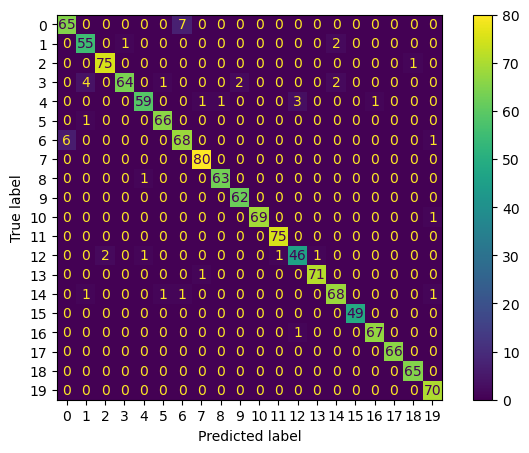

In [145]:
# Plot Confusion Matrix
plot_confusion_matrix(y_val_from_train, y_pred_from_train)

In [146]:
# Accuracy Score
accuracy_score(y_val_from_train, y_pred_from_train) # 96.44% currently

0.9651851851851851

In [147]:
cbc.get_feature_importance()

array([ 1.46490803,  2.50448668,  2.75001294,  0.70291076,  0.58583387,
        0.89275996,  1.09783418,  0.23141531,  0.18382331,  0.67490421,
        1.07500175,  3.3469231 ,  6.9892124 ,  1.57481907,  0.70216394,
        0.94286644,  4.50442706,  0.43921589,  0.26889048,  0.37532402,
        1.69377327,  0.93521402,  4.16115978,  0.69506816,  0.5917085 ,
        1.02925315,  3.98961115,  0.69323743,  0.31356852,  0.3666489 ,
        1.30475907,  1.55380528, 30.71744152,  7.85024852,  0.63197248,
        0.76845648,  0.96424105,  1.39861498,  3.63229012,  1.24814627,
        0.49510526,  1.11119856,  2.54674413])

In [90]:
preds = cbc.predict(X_test)
preds = [a[0] for a in preds]
preds

[3,
 4,
 5,
 20,
 5,
 13,
 9,
 4,
 5,
 3,
 16,
 9,
 2,
 8,
 17,
 15,
 19,
 5,
 7,
 18,
 17,
 18,
 12,
 7,
 16,
 18,
 8,
 2,
 16,
 3,
 16,
 6,
 10,
 9,
 4,
 3,
 6,
 20,
 5,
 1,
 5,
 10,
 3,
 3,
 1,
 3,
 18,
 18,
 10,
 20,
 17,
 3,
 7,
 2,
 3,
 12,
 16,
 16,
 8,
 17,
 15,
 4,
 17,
 13,
 9,
 13,
 20,
 8,
 4,
 15,
 14,
 20,
 16,
 9,
 12,
 8,
 8,
 6,
 18,
 9,
 17,
 8,
 17,
 8,
 11,
 12,
 19,
 12,
 5,
 17,
 17,
 16,
 18,
 5,
 11,
 1,
 10,
 5,
 5,
 11,
 8,
 16,
 17,
 20,
 14,
 17,
 3,
 17,
 16,
 3,
 17,
 5,
 2,
 8,
 5,
 11,
 12,
 3,
 20,
 10,
 9,
 14,
 20,
 15,
 9,
 5,
 16,
 18,
 17,
 17,
 20,
 1,
 12,
 11,
 2,
 15,
 2,
 5,
 11,
 18,
 8,
 15,
 2,
 19,
 9,
 12,
 20,
 4,
 19,
 4,
 10,
 13,
 16,
 10,
 14,
 14,
 10,
 5,
 7,
 8,
 4,
 20,
 12,
 13,
 3,
 1,
 13,
 2,
 19,
 6,
 19,
 18,
 12,
 2,
 12,
 5,
 10,
 15,
 20,
 14,
 1,
 19,
 9,
 4,
 14,
 15,
 10,
 17,
 4,
 17,
 6,
 15,
 14,
 14,
 18,
 11,
 13,
 9,
 18,
 7,
 17,
 5,
 8,
 10,
 20,
 14,
 4,
 14,
 20,
 17,
 19,
 18,
 5,
 19,
 18,
 20,
 20,
 9,
 9

In [91]:
sub = make_submission(preds)
sub

,id,class
0,10001,3
1,10002,4
2,10004,5
3,10008,20
4,10009,5
...,...,...
4995,23986,9
4996,23991,12
4997,23992,4
4998,23998,5


In [92]:
sub.to_csv('submission_catboost_baseline_64f.csv', index=False)

# Let's try for 75 features

In [63]:
# Load X_train
with open('X_train_75.npy', 'rb') as f:
    X_train = np.load(f)
print(X_train.shape)
X_train

(9000, 75)


array([[-8.81665000e-01,  1.04447100e+00,  1.59010940e-01, ...,
         7.64136797e-02,  2.23461397e-02,  1.29471645e+01],
       [-1.10552300e+00,  1.12647200e+00,  1.74547752e-01, ...,
         1.13979068e-01,  2.85805084e-02,  1.38184886e+01],
       [-2.64679000e+00,  3.47160000e-02, -1.61696002e+00, ...,
         7.77954261e-02,  3.10021816e-02,  1.33114980e+01],
       ...,
       [-1.56939900e+00,  8.21211000e-01, -4.06112460e-01, ...,
         1.29546035e-01,  3.10393141e-02,  1.38336216e+01],
       [-1.09474900e+00,  1.15340700e+00,  8.15228667e-03, ...,
         1.52495097e-01,  4.72684630e-02,  1.39800549e+01],
       [-1.13664700e+00,  8.64905000e-01, -5.17633651e-01, ...,
         5.24448737e-02,  3.02990790e-02,  1.37358806e+01]])

In [64]:
# Load y_train
with open('y_train.npy', 'rb') as f:
    y_train = np.load(f)
print(y_train.shape)
y_train

(9000,)


array([ 7, 13,  6, ...,  3,  3, 18], dtype=int64)

In [65]:
# Load X_test
with open('X_test_75.npy', 'rb') as f:
    X_test = np.load(f)
print(X_test.shape)
X_test

(5000, 75)


array([[-1.83755000e+00,  1.38265100e+00, -3.05412347e-01, ...,
         1.69465441e-01,  4.55106589e-02,  1.37640621e+01],
       [-1.74357700e+00,  1.61488900e+00, -3.54157081e-01, ...,
         9.01118934e-02,  3.03245873e-02,  1.29569175e+01],
       [-1.87047000e+00, -2.16077000e-01, -8.47212227e-01, ...,
         1.27677673e-01,  2.67303936e-02,  1.39464683e+01],
       ...,
       [-6.30872000e-01,  6.78756000e-01,  4.29758667e-03, ...,
         5.26696304e-02,  2.91492287e-02,  1.29786762e+01],
       [-2.13143800e+00,  4.72850000e-02, -1.05151830e+00, ...,
         7.00060125e-02,  2.16020454e-02,  1.42111488e+01],
       [-1.54605600e+00,  2.98677000e-01, -5.40031205e-01, ...,
         1.12113293e-01,  2.19392284e-02,  1.25388069e+01]])

In [66]:
# Create validation data
# Train/test sets
X_train_from_train, X_val_from_train, y_train_from_train, y_val_from_train = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42
)

## Let's try for 64 features, after removing redundant features

In [9]:
# Load X_train
with open('X_train_64.npy', 'rb') as f:
    X_train = np.load(f)
print(X_train.shape)
X_train

(9000, 64)


array([[-8.81665000e-01,  1.04447100e+00,  1.59010940e-01, ...,
         7.64136797e-02,  2.23461397e-02,  1.29471645e+01],
       [-1.10552300e+00,  1.12647200e+00,  1.74547752e-01, ...,
         1.13979068e-01,  2.85805084e-02,  1.38184886e+01],
       [-2.64679000e+00,  3.47160000e-02, -1.61696002e+00, ...,
         7.77954261e-02,  3.10021816e-02,  1.33114980e+01],
       ...,
       [-1.56939900e+00,  8.21211000e-01, -4.06112460e-01, ...,
         1.29546035e-01,  3.10393141e-02,  1.38336216e+01],
       [-1.09474900e+00,  1.15340700e+00,  8.15228667e-03, ...,
         1.52495097e-01,  4.72684630e-02,  1.39800549e+01],
       [-1.13664700e+00,  8.64905000e-01, -5.17633651e-01, ...,
         5.24448737e-02,  3.02990790e-02,  1.37358806e+01]])

In [10]:
# Load y_train
with open('y_train.npy', 'rb') as f:
    y_train = np.load(f)
print(y_train.shape)
y_train

(9000,)


array([ 7, 13,  6, ...,  3,  3, 18], dtype=int64)

In [11]:
# Load X_test
with open('X_test_64.npy', 'rb') as f:
    X_test = np.load(f)
print(X_test.shape)
X_test

(5000, 64)


array([[-1.83755000e+00,  1.38265100e+00, -3.05412347e-01, ...,
         1.69465441e-01,  4.55106589e-02,  1.37640621e+01],
       [-1.74357700e+00,  1.61488900e+00, -3.54157081e-01, ...,
         9.01118934e-02,  3.03245873e-02,  1.29569175e+01],
       [-1.87047000e+00, -2.16077000e-01, -8.47212227e-01, ...,
         1.27677673e-01,  2.67303936e-02,  1.39464683e+01],
       ...,
       [-6.30872000e-01,  6.78756000e-01,  4.29758667e-03, ...,
         5.26696304e-02,  2.91492287e-02,  1.29786762e+01],
       [-2.13143800e+00,  4.72850000e-02, -1.05151830e+00, ...,
         7.00060125e-02,  2.16020454e-02,  1.42111488e+01],
       [-1.54605600e+00,  2.98677000e-01, -5.40031205e-01, ...,
         1.12113293e-01,  2.19392284e-02,  1.25388069e+01]])

In [12]:
# Create validation data
# Train/test sets
X_train_from_train, X_val_from_train, y_train_from_train, y_val_from_train = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

## Let's try CV with Catboost

In [24]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
models = []

for i, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
    X_train_, y_train_ = X_train[train_index], y_train[train_index]
    X_valid_, y_valid_ = X_train[valid_index], y_train[valid_index]

    model = CatBoostClassifier(use_best_model=True, loss_function='MultiClass', task_type="GPU")
    model.fit(X_train_, y_train_, eval_set=(X_valid_, y_valid_))
    models.append(model)

Learning rate set to 0.128358
0:	learn: 2.0834827	test: 2.0961180	best: 2.0961180 (0)	total: 8.75ms	remaining: 8.74s
1:	learn: 1.7723687	test: 1.7848117	best: 1.7848117 (1)	total: 16ms	remaining: 7.99s
2:	learn: 1.5683308	test: 1.5844482	best: 1.5844482 (2)	total: 23.2ms	remaining: 7.71s
3:	learn: 1.4021086	test: 1.4208247	best: 1.4208247 (3)	total: 30.7ms	remaining: 7.63s
4:	learn: 1.2713296	test: 1.2956125	best: 1.2956125 (4)	total: 37.7ms	remaining: 7.5s
5:	learn: 1.1560103	test: 1.1844857	best: 1.1844857 (5)	total: 45.3ms	remaining: 7.5s
6:	learn: 1.0644486	test: 1.0955049	best: 1.0955049 (6)	total: 53ms	remaining: 7.52s
7:	learn: 0.9845839	test: 1.0161724	best: 1.0161724 (7)	total: 61.1ms	remaining: 7.57s
8:	learn: 0.9219017	test: 0.9545854	best: 0.9545854 (8)	total: 68.4ms	remaining: 7.53s
9:	learn: 0.8587574	test: 0.8938188	best: 0.8938188 (9)	total: 76.3ms	remaining: 7.55s
10:	learn: 0.8042700	test: 0.8403668	best: 0.8403668 (10)	total: 84.4ms	remaining: 7.59s
11:	learn: 0.7621

111:	learn: 0.1487107	test: 0.2334413	best: 0.2334413 (111)	total: 841ms	remaining: 6.67s
112:	learn: 0.1476070	test: 0.2326418	best: 0.2326418 (112)	total: 848ms	remaining: 6.66s
113:	learn: 0.1464900	test: 0.2319702	best: 0.2319702 (113)	total: 856ms	remaining: 6.66s
114:	learn: 0.1457627	test: 0.2317540	best: 0.2317540 (114)	total: 863ms	remaining: 6.64s
115:	learn: 0.1449796	test: 0.2312056	best: 0.2312056 (115)	total: 870ms	remaining: 6.63s
116:	learn: 0.1437421	test: 0.2305097	best: 0.2305097 (116)	total: 878ms	remaining: 6.62s
117:	learn: 0.1428640	test: 0.2297953	best: 0.2297953 (117)	total: 885ms	remaining: 6.61s
118:	learn: 0.1417569	test: 0.2284394	best: 0.2284394 (118)	total: 892ms	remaining: 6.61s
119:	learn: 0.1405974	test: 0.2273564	best: 0.2273564 (119)	total: 900ms	remaining: 6.6s
120:	learn: 0.1390215	test: 0.2257841	best: 0.2257841 (120)	total: 909ms	remaining: 6.6s
121:	learn: 0.1381829	test: 0.2249803	best: 0.2249803 (121)	total: 916ms	remaining: 6.59s
122:	learn: 

227:	learn: 0.0843756	test: 0.1823429	best: 0.1823429 (227)	total: 1.7s	remaining: 5.75s
228:	learn: 0.0840336	test: 0.1819339	best: 0.1819339 (228)	total: 1.71s	remaining: 5.74s
229:	learn: 0.0838463	test: 0.1817023	best: 0.1817023 (229)	total: 1.71s	remaining: 5.74s
230:	learn: 0.0835273	test: 0.1815237	best: 0.1815237 (230)	total: 1.72s	remaining: 5.73s
231:	learn: 0.0832777	test: 0.1809533	best: 0.1809533 (231)	total: 1.73s	remaining: 5.72s
232:	learn: 0.0830024	test: 0.1807371	best: 0.1807371 (232)	total: 1.73s	remaining: 5.71s
233:	learn: 0.0825807	test: 0.1804414	best: 0.1804414 (233)	total: 1.74s	remaining: 5.7s
234:	learn: 0.0822352	test: 0.1801596	best: 0.1801596 (234)	total: 1.75s	remaining: 5.69s
235:	learn: 0.0817756	test: 0.1797097	best: 0.1797097 (235)	total: 1.75s	remaining: 5.68s
236:	learn: 0.0815835	test: 0.1797243	best: 0.1797097 (235)	total: 1.76s	remaining: 5.68s
237:	learn: 0.0813630	test: 0.1795154	best: 0.1795154 (237)	total: 1.77s	remaining: 5.67s
238:	learn: 

342:	learn: 0.0532311	test: 0.1596881	best: 0.1596881 (342)	total: 2.55s	remaining: 4.89s
343:	learn: 0.0530841	test: 0.1595905	best: 0.1595905 (343)	total: 2.56s	remaining: 4.88s
344:	learn: 0.0528162	test: 0.1592328	best: 0.1592328 (344)	total: 2.57s	remaining: 4.87s
345:	learn: 0.0526180	test: 0.1591167	best: 0.1591167 (345)	total: 2.57s	remaining: 4.87s
346:	learn: 0.0524043	test: 0.1591110	best: 0.1591110 (346)	total: 2.58s	remaining: 4.86s
347:	learn: 0.0521331	test: 0.1590357	best: 0.1590357 (347)	total: 2.59s	remaining: 4.85s
348:	learn: 0.0519380	test: 0.1589512	best: 0.1589512 (348)	total: 2.6s	remaining: 4.84s
349:	learn: 0.0517522	test: 0.1587497	best: 0.1587497 (349)	total: 2.6s	remaining: 4.83s
350:	learn: 0.0516118	test: 0.1584589	best: 0.1584589 (350)	total: 2.61s	remaining: 4.83s
351:	learn: 0.0514316	test: 0.1583709	best: 0.1583709 (351)	total: 2.62s	remaining: 4.82s
352:	learn: 0.0513449	test: 0.1582743	best: 0.1582743 (352)	total: 2.63s	remaining: 4.81s
353:	learn: 

456:	learn: 0.0360974	test: 0.1478377	best: 0.1478377 (456)	total: 3.41s	remaining: 4.05s
457:	learn: 0.0360148	test: 0.1477688	best: 0.1477688 (457)	total: 3.42s	remaining: 4.05s
458:	learn: 0.0358268	test: 0.1476742	best: 0.1476742 (458)	total: 3.43s	remaining: 4.04s
459:	learn: 0.0357252	test: 0.1476272	best: 0.1476272 (459)	total: 3.44s	remaining: 4.03s
460:	learn: 0.0356629	test: 0.1474818	best: 0.1474818 (460)	total: 3.44s	remaining: 4.03s
461:	learn: 0.0355511	test: 0.1473570	best: 0.1473570 (461)	total: 3.45s	remaining: 4.02s
462:	learn: 0.0354270	test: 0.1473139	best: 0.1473139 (462)	total: 3.46s	remaining: 4.01s
463:	learn: 0.0352934	test: 0.1471847	best: 0.1471847 (463)	total: 3.46s	remaining: 4s
464:	learn: 0.0351855	test: 0.1470394	best: 0.1470394 (464)	total: 3.47s	remaining: 4s
465:	learn: 0.0351081	test: 0.1469405	best: 0.1469405 (465)	total: 3.48s	remaining: 3.99s
466:	learn: 0.0350388	test: 0.1468401	best: 0.1468401 (466)	total: 3.49s	remaining: 3.98s
467:	learn: 0.03

570:	learn: 0.0262727	test: 0.1396508	best: 0.1396508 (570)	total: 4.26s	remaining: 3.2s
571:	learn: 0.0262029	test: 0.1395154	best: 0.1395154 (571)	total: 4.27s	remaining: 3.2s
572:	learn: 0.0260907	test: 0.1394302	best: 0.1394302 (572)	total: 4.28s	remaining: 3.19s
573:	learn: 0.0260452	test: 0.1393986	best: 0.1393986 (573)	total: 4.29s	remaining: 3.18s
574:	learn: 0.0259791	test: 0.1393672	best: 0.1393672 (574)	total: 4.29s	remaining: 3.17s
575:	learn: 0.0259118	test: 0.1392449	best: 0.1392449 (575)	total: 4.3s	remaining: 3.17s
576:	learn: 0.0258475	test: 0.1391062	best: 0.1391062 (576)	total: 4.31s	remaining: 3.16s
577:	learn: 0.0257585	test: 0.1391285	best: 0.1391062 (576)	total: 4.32s	remaining: 3.15s
578:	learn: 0.0256989	test: 0.1390440	best: 0.1390440 (578)	total: 4.32s	remaining: 3.14s
579:	learn: 0.0256360	test: 0.1388896	best: 0.1388896 (579)	total: 4.33s	remaining: 3.14s
580:	learn: 0.0255377	test: 0.1389294	best: 0.1388896 (579)	total: 4.34s	remaining: 3.13s
581:	learn: 0

681:	learn: 0.0201411	test: 0.1339480	best: 0.1339480 (681)	total: 5.1s	remaining: 2.38s
682:	learn: 0.0201123	test: 0.1339555	best: 0.1339480 (681)	total: 5.11s	remaining: 2.37s
683:	learn: 0.0200716	test: 0.1339456	best: 0.1339456 (683)	total: 5.11s	remaining: 2.36s
684:	learn: 0.0200219	test: 0.1340270	best: 0.1339456 (683)	total: 5.12s	remaining: 2.35s
685:	learn: 0.0199702	test: 0.1340402	best: 0.1339456 (683)	total: 5.13s	remaining: 2.35s
686:	learn: 0.0199361	test: 0.1340660	best: 0.1339456 (683)	total: 5.14s	remaining: 2.34s
687:	learn: 0.0199027	test: 0.1339504	best: 0.1339456 (683)	total: 5.14s	remaining: 2.33s
688:	learn: 0.0198517	test: 0.1339228	best: 0.1339228 (688)	total: 5.15s	remaining: 2.33s
689:	learn: 0.0198023	test: 0.1338432	best: 0.1338432 (689)	total: 5.16s	remaining: 2.32s
690:	learn: 0.0197855	test: 0.1338364	best: 0.1338364 (690)	total: 5.17s	remaining: 2.31s
691:	learn: 0.0197391	test: 0.1337763	best: 0.1337763 (691)	total: 5.17s	remaining: 2.3s
692:	learn: 

791:	learn: 0.0164311	test: 0.1310759	best: 0.1310759 (791)	total: 5.95s	remaining: 1.56s
792:	learn: 0.0164015	test: 0.1309896	best: 0.1309896 (792)	total: 5.96s	remaining: 1.55s
793:	learn: 0.0163781	test: 0.1309144	best: 0.1309144 (793)	total: 5.96s	remaining: 1.55s
794:	learn: 0.0163413	test: 0.1308744	best: 0.1308744 (794)	total: 5.97s	remaining: 1.54s
795:	learn: 0.0163112	test: 0.1308040	best: 0.1308040 (795)	total: 5.98s	remaining: 1.53s
796:	learn: 0.0162857	test: 0.1307341	best: 0.1307341 (796)	total: 5.99s	remaining: 1.52s
797:	learn: 0.0162647	test: 0.1307776	best: 0.1307341 (796)	total: 5.99s	remaining: 1.52s
798:	learn: 0.0162312	test: 0.1307502	best: 0.1307341 (796)	total: 6s	remaining: 1.51s
799:	learn: 0.0162023	test: 0.1306808	best: 0.1306808 (799)	total: 6.01s	remaining: 1.5s
800:	learn: 0.0161779	test: 0.1306712	best: 0.1306712 (800)	total: 6.02s	remaining: 1.49s
801:	learn: 0.0161394	test: 0.1306278	best: 0.1306278 (801)	total: 6.02s	remaining: 1.49s
802:	learn: 0.

904:	learn: 0.0134672	test: 0.1281757	best: 0.1281757 (904)	total: 6.79s	remaining: 713ms
905:	learn: 0.0134461	test: 0.1282018	best: 0.1281757 (904)	total: 6.8s	remaining: 705ms
906:	learn: 0.0134318	test: 0.1281668	best: 0.1281668 (906)	total: 6.8s	remaining: 698ms
907:	learn: 0.0134134	test: 0.1281596	best: 0.1281596 (907)	total: 6.81s	remaining: 690ms
908:	learn: 0.0133921	test: 0.1281516	best: 0.1281516 (908)	total: 6.82s	remaining: 683ms
909:	learn: 0.0133699	test: 0.1281991	best: 0.1281516 (908)	total: 6.83s	remaining: 675ms
910:	learn: 0.0133507	test: 0.1281718	best: 0.1281516 (908)	total: 6.83s	remaining: 668ms
911:	learn: 0.0133290	test: 0.1281358	best: 0.1281358 (911)	total: 6.84s	remaining: 660ms
912:	learn: 0.0133054	test: 0.1280777	best: 0.1280777 (912)	total: 6.85s	remaining: 653ms
913:	learn: 0.0132772	test: 0.1280792	best: 0.1280777 (912)	total: 6.86s	remaining: 645ms
914:	learn: 0.0132546	test: 0.1280221	best: 0.1280221 (914)	total: 6.87s	remaining: 638ms
915:	learn: 

Learning rate set to 0.128358
0:	learn: 2.0946453	test: 2.0856965	best: 2.0856965 (0)	total: 8.63ms	remaining: 8.63s
1:	learn: 1.7987340	test: 1.7897940	best: 1.7897940 (1)	total: 15.6ms	remaining: 7.77s
2:	learn: 1.5886892	test: 1.5793759	best: 1.5793759 (2)	total: 22.8ms	remaining: 7.59s
3:	learn: 1.4057810	test: 1.3976402	best: 1.3976402 (3)	total: 29.9ms	remaining: 7.44s
4:	learn: 1.2685141	test: 1.2612963	best: 1.2612963 (4)	total: 37.2ms	remaining: 7.39s
5:	learn: 1.1506803	test: 1.1415157	best: 1.1415157 (5)	total: 44.8ms	remaining: 7.42s
6:	learn: 1.0680785	test: 1.0610893	best: 1.0610893 (6)	total: 52.6ms	remaining: 7.46s
7:	learn: 0.9834646	test: 0.9758596	best: 0.9758596 (7)	total: 60.5ms	remaining: 7.5s
8:	learn: 0.9149391	test: 0.9092945	best: 0.9092945 (8)	total: 68.3ms	remaining: 7.53s
9:	learn: 0.8567142	test: 0.8528649	best: 0.8528649 (9)	total: 76.1ms	remaining: 7.53s
10:	learn: 0.8033234	test: 0.8012964	best: 0.8012964 (10)	total: 83.4ms	remaining: 7.5s
11:	learn: 0.

107:	learn: 0.1462348	test: 0.1973513	best: 0.1973513 (107)	total: 834ms	remaining: 6.89s
108:	learn: 0.1455354	test: 0.1968576	best: 0.1968576 (108)	total: 841ms	remaining: 6.88s
109:	learn: 0.1442411	test: 0.1956871	best: 0.1956871 (109)	total: 848ms	remaining: 6.86s
110:	learn: 0.1431939	test: 0.1949458	best: 0.1949458 (110)	total: 856ms	remaining: 6.86s
111:	learn: 0.1423174	test: 0.1946447	best: 0.1946447 (111)	total: 863ms	remaining: 6.84s
112:	learn: 0.1417332	test: 0.1942748	best: 0.1942748 (112)	total: 870ms	remaining: 6.83s
113:	learn: 0.1407898	test: 0.1936083	best: 0.1936083 (113)	total: 877ms	remaining: 6.82s
114:	learn: 0.1393867	test: 0.1927284	best: 0.1927284 (114)	total: 886ms	remaining: 6.82s
115:	learn: 0.1384238	test: 0.1922842	best: 0.1922842 (115)	total: 894ms	remaining: 6.81s
116:	learn: 0.1374760	test: 0.1914265	best: 0.1914265 (116)	total: 901ms	remaining: 6.8s
117:	learn: 0.1369258	test: 0.1909694	best: 0.1909694 (117)	total: 908ms	remaining: 6.79s
118:	learn:

222:	learn: 0.0791224	test: 0.1519304	best: 0.1519304 (222)	total: 1.69s	remaining: 5.88s
223:	learn: 0.0787217	test: 0.1518070	best: 0.1518070 (223)	total: 1.7s	remaining: 5.87s
224:	learn: 0.0784296	test: 0.1516447	best: 0.1516447 (224)	total: 1.7s	remaining: 5.87s
225:	learn: 0.0780016	test: 0.1513995	best: 0.1513995 (225)	total: 1.71s	remaining: 5.86s
226:	learn: 0.0775990	test: 0.1511235	best: 0.1511235 (226)	total: 1.72s	remaining: 5.85s
227:	learn: 0.0773585	test: 0.1509115	best: 0.1509115 (227)	total: 1.72s	remaining: 5.84s
228:	learn: 0.0769616	test: 0.1506567	best: 0.1506567 (228)	total: 1.73s	remaining: 5.83s
229:	learn: 0.0768302	test: 0.1506164	best: 0.1506164 (229)	total: 1.74s	remaining: 5.82s
230:	learn: 0.0765542	test: 0.1505779	best: 0.1505779 (230)	total: 1.75s	remaining: 5.82s
231:	learn: 0.0763561	test: 0.1504917	best: 0.1504917 (231)	total: 1.75s	remaining: 5.81s
232:	learn: 0.0760989	test: 0.1503374	best: 0.1503374 (232)	total: 1.76s	remaining: 5.8s
233:	learn: 0

333:	learn: 0.0513703	test: 0.1352783	best: 0.1352783 (333)	total: 2.53s	remaining: 5.05s
334:	learn: 0.0511168	test: 0.1351724	best: 0.1351724 (334)	total: 2.54s	remaining: 5.05s
335:	learn: 0.0510597	test: 0.1350793	best: 0.1350793 (335)	total: 2.55s	remaining: 5.04s
336:	learn: 0.0507964	test: 0.1351307	best: 0.1350793 (335)	total: 2.56s	remaining: 5.03s
337:	learn: 0.0506442	test: 0.1349852	best: 0.1349852 (337)	total: 2.56s	remaining: 5.02s
338:	learn: 0.0505084	test: 0.1347879	best: 0.1347879 (338)	total: 2.57s	remaining: 5.01s
339:	learn: 0.0503556	test: 0.1345920	best: 0.1345920 (339)	total: 2.58s	remaining: 5.01s
340:	learn: 0.0501233	test: 0.1342964	best: 0.1342964 (340)	total: 2.59s	remaining: 5s
341:	learn: 0.0498577	test: 0.1340256	best: 0.1340256 (341)	total: 2.59s	remaining: 4.99s
342:	learn: 0.0497110	test: 0.1339050	best: 0.1339050 (342)	total: 2.6s	remaining: 4.99s
343:	learn: 0.0495928	test: 0.1337558	best: 0.1337558 (343)	total: 2.61s	remaining: 4.98s
344:	learn: 0.

446:	learn: 0.0354439	test: 0.1233959	best: 0.1233959 (446)	total: 3.39s	remaining: 4.19s
447:	learn: 0.0353503	test: 0.1233216	best: 0.1233216 (447)	total: 3.39s	remaining: 4.18s
448:	learn: 0.0352480	test: 0.1232326	best: 0.1232326 (448)	total: 3.4s	remaining: 4.17s
449:	learn: 0.0351056	test: 0.1231167	best: 0.1231167 (449)	total: 3.41s	remaining: 4.17s
450:	learn: 0.0349845	test: 0.1229931	best: 0.1229931 (450)	total: 3.42s	remaining: 4.16s
451:	learn: 0.0349231	test: 0.1228716	best: 0.1228716 (451)	total: 3.42s	remaining: 4.15s
452:	learn: 0.0348787	test: 0.1228176	best: 0.1228176 (452)	total: 3.43s	remaining: 4.14s
453:	learn: 0.0347367	test: 0.1225889	best: 0.1225889 (453)	total: 3.44s	remaining: 4.13s
454:	learn: 0.0346032	test: 0.1225112	best: 0.1225112 (454)	total: 3.45s	remaining: 4.13s
455:	learn: 0.0345637	test: 0.1225001	best: 0.1225001 (455)	total: 3.45s	remaining: 4.12s
456:	learn: 0.0345090	test: 0.1225262	best: 0.1225001 (455)	total: 3.46s	remaining: 4.11s
457:	learn:

558:	learn: 0.0259690	test: 0.1163768	best: 0.1163768 (558)	total: 4.23s	remaining: 3.34s
559:	learn: 0.0258808	test: 0.1162885	best: 0.1162885 (559)	total: 4.24s	remaining: 3.33s
560:	learn: 0.0258381	test: 0.1162440	best: 0.1162440 (560)	total: 4.25s	remaining: 3.32s
561:	learn: 0.0257601	test: 0.1162046	best: 0.1162046 (561)	total: 4.25s	remaining: 3.31s
562:	learn: 0.0257017	test: 0.1162126	best: 0.1162046 (561)	total: 4.26s	remaining: 3.31s
563:	learn: 0.0256465	test: 0.1161581	best: 0.1161581 (563)	total: 4.27s	remaining: 3.3s
564:	learn: 0.0255667	test: 0.1161090	best: 0.1161090 (564)	total: 4.28s	remaining: 3.29s
565:	learn: 0.0254990	test: 0.1160628	best: 0.1160628 (565)	total: 4.28s	remaining: 3.29s
566:	learn: 0.0254567	test: 0.1159415	best: 0.1159415 (566)	total: 4.29s	remaining: 3.28s
567:	learn: 0.0254008	test: 0.1159188	best: 0.1159188 (567)	total: 4.3s	remaining: 3.27s
568:	learn: 0.0253237	test: 0.1159354	best: 0.1159188 (567)	total: 4.31s	remaining: 3.26s
569:	learn: 

669:	learn: 0.0201208	test: 0.1117197	best: 0.1117197 (669)	total: 5.09s	remaining: 2.51s
670:	learn: 0.0200955	test: 0.1116670	best: 0.1116670 (670)	total: 5.1s	remaining: 2.5s
671:	learn: 0.0200734	test: 0.1116144	best: 0.1116144 (671)	total: 5.11s	remaining: 2.49s
672:	learn: 0.0200430	test: 0.1116311	best: 0.1116144 (671)	total: 5.11s	remaining: 2.48s
673:	learn: 0.0199876	test: 0.1114893	best: 0.1114893 (673)	total: 5.12s	remaining: 2.48s
674:	learn: 0.0199537	test: 0.1114606	best: 0.1114606 (674)	total: 5.13s	remaining: 2.47s
675:	learn: 0.0199214	test: 0.1114117	best: 0.1114117 (675)	total: 5.14s	remaining: 2.46s
676:	learn: 0.0198941	test: 0.1113744	best: 0.1113744 (676)	total: 5.14s	remaining: 2.45s
677:	learn: 0.0198463	test: 0.1113543	best: 0.1113543 (677)	total: 5.15s	remaining: 2.45s
678:	learn: 0.0198023	test: 0.1113690	best: 0.1113543 (677)	total: 5.16s	remaining: 2.44s
679:	learn: 0.0197791	test: 0.1113466	best: 0.1113466 (679)	total: 5.17s	remaining: 2.43s
680:	learn: 

781:	learn: 0.0160898	test: 0.1084659	best: 0.1084659 (781)	total: 5.93s	remaining: 1.65s
782:	learn: 0.0160578	test: 0.1084712	best: 0.1084659 (781)	total: 5.93s	remaining: 1.64s
783:	learn: 0.0160283	test: 0.1084958	best: 0.1084659 (781)	total: 5.94s	remaining: 1.64s
784:	learn: 0.0160091	test: 0.1084374	best: 0.1084374 (784)	total: 5.95s	remaining: 1.63s
785:	learn: 0.0159626	test: 0.1083811	best: 0.1083811 (785)	total: 5.96s	remaining: 1.62s
786:	learn: 0.0159320	test: 0.1084099	best: 0.1083811 (785)	total: 5.96s	remaining: 1.61s
787:	learn: 0.0158933	test: 0.1084518	best: 0.1083811 (785)	total: 5.97s	remaining: 1.61s
788:	learn: 0.0158608	test: 0.1084637	best: 0.1083811 (785)	total: 5.98s	remaining: 1.6s
789:	learn: 0.0158353	test: 0.1084545	best: 0.1083811 (785)	total: 5.99s	remaining: 1.59s
790:	learn: 0.0158154	test: 0.1084516	best: 0.1083811 (785)	total: 6s	remaining: 1.58s
791:	learn: 0.0157680	test: 0.1083363	best: 0.1083363 (791)	total: 6s	remaining: 1.58s
792:	learn: 0.015

892:	learn: 0.0133581	test: 0.1069767	best: 0.1069767 (892)	total: 6.78s	remaining: 812ms
893:	learn: 0.0133365	test: 0.1069817	best: 0.1069767 (892)	total: 6.79s	remaining: 805ms
894:	learn: 0.0133109	test: 0.1070138	best: 0.1069767 (892)	total: 6.79s	remaining: 797ms
895:	learn: 0.0132826	test: 0.1069520	best: 0.1069520 (895)	total: 6.8s	remaining: 790ms
896:	learn: 0.0132615	test: 0.1069557	best: 0.1069520 (895)	total: 6.81s	remaining: 782ms
897:	learn: 0.0132480	test: 0.1070040	best: 0.1069520 (895)	total: 6.82s	remaining: 774ms
898:	learn: 0.0132231	test: 0.1069472	best: 0.1069472 (898)	total: 6.82s	remaining: 767ms
899:	learn: 0.0132049	test: 0.1069386	best: 0.1069386 (899)	total: 6.83s	remaining: 759ms
900:	learn: 0.0131886	test: 0.1069020	best: 0.1069020 (900)	total: 6.84s	remaining: 752ms
901:	learn: 0.0131562	test: 0.1068497	best: 0.1068497 (901)	total: 6.85s	remaining: 744ms
902:	learn: 0.0131256	test: 0.1068190	best: 0.1068190 (902)	total: 6.85s	remaining: 736ms
903:	learn:

Learning rate set to 0.128358
0:	learn: 2.0833347	test: 2.0857751	best: 2.0857751 (0)	total: 8.43ms	remaining: 8.42s
1:	learn: 1.7747190	test: 1.7833554	best: 1.7833554 (1)	total: 15.6ms	remaining: 7.77s
2:	learn: 1.5756626	test: 1.5873052	best: 1.5873052 (2)	total: 22.7ms	remaining: 7.53s
3:	learn: 1.4060550	test: 1.4195920	best: 1.4195920 (3)	total: 29.9ms	remaining: 7.44s
4:	learn: 1.2659549	test: 1.2854145	best: 1.2854145 (4)	total: 37.4ms	remaining: 7.43s
5:	learn: 1.1568155	test: 1.1791157	best: 1.1791157 (5)	total: 44.9ms	remaining: 7.45s
6:	learn: 1.0638160	test: 1.0888581	best: 1.0888581 (6)	total: 52.2ms	remaining: 7.41s
7:	learn: 0.9813331	test: 1.0058804	best: 1.0058804 (7)	total: 59.6ms	remaining: 7.4s
8:	learn: 0.9094011	test: 0.9347758	best: 0.9347758 (8)	total: 67.3ms	remaining: 7.41s
9:	learn: 0.8484219	test: 0.8745624	best: 0.8745624 (9)	total: 75.2ms	remaining: 7.44s
10:	learn: 0.7982244	test: 0.8245264	best: 0.8245264 (10)	total: 83ms	remaining: 7.46s
11:	learn: 0.7

107:	learn: 0.1392623	test: 0.2188303	best: 0.2188303 (107)	total: 820ms	remaining: 6.77s
108:	learn: 0.1384400	test: 0.2182803	best: 0.2182803 (108)	total: 827ms	remaining: 6.76s
109:	learn: 0.1376565	test: 0.2176870	best: 0.2176870 (109)	total: 834ms	remaining: 6.75s
110:	learn: 0.1368576	test: 0.2172274	best: 0.2172274 (110)	total: 841ms	remaining: 6.74s
111:	learn: 0.1360232	test: 0.2164261	best: 0.2164261 (111)	total: 848ms	remaining: 6.72s
112:	learn: 0.1347704	test: 0.2152232	best: 0.2152232 (112)	total: 856ms	remaining: 6.71s
113:	learn: 0.1338249	test: 0.2146898	best: 0.2146898 (113)	total: 863ms	remaining: 6.71s
114:	learn: 0.1332740	test: 0.2141217	best: 0.2141217 (114)	total: 870ms	remaining: 6.7s
115:	learn: 0.1323817	test: 0.2135460	best: 0.2135460 (115)	total: 878ms	remaining: 6.69s
116:	learn: 0.1314912	test: 0.2131226	best: 0.2131226 (116)	total: 886ms	remaining: 6.68s
117:	learn: 0.1308561	test: 0.2125156	best: 0.2125156 (117)	total: 893ms	remaining: 6.67s
118:	learn:

224:	learn: 0.0766546	test: 0.1745287	best: 0.1745287 (224)	total: 1.68s	remaining: 5.78s
225:	learn: 0.0762629	test: 0.1744314	best: 0.1744314 (225)	total: 1.69s	remaining: 5.78s
226:	learn: 0.0759755	test: 0.1742651	best: 0.1742651 (226)	total: 1.69s	remaining: 5.77s
227:	learn: 0.0755225	test: 0.1741080	best: 0.1741080 (227)	total: 1.7s	remaining: 5.76s
228:	learn: 0.0751148	test: 0.1739025	best: 0.1739025 (228)	total: 1.71s	remaining: 5.75s
229:	learn: 0.0748795	test: 0.1737744	best: 0.1737744 (229)	total: 1.72s	remaining: 5.74s
230:	learn: 0.0745066	test: 0.1736174	best: 0.1736174 (230)	total: 1.72s	remaining: 5.74s
231:	learn: 0.0743556	test: 0.1734016	best: 0.1734016 (231)	total: 1.73s	remaining: 5.73s
232:	learn: 0.0738414	test: 0.1728284	best: 0.1728284 (232)	total: 1.74s	remaining: 5.72s
233:	learn: 0.0736015	test: 0.1725484	best: 0.1725484 (233)	total: 1.75s	remaining: 5.71s
234:	learn: 0.0731883	test: 0.1724002	best: 0.1724002 (234)	total: 1.75s	remaining: 5.71s
235:	learn:

338:	learn: 0.0485949	test: 0.1586762	best: 0.1586762 (338)	total: 2.54s	remaining: 4.96s
339:	learn: 0.0483723	test: 0.1586762	best: 0.1586762 (338)	total: 2.55s	remaining: 4.95s
340:	learn: 0.0482116	test: 0.1586365	best: 0.1586365 (340)	total: 2.56s	remaining: 4.94s
341:	learn: 0.0479379	test: 0.1585767	best: 0.1585767 (341)	total: 2.56s	remaining: 4.93s
342:	learn: 0.0475904	test: 0.1584926	best: 0.1584926 (342)	total: 2.57s	remaining: 4.93s
343:	learn: 0.0474510	test: 0.1583754	best: 0.1583754 (343)	total: 2.58s	remaining: 4.92s
344:	learn: 0.0473076	test: 0.1582908	best: 0.1582908 (344)	total: 2.59s	remaining: 4.92s
345:	learn: 0.0469286	test: 0.1582428	best: 0.1582428 (345)	total: 2.6s	remaining: 4.91s
346:	learn: 0.0467826	test: 0.1581839	best: 0.1581839 (346)	total: 2.6s	remaining: 4.9s
347:	learn: 0.0465116	test: 0.1581272	best: 0.1581272 (347)	total: 2.61s	remaining: 4.9s
348:	learn: 0.0463877	test: 0.1580129	best: 0.1580129 (348)	total: 2.62s	remaining: 4.89s
349:	learn: 0.

451:	learn: 0.0330011	test: 0.1513509	best: 0.1510403 (446)	total: 3.39s	remaining: 4.11s
452:	learn: 0.0328699	test: 0.1512861	best: 0.1510403 (446)	total: 3.4s	remaining: 4.11s
453:	learn: 0.0327318	test: 0.1510320	best: 0.1510320 (453)	total: 3.41s	remaining: 4.1s
454:	learn: 0.0326808	test: 0.1509007	best: 0.1509007 (454)	total: 3.42s	remaining: 4.09s
455:	learn: 0.0325546	test: 0.1508822	best: 0.1508822 (455)	total: 3.42s	remaining: 4.08s
456:	learn: 0.0324188	test: 0.1508337	best: 0.1508337 (456)	total: 3.43s	remaining: 4.08s
457:	learn: 0.0323331	test: 0.1506893	best: 0.1506893 (457)	total: 3.44s	remaining: 4.07s
458:	learn: 0.0321943	test: 0.1507197	best: 0.1506893 (457)	total: 3.44s	remaining: 4.06s
459:	learn: 0.0320924	test: 0.1507246	best: 0.1506893 (457)	total: 3.45s	remaining: 4.05s
460:	learn: 0.0320109	test: 0.1506481	best: 0.1506481 (460)	total: 3.46s	remaining: 4.04s
461:	learn: 0.0319106	test: 0.1505788	best: 0.1505788 (461)	total: 3.47s	remaining: 4.04s
462:	learn: 

561:	learn: 0.0246587	test: 0.1462798	best: 0.1462798 (561)	total: 4.24s	remaining: 3.3s
562:	learn: 0.0246128	test: 0.1461813	best: 0.1461813 (562)	total: 4.24s	remaining: 3.29s
563:	learn: 0.0245620	test: 0.1461205	best: 0.1461205 (563)	total: 4.25s	remaining: 3.29s
564:	learn: 0.0244868	test: 0.1460944	best: 0.1460944 (564)	total: 4.26s	remaining: 3.28s
565:	learn: 0.0244379	test: 0.1460471	best: 0.1460471 (565)	total: 4.27s	remaining: 3.27s
566:	learn: 0.0243880	test: 0.1459361	best: 0.1459361 (566)	total: 4.27s	remaining: 3.26s
567:	learn: 0.0243304	test: 0.1459343	best: 0.1459343 (567)	total: 4.28s	remaining: 3.26s
568:	learn: 0.0242844	test: 0.1458706	best: 0.1458706 (568)	total: 4.29s	remaining: 3.25s
569:	learn: 0.0242323	test: 0.1458931	best: 0.1458706 (568)	total: 4.3s	remaining: 3.24s
570:	learn: 0.0241850	test: 0.1458137	best: 0.1458137 (570)	total: 4.3s	remaining: 3.23s
571:	learn: 0.0241567	test: 0.1457780	best: 0.1457780 (571)	total: 4.31s	remaining: 3.23s
572:	learn: 0

675:	learn: 0.0191246	test: 0.1445661	best: 0.1443025 (668)	total: 5.1s	remaining: 2.44s
676:	learn: 0.0190790	test: 0.1444607	best: 0.1443025 (668)	total: 5.1s	remaining: 2.44s
677:	learn: 0.0190360	test: 0.1444528	best: 0.1443025 (668)	total: 5.11s	remaining: 2.43s
678:	learn: 0.0189895	test: 0.1444612	best: 0.1443025 (668)	total: 5.12s	remaining: 2.42s
679:	learn: 0.0189466	test: 0.1443846	best: 0.1443025 (668)	total: 5.13s	remaining: 2.41s
680:	learn: 0.0188967	test: 0.1444197	best: 0.1443025 (668)	total: 5.13s	remaining: 2.4s
681:	learn: 0.0188684	test: 0.1443475	best: 0.1443025 (668)	total: 5.14s	remaining: 2.4s
682:	learn: 0.0188394	test: 0.1442585	best: 0.1442585 (682)	total: 5.15s	remaining: 2.39s
683:	learn: 0.0188140	test: 0.1442747	best: 0.1442585 (682)	total: 5.16s	remaining: 2.38s
684:	learn: 0.0187742	test: 0.1442426	best: 0.1442426 (684)	total: 5.16s	remaining: 2.37s
685:	learn: 0.0187350	test: 0.1441660	best: 0.1441660 (685)	total: 5.17s	remaining: 2.37s
686:	learn: 0.

786:	learn: 0.0153291	test: 0.1424145	best: 0.1423436 (777)	total: 5.94s	remaining: 1.61s
787:	learn: 0.0153073	test: 0.1424260	best: 0.1423436 (777)	total: 5.95s	remaining: 1.6s
788:	learn: 0.0152954	test: 0.1423803	best: 0.1423436 (777)	total: 5.95s	remaining: 1.59s
789:	learn: 0.0152857	test: 0.1423670	best: 0.1423436 (777)	total: 5.96s	remaining: 1.58s
790:	learn: 0.0152252	test: 0.1423439	best: 0.1423436 (777)	total: 5.97s	remaining: 1.58s
791:	learn: 0.0152043	test: 0.1423751	best: 0.1423436 (777)	total: 5.98s	remaining: 1.57s
792:	learn: 0.0151828	test: 0.1424102	best: 0.1423436 (777)	total: 5.98s	remaining: 1.56s
793:	learn: 0.0151666	test: 0.1424374	best: 0.1423436 (777)	total: 5.99s	remaining: 1.55s
794:	learn: 0.0151420	test: 0.1424900	best: 0.1423436 (777)	total: 6s	remaining: 1.55s
795:	learn: 0.0150928	test: 0.1423981	best: 0.1423436 (777)	total: 6.01s	remaining: 1.54s
796:	learn: 0.0150676	test: 0.1423605	best: 0.1423436 (777)	total: 6.01s	remaining: 1.53s
797:	learn: 0.

899:	learn: 0.0126556	test: 0.1416711	best: 0.1416651 (884)	total: 6.79s	remaining: 754ms
900:	learn: 0.0126299	test: 0.1415745	best: 0.1415745 (900)	total: 6.8s	remaining: 747ms
901:	learn: 0.0126132	test: 0.1416443	best: 0.1415745 (900)	total: 6.8s	remaining: 739ms
902:	learn: 0.0126065	test: 0.1416395	best: 0.1415745 (900)	total: 6.81s	remaining: 732ms
903:	learn: 0.0125757	test: 0.1415024	best: 0.1415024 (903)	total: 6.82s	remaining: 724ms
904:	learn: 0.0125610	test: 0.1414907	best: 0.1414907 (904)	total: 6.82s	remaining: 716ms
905:	learn: 0.0125440	test: 0.1415100	best: 0.1414907 (904)	total: 6.83s	remaining: 709ms
906:	learn: 0.0125358	test: 0.1414994	best: 0.1414907 (904)	total: 6.84s	remaining: 701ms
907:	learn: 0.0125002	test: 0.1414968	best: 0.1414907 (904)	total: 6.85s	remaining: 694ms
908:	learn: 0.0124907	test: 0.1415060	best: 0.1414907 (904)	total: 6.85s	remaining: 686ms
909:	learn: 0.0124625	test: 0.1414528	best: 0.1414528 (909)	total: 6.86s	remaining: 679ms
910:	learn: 

Learning rate set to 0.128358
0:	learn: 2.0784702	test: 2.1037505	best: 2.1037505 (0)	total: 8.15ms	remaining: 8.15s
1:	learn: 1.7825643	test: 1.8096851	best: 1.8096851 (1)	total: 15.5ms	remaining: 7.76s
2:	learn: 1.5861228	test: 1.6122205	best: 1.6122205 (2)	total: 24.7ms	remaining: 8.2s
3:	learn: 1.4149053	test: 1.4415526	best: 1.4415526 (3)	total: 31.6ms	remaining: 7.87s
4:	learn: 1.2718312	test: 1.2986407	best: 1.2986407 (4)	total: 38.9ms	remaining: 7.74s
5:	learn: 1.1515431	test: 1.1751263	best: 1.1751263 (5)	total: 46.6ms	remaining: 7.73s
6:	learn: 1.0615390	test: 1.0847530	best: 1.0847530 (6)	total: 54.1ms	remaining: 7.68s
7:	learn: 0.9789861	test: 1.0058312	best: 1.0058312 (7)	total: 61.8ms	remaining: 7.66s
8:	learn: 0.9109453	test: 0.9360300	best: 0.9360300 (8)	total: 69.6ms	remaining: 7.67s
9:	learn: 0.8576454	test: 0.8840234	best: 0.8840234 (9)	total: 77.5ms	remaining: 7.67s
10:	learn: 0.8042775	test: 0.8318127	best: 0.8318127 (10)	total: 85.4ms	remaining: 7.68s
11:	learn: 0

106:	learn: 0.1461677	test: 0.2097189	best: 0.2097189 (106)	total: 828ms	remaining: 6.91s
107:	learn: 0.1457010	test: 0.2094548	best: 0.2094548 (107)	total: 835ms	remaining: 6.9s
108:	learn: 0.1450150	test: 0.2087523	best: 0.2087523 (108)	total: 843ms	remaining: 6.89s
109:	learn: 0.1439858	test: 0.2082481	best: 0.2082481 (109)	total: 850ms	remaining: 6.88s
110:	learn: 0.1432789	test: 0.2074865	best: 0.2074865 (110)	total: 858ms	remaining: 6.87s
111:	learn: 0.1424512	test: 0.2068966	best: 0.2068966 (111)	total: 865ms	remaining: 6.86s
112:	learn: 0.1409879	test: 0.2060040	best: 0.2060040 (112)	total: 872ms	remaining: 6.85s
113:	learn: 0.1397855	test: 0.2051028	best: 0.2051028 (113)	total: 880ms	remaining: 6.84s
114:	learn: 0.1388787	test: 0.2045964	best: 0.2045964 (114)	total: 887ms	remaining: 6.83s
115:	learn: 0.1380404	test: 0.2038913	best: 0.2038913 (115)	total: 895ms	remaining: 6.82s
116:	learn: 0.1369525	test: 0.2031495	best: 0.2031495 (116)	total: 903ms	remaining: 6.81s
117:	learn:

220:	learn: 0.0772793	test: 0.1564110	best: 0.1564110 (220)	total: 1.68s	remaining: 5.92s
221:	learn: 0.0767787	test: 0.1562572	best: 0.1562572 (221)	total: 1.69s	remaining: 5.91s
222:	learn: 0.0766078	test: 0.1560365	best: 0.1560365 (222)	total: 1.7s	remaining: 5.91s
223:	learn: 0.0764661	test: 0.1559015	best: 0.1559015 (223)	total: 1.7s	remaining: 5.9s
224:	learn: 0.0761135	test: 0.1559002	best: 0.1559002 (224)	total: 1.71s	remaining: 5.89s
225:	learn: 0.0759812	test: 0.1557316	best: 0.1557316 (225)	total: 1.72s	remaining: 5.88s
226:	learn: 0.0758167	test: 0.1555402	best: 0.1555402 (226)	total: 1.72s	remaining: 5.87s
227:	learn: 0.0755383	test: 0.1551140	best: 0.1551140 (227)	total: 1.73s	remaining: 5.86s
228:	learn: 0.0752809	test: 0.1548481	best: 0.1548481 (228)	total: 1.74s	remaining: 5.86s
229:	learn: 0.0748933	test: 0.1545264	best: 0.1545264 (229)	total: 1.75s	remaining: 5.85s
230:	learn: 0.0746761	test: 0.1542407	best: 0.1542407 (230)	total: 1.75s	remaining: 5.84s
231:	learn: 0

334:	learn: 0.0485021	test: 0.1349565	best: 0.1349565 (334)	total: 2.54s	remaining: 5.04s
335:	learn: 0.0482733	test: 0.1349111	best: 0.1349111 (335)	total: 2.55s	remaining: 5.03s
336:	learn: 0.0480777	test: 0.1347330	best: 0.1347330 (336)	total: 2.55s	remaining: 5.03s
337:	learn: 0.0478733	test: 0.1344777	best: 0.1344777 (337)	total: 2.56s	remaining: 5.02s
338:	learn: 0.0477729	test: 0.1343905	best: 0.1343905 (338)	total: 2.57s	remaining: 5.01s
339:	learn: 0.0476710	test: 0.1342402	best: 0.1342402 (339)	total: 2.58s	remaining: 5s
340:	learn: 0.0474189	test: 0.1339197	best: 0.1339197 (340)	total: 2.58s	remaining: 5s
341:	learn: 0.0472431	test: 0.1337935	best: 0.1337935 (341)	total: 2.59s	remaining: 4.99s
342:	learn: 0.0471567	test: 0.1337519	best: 0.1337519 (342)	total: 2.6s	remaining: 4.98s
343:	learn: 0.0469363	test: 0.1334803	best: 0.1334803 (343)	total: 2.61s	remaining: 4.97s
344:	learn: 0.0468005	test: 0.1333008	best: 0.1333008 (344)	total: 2.61s	remaining: 4.96s
345:	learn: 0.046

446:	learn: 0.0337375	test: 0.1231099	best: 0.1231099 (446)	total: 3.39s	remaining: 4.2s
447:	learn: 0.0336398	test: 0.1230408	best: 0.1230408 (447)	total: 3.4s	remaining: 4.19s
448:	learn: 0.0335276	test: 0.1228869	best: 0.1228869 (448)	total: 3.41s	remaining: 4.18s
449:	learn: 0.0334312	test: 0.1227627	best: 0.1227627 (449)	total: 3.42s	remaining: 4.17s
450:	learn: 0.0333034	test: 0.1225329	best: 0.1225329 (450)	total: 3.42s	remaining: 4.17s
451:	learn: 0.0332601	test: 0.1224974	best: 0.1224974 (451)	total: 3.43s	remaining: 4.16s
452:	learn: 0.0331014	test: 0.1224566	best: 0.1224566 (452)	total: 3.44s	remaining: 4.15s
453:	learn: 0.0330341	test: 0.1224571	best: 0.1224566 (452)	total: 3.45s	remaining: 4.15s
454:	learn: 0.0329021	test: 0.1223473	best: 0.1223473 (454)	total: 3.46s	remaining: 4.14s
455:	learn: 0.0327955	test: 0.1221862	best: 0.1221862 (455)	total: 3.46s	remaining: 4.13s
456:	learn: 0.0327165	test: 0.1221142	best: 0.1221142 (456)	total: 3.47s	remaining: 4.13s
457:	learn: 

557:	learn: 0.0249571	test: 0.1163336	best: 0.1162721 (556)	total: 4.25s	remaining: 3.37s
558:	learn: 0.0249101	test: 0.1162572	best: 0.1162572 (558)	total: 4.26s	remaining: 3.36s
559:	learn: 0.0248629	test: 0.1162316	best: 0.1162316 (559)	total: 4.27s	remaining: 3.35s
560:	learn: 0.0247909	test: 0.1161676	best: 0.1161676 (560)	total: 4.28s	remaining: 3.35s
561:	learn: 0.0247096	test: 0.1160973	best: 0.1160973 (561)	total: 4.28s	remaining: 3.34s
562:	learn: 0.0246614	test: 0.1160871	best: 0.1160871 (562)	total: 4.29s	remaining: 3.33s
563:	learn: 0.0245505	test: 0.1160347	best: 0.1160347 (563)	total: 4.3s	remaining: 3.32s
564:	learn: 0.0245049	test: 0.1160419	best: 0.1160347 (563)	total: 4.31s	remaining: 3.31s
565:	learn: 0.0244223	test: 0.1161210	best: 0.1160347 (563)	total: 4.31s	remaining: 3.31s
566:	learn: 0.0243604	test: 0.1160829	best: 0.1160347 (563)	total: 4.32s	remaining: 3.3s
567:	learn: 0.0243171	test: 0.1161313	best: 0.1160347 (563)	total: 4.33s	remaining: 3.29s
568:	learn: 

667:	learn: 0.0191501	test: 0.1109753	best: 0.1109753 (667)	total: 5.1s	remaining: 2.54s
668:	learn: 0.0191341	test: 0.1109725	best: 0.1109725 (668)	total: 5.11s	remaining: 2.53s
669:	learn: 0.0191043	test: 0.1109141	best: 0.1109141 (669)	total: 5.12s	remaining: 2.52s
670:	learn: 0.0190646	test: 0.1109026	best: 0.1109026 (670)	total: 5.13s	remaining: 2.51s
671:	learn: 0.0190106	test: 0.1108174	best: 0.1108174 (671)	total: 5.13s	remaining: 2.51s
672:	learn: 0.0189547	test: 0.1108153	best: 0.1108153 (672)	total: 5.14s	remaining: 2.5s
673:	learn: 0.0189374	test: 0.1108164	best: 0.1108153 (672)	total: 5.15s	remaining: 2.49s
674:	learn: 0.0188743	test: 0.1106883	best: 0.1106883 (674)	total: 5.16s	remaining: 2.48s
675:	learn: 0.0188533	test: 0.1106455	best: 0.1106455 (675)	total: 5.17s	remaining: 2.48s
676:	learn: 0.0188096	test: 0.1105984	best: 0.1105984 (676)	total: 5.17s	remaining: 2.47s
677:	learn: 0.0187762	test: 0.1105770	best: 0.1105770 (677)	total: 5.18s	remaining: 2.46s
678:	learn: 

780:	learn: 0.0154498	test: 0.1068611	best: 0.1068611 (780)	total: 5.97s	remaining: 1.67s
781:	learn: 0.0154263	test: 0.1068947	best: 0.1068611 (780)	total: 5.97s	remaining: 1.67s
782:	learn: 0.0153887	test: 0.1068681	best: 0.1068611 (780)	total: 5.98s	remaining: 1.66s
783:	learn: 0.0153585	test: 0.1068409	best: 0.1068409 (783)	total: 5.99s	remaining: 1.65s
784:	learn: 0.0153180	test: 0.1068574	best: 0.1068409 (783)	total: 6s	remaining: 1.64s
785:	learn: 0.0152782	test: 0.1067978	best: 0.1067978 (785)	total: 6s	remaining: 1.63s
786:	learn: 0.0152426	test: 0.1067737	best: 0.1067737 (786)	total: 6.01s	remaining: 1.63s
787:	learn: 0.0152048	test: 0.1067554	best: 0.1067554 (787)	total: 6.02s	remaining: 1.62s
788:	learn: 0.0151797	test: 0.1067716	best: 0.1067554 (787)	total: 6.03s	remaining: 1.61s
789:	learn: 0.0151471	test: 0.1067309	best: 0.1067309 (789)	total: 6.03s	remaining: 1.6s
790:	learn: 0.0151137	test: 0.1067535	best: 0.1067309 (789)	total: 6.04s	remaining: 1.6s
791:	learn: 0.0150

893:	learn: 0.0127439	test: 0.1044398	best: 0.1043779 (892)	total: 6.82s	remaining: 809ms
894:	learn: 0.0127211	test: 0.1044187	best: 0.1043779 (892)	total: 6.83s	remaining: 801ms
895:	learn: 0.0127001	test: 0.1043566	best: 0.1043566 (895)	total: 6.84s	remaining: 794ms
896:	learn: 0.0126857	test: 0.1043704	best: 0.1043566 (895)	total: 6.84s	remaining: 786ms
897:	learn: 0.0126581	test: 0.1042988	best: 0.1042988 (897)	total: 6.85s	remaining: 778ms
898:	learn: 0.0126373	test: 0.1043165	best: 0.1042988 (897)	total: 6.86s	remaining: 771ms
899:	learn: 0.0126158	test: 0.1042785	best: 0.1042785 (899)	total: 6.87s	remaining: 763ms
900:	learn: 0.0125957	test: 0.1041973	best: 0.1041973 (900)	total: 6.87s	remaining: 755ms
901:	learn: 0.0125699	test: 0.1041444	best: 0.1041444 (901)	total: 6.88s	remaining: 748ms
902:	learn: 0.0125617	test: 0.1041021	best: 0.1041021 (902)	total: 6.89s	remaining: 740ms
903:	learn: 0.0125491	test: 0.1041146	best: 0.1041021 (902)	total: 6.9s	remaining: 732ms
904:	learn:

Learning rate set to 0.128358
0:	learn: 2.0806812	test: 2.0953037	best: 2.0953037 (0)	total: 8.69ms	remaining: 8.68s
1:	learn: 1.7658306	test: 1.7856287	best: 1.7856287 (1)	total: 15.9ms	remaining: 7.95s
2:	learn: 1.5509389	test: 1.5710061	best: 1.5710061 (2)	total: 23.1ms	remaining: 7.67s
3:	learn: 1.3835817	test: 1.4052544	best: 1.4052544 (3)	total: 30.6ms	remaining: 7.63s
4:	learn: 1.2648718	test: 1.2870091	best: 1.2870091 (4)	total: 39.5ms	remaining: 7.87s
5:	learn: 1.1539248	test: 1.1780455	best: 1.1780455 (5)	total: 46.8ms	remaining: 7.75s
6:	learn: 1.0572866	test: 1.0857098	best: 1.0857098 (6)	total: 54.1ms	remaining: 7.68s
7:	learn: 0.9745944	test: 1.0063414	best: 1.0063414 (7)	total: 62ms	remaining: 7.69s
8:	learn: 0.9055976	test: 0.9398326	best: 0.9398326 (8)	total: 69.8ms	remaining: 7.68s
9:	learn: 0.8461439	test: 0.8831351	best: 0.8831351 (9)	total: 77.3ms	remaining: 7.65s
10:	learn: 0.7929504	test: 0.8324733	best: 0.8324733 (10)	total: 85ms	remaining: 7.64s
11:	learn: 0.74

111:	learn: 0.1410631	test: 0.2262840	best: 0.2262840 (111)	total: 850ms	remaining: 6.74s
112:	learn: 0.1398604	test: 0.2251828	best: 0.2251828 (112)	total: 859ms	remaining: 6.74s
113:	learn: 0.1389990	test: 0.2244118	best: 0.2244118 (113)	total: 866ms	remaining: 6.73s
114:	learn: 0.1384630	test: 0.2241039	best: 0.2241039 (114)	total: 873ms	remaining: 6.72s
115:	learn: 0.1377228	test: 0.2237489	best: 0.2237489 (115)	total: 883ms	remaining: 6.73s
116:	learn: 0.1371537	test: 0.2230910	best: 0.2230910 (116)	total: 891ms	remaining: 6.72s
117:	learn: 0.1365341	test: 0.2224440	best: 0.2224440 (117)	total: 898ms	remaining: 6.71s
118:	learn: 0.1355072	test: 0.2215409	best: 0.2215409 (118)	total: 905ms	remaining: 6.7s
119:	learn: 0.1345587	test: 0.2210968	best: 0.2210968 (119)	total: 914ms	remaining: 6.7s
120:	learn: 0.1338194	test: 0.2205874	best: 0.2205874 (120)	total: 922ms	remaining: 6.7s
121:	learn: 0.1329471	test: 0.2198757	best: 0.2198757 (121)	total: 930ms	remaining: 6.69s
122:	learn: 0

225:	learn: 0.0790429	test: 0.1786759	best: 0.1786759 (225)	total: 1.71s	remaining: 5.85s
226:	learn: 0.0786322	test: 0.1786352	best: 0.1786352 (226)	total: 1.71s	remaining: 5.84s
227:	learn: 0.0782909	test: 0.1784239	best: 0.1784239 (227)	total: 1.72s	remaining: 5.83s
228:	learn: 0.0776025	test: 0.1779595	best: 0.1779595 (228)	total: 1.73s	remaining: 5.83s
229:	learn: 0.0773550	test: 0.1779162	best: 0.1779162 (229)	total: 1.74s	remaining: 5.82s
230:	learn: 0.0768098	test: 0.1777136	best: 0.1777136 (230)	total: 1.75s	remaining: 5.81s
231:	learn: 0.0764508	test: 0.1774435	best: 0.1774435 (231)	total: 1.75s	remaining: 5.81s
232:	learn: 0.0763294	test: 0.1774229	best: 0.1774229 (232)	total: 1.76s	remaining: 5.8s
233:	learn: 0.0758852	test: 0.1770265	best: 0.1770265 (233)	total: 1.77s	remaining: 5.79s
234:	learn: 0.0754458	test: 0.1766495	best: 0.1766495 (234)	total: 1.78s	remaining: 5.79s
235:	learn: 0.0752002	test: 0.1764799	best: 0.1764799 (235)	total: 1.78s	remaining: 5.78s
236:	learn:

338:	learn: 0.0505162	test: 0.1589585	best: 0.1589585 (338)	total: 2.56s	remaining: 4.99s
339:	learn: 0.0503326	test: 0.1590520	best: 0.1589585 (338)	total: 2.56s	remaining: 4.98s
340:	learn: 0.0500760	test: 0.1588656	best: 0.1588656 (340)	total: 2.57s	remaining: 4.97s
341:	learn: 0.0499065	test: 0.1587980	best: 0.1587980 (341)	total: 2.58s	remaining: 4.96s
342:	learn: 0.0497936	test: 0.1588047	best: 0.1587980 (341)	total: 2.59s	remaining: 4.95s
343:	learn: 0.0495713	test: 0.1586396	best: 0.1586396 (343)	total: 2.59s	remaining: 4.95s
344:	learn: 0.0494206	test: 0.1585182	best: 0.1585182 (344)	total: 2.6s	remaining: 4.94s
345:	learn: 0.0491634	test: 0.1582851	best: 0.1582851 (345)	total: 2.61s	remaining: 4.93s
346:	learn: 0.0489984	test: 0.1582473	best: 0.1582473 (346)	total: 2.62s	remaining: 4.92s
347:	learn: 0.0487567	test: 0.1581081	best: 0.1581081 (347)	total: 2.63s	remaining: 4.92s
348:	learn: 0.0485170	test: 0.1577605	best: 0.1577605 (348)	total: 2.64s	remaining: 4.92s
349:	learn:

451:	learn: 0.0342438	test: 0.1462822	best: 0.1462719 (450)	total: 3.42s	remaining: 4.14s
452:	learn: 0.0340957	test: 0.1461753	best: 0.1461753 (452)	total: 3.43s	remaining: 4.14s
453:	learn: 0.0339868	test: 0.1462056	best: 0.1461753 (452)	total: 3.43s	remaining: 4.13s
454:	learn: 0.0338713	test: 0.1461553	best: 0.1461553 (454)	total: 3.44s	remaining: 4.12s
455:	learn: 0.0337127	test: 0.1461701	best: 0.1461553 (454)	total: 3.45s	remaining: 4.11s
456:	learn: 0.0335929	test: 0.1460349	best: 0.1460349 (456)	total: 3.46s	remaining: 4.11s
457:	learn: 0.0334997	test: 0.1459885	best: 0.1459885 (457)	total: 3.46s	remaining: 4.1s
458:	learn: 0.0334281	test: 0.1459863	best: 0.1459863 (458)	total: 3.47s	remaining: 4.09s
459:	learn: 0.0332961	test: 0.1460309	best: 0.1459863 (458)	total: 3.48s	remaining: 4.08s
460:	learn: 0.0331957	test: 0.1459388	best: 0.1459388 (460)	total: 3.48s	remaining: 4.07s
461:	learn: 0.0331485	test: 0.1459784	best: 0.1459388 (460)	total: 3.49s	remaining: 4.07s
462:	learn:

567:	learn: 0.0251994	test: 0.1399090	best: 0.1399090 (567)	total: 4.28s	remaining: 3.25s
568:	learn: 0.0251223	test: 0.1397916	best: 0.1397916 (568)	total: 4.28s	remaining: 3.25s
569:	learn: 0.0250787	test: 0.1396962	best: 0.1396962 (569)	total: 4.29s	remaining: 3.24s
570:	learn: 0.0250408	test: 0.1396938	best: 0.1396938 (570)	total: 4.3s	remaining: 3.23s
571:	learn: 0.0249992	test: 0.1396688	best: 0.1396688 (571)	total: 4.31s	remaining: 3.22s
572:	learn: 0.0249704	test: 0.1395824	best: 0.1395824 (572)	total: 4.31s	remaining: 3.21s
573:	learn: 0.0249035	test: 0.1394986	best: 0.1394986 (573)	total: 4.32s	remaining: 3.21s
574:	learn: 0.0248638	test: 0.1394725	best: 0.1394725 (574)	total: 4.33s	remaining: 3.2s
575:	learn: 0.0248326	test: 0.1394571	best: 0.1394571 (575)	total: 4.33s	remaining: 3.19s
576:	learn: 0.0247749	test: 0.1393713	best: 0.1393713 (576)	total: 4.34s	remaining: 3.18s
577:	learn: 0.0247111	test: 0.1394196	best: 0.1393713 (576)	total: 4.35s	remaining: 3.17s
578:	learn: 

682:	learn: 0.0192776	test: 0.1354785	best: 0.1354094 (679)	total: 5.13s	remaining: 2.38s
683:	learn: 0.0192248	test: 0.1354158	best: 0.1354094 (679)	total: 5.14s	remaining: 2.37s
684:	learn: 0.0191681	test: 0.1353601	best: 0.1353601 (684)	total: 5.14s	remaining: 2.37s
685:	learn: 0.0191145	test: 0.1353373	best: 0.1353373 (685)	total: 5.15s	remaining: 2.36s
686:	learn: 0.0190875	test: 0.1352961	best: 0.1352961 (686)	total: 5.16s	remaining: 2.35s
687:	learn: 0.0190610	test: 0.1352749	best: 0.1352749 (687)	total: 5.17s	remaining: 2.34s
688:	learn: 0.0190452	test: 0.1352460	best: 0.1352460 (688)	total: 5.17s	remaining: 2.34s
689:	learn: 0.0190107	test: 0.1351504	best: 0.1351504 (689)	total: 5.18s	remaining: 2.33s
690:	learn: 0.0189650	test: 0.1351525	best: 0.1351504 (689)	total: 5.19s	remaining: 2.32s
691:	learn: 0.0189404	test: 0.1351668	best: 0.1351504 (689)	total: 5.2s	remaining: 2.31s
692:	learn: 0.0189114	test: 0.1351708	best: 0.1351504 (689)	total: 5.2s	remaining: 2.31s
693:	learn: 

798:	learn: 0.0154985	test: 0.1329353	best: 0.1329025 (756)	total: 5.99s	remaining: 1.51s
799:	learn: 0.0154717	test: 0.1328887	best: 0.1328887 (799)	total: 6s	remaining: 1.5s
800:	learn: 0.0154292	test: 0.1328609	best: 0.1328609 (800)	total: 6s	remaining: 1.49s
801:	learn: 0.0154010	test: 0.1328881	best: 0.1328609 (800)	total: 6.01s	remaining: 1.48s
802:	learn: 0.0153821	test: 0.1328221	best: 0.1328221 (802)	total: 6.02s	remaining: 1.48s
803:	learn: 0.0153584	test: 0.1328647	best: 0.1328221 (802)	total: 6.03s	remaining: 1.47s
804:	learn: 0.0153510	test: 0.1328496	best: 0.1328221 (802)	total: 6.03s	remaining: 1.46s
805:	learn: 0.0153278	test: 0.1329342	best: 0.1328221 (802)	total: 6.04s	remaining: 1.45s
806:	learn: 0.0152925	test: 0.1329317	best: 0.1328221 (802)	total: 6.05s	remaining: 1.45s
807:	learn: 0.0152470	test: 0.1328652	best: 0.1328221 (802)	total: 6.05s	remaining: 1.44s
808:	learn: 0.0152167	test: 0.1329605	best: 0.1328221 (802)	total: 6.06s	remaining: 1.43s
809:	learn: 0.015

914:	learn: 0.0127927	test: 0.1309005	best: 0.1308368 (911)	total: 6.84s	remaining: 636ms
915:	learn: 0.0127831	test: 0.1308969	best: 0.1308368 (911)	total: 6.85s	remaining: 628ms
916:	learn: 0.0127554	test: 0.1308351	best: 0.1308351 (916)	total: 6.86s	remaining: 621ms
917:	learn: 0.0127315	test: 0.1307708	best: 0.1307708 (917)	total: 6.87s	remaining: 613ms
918:	learn: 0.0127150	test: 0.1307139	best: 0.1307139 (918)	total: 6.87s	remaining: 606ms
919:	learn: 0.0126990	test: 0.1306769	best: 0.1306769 (919)	total: 6.88s	remaining: 598ms
920:	learn: 0.0126819	test: 0.1306788	best: 0.1306769 (919)	total: 6.89s	remaining: 591ms
921:	learn: 0.0126502	test: 0.1307628	best: 0.1306769 (919)	total: 6.9s	remaining: 583ms
922:	learn: 0.0126251	test: 0.1307679	best: 0.1306769 (919)	total: 6.9s	remaining: 576ms
923:	learn: 0.0126163	test: 0.1307892	best: 0.1306769 (919)	total: 6.91s	remaining: 568ms
924:	learn: 0.0126110	test: 0.1308288	best: 0.1306769 (919)	total: 6.92s	remaining: 561ms
925:	learn: 